# **Learning to Hack Game Weather Conditions**
#### An End-to-End Machine Learning Workflow for Formula One In-Game Weather Forecasting
#### Team Twin AI ####

***Contributors to this Notebook:*** Zion Pibowei, Temitayo Adejuyigbe, Anosike Chimaobi Nice

## Background

Formula 1 is one of the most competitive sports in the world. Engineers and technicians from every team use weather radar screens, provided by Ubimet to the teams, which allows them to track the current weather and make predictions during the race. Race engineers relay precise information to drivers, including:

- How many minutes until it starts raining
- Intensity of the rain
- Which corner will be hit first by the rain
- Duration of the rain

Points, and even races sometimes, are won and lost based on making sense of what the weather is going to do during a race, and being prepared as a team to act accordingly.

Therefore, weather forecasting takes a big part on the possible outcome of a race.

Similarly, F1 2021, the official Formula 1 videogame developed by Codemasters, uses a physics engine that behaves like the real world.

## The Challenge

In this challenge, we are required to analyse historical weather data from the RedBull Racing eSports team to build a high-performing model that is able to make accurate weather predictions/forecasts. Our objective is to predict the weather type 5, 10, 15, 30 and 60 minutes after a timestamp, and the corresponding rain percentage probability at each time. 

***Our solution is divided into 4 Sections, each constituting a workflow on its own:***

- Part I: Initial Data Analysis and Preprocessing
- Part II: EDA and Feature Selection
- Part III: Modelling Methodology
- Part IV: Predictions and Exporting

## Part I: Initial Data Analysis and Preprocessing
<h4><b>Overview</b></h4>

This is the IDA and Preprocessing component of our solution to the FormulaAI Hack 2022 Competition. The workflow for this notebook is outlined as follows: 
- Getting the Data
- First Insights: Making Sense of the Data
- Data Integrity Assessments
- Cleaning the Data


In [1]:
import os

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None, 'display.max_rows', 100)


import matplotlib.pyplot as plt
from matplotlib import figure
%matplotlib inline

import seaborn as sns
sns.set_context('notebook')
sns.set_style('whitegrid')
sns.set_palette('Blues_r')

!conda install -c conda-forge deepchecks -y
import deepchecks as dc
from deepchecks.checks.integrity.is_single_value import IsSingleValue
from deepchecks.checks.integrity.data_duplicates import DataDuplicates
from deepchecks.checks import DataDuplicates
from deepchecks.checks.integrity import LabelAmbiguity
from deepchecks.base import Dataset, Suite

from sklearn.preprocessing import StandardScaler
from scipy import stats

import random
import time
from datetime import datetime

import warnings
# warnings.filterwarnings('ignore')


Solving environment: | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - deepchecks


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    category_encoders-2.3.0    |     pyhd8ed1ab_0          57 KB  conda-forge
    deepchecks-0.5.0           |     pyhd8ed1ab_0         130 KB  conda-forge
    jsonpickle-2.1.0           |     pyhd8ed1ab_0          33 KB  conda-forge
    plotly-5.6.0               |     pyhd8ed1ab_0         6.9 MB  conda-forge
    ------------------------------------------------------------
                        

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning:

The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.



In [2]:
#!conda install -c conda-forge deepchecks -y

In [3]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/formulaaihackathon2022/weather.csv
/kaggle/input/formulaaihackathon2022/weather.json


In [4]:
# Reading the CSV file
data = pd.read_csv('../input/formulaaihackathon2022/weather.csv',low_memory=False)
#data = pd.read_csv('weather.csv')

<br>
<h4><b>1. First Insights: Making Sense of the Data </b></h4>

In [5]:
data.shape

(3572328, 59)

In [6]:
data.info() #check the overall information about the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3572328 entries, 0 to 3572327
Data columns (total 59 columns):
 #   Column                                          Dtype  
---  ------                                          -----  
 0   M_PACKET_FORMAT                                 int64  
 1   M_GAME_MAJOR_VERSION                            int64  
 2   M_GAME_MINOR_VERSION                            int64  
 3   M_PACKET_VERSION                                int64  
 4   M_PACKET_ID                                     int64  
 5   M_SESSION_UID                                   uint64 
 6   M_SESSION_TIME                                  float64
 7   M_FRAME_IDENTIFIER                              int64  
 8   M_PLAYER_CAR_INDEX                              int64  
 9   M_SECONDARY_PLAYER_CAR_INDEX                    int64  
 10  M_BRAKING_ASSIST                                int64  
 11  M_SESSION_LINK_IDENTIFIER                       int64  
 12  M_PIT_RELEASE_ASSIST        

In [7]:
data.head(2)

M_PACKET_FORMAT  M_GAME_MAJOR_VERSION  M_GAME_MINOR_VERSION  \
0             2021                     1                    14   
1             2021                     1                    14   

   M_PACKET_VERSION  M_PACKET_ID         M_SESSION_UID  M_SESSION_TIME  \
0                 1            1  13002103581294142936        2803.836   
1                 1            1  13002103581294142936        2803.836   

   M_FRAME_IDENTIFIER  M_PLAYER_CAR_INDEX  M_SECONDARY_PLAYER_CAR_INDEX  \
0               82458                   0                           255   
1               82458                   0                           255   

   M_BRAKING_ASSIST  M_SESSION_LINK_IDENTIFIER  M_PIT_RELEASE_ASSIST  \
0                 0                          0                     0   
1                 0                          0                     0   

      TIMESTAMP  M_ZONE_START  M_ZONE_FLAG  M_PIT_STOP_WINDOW_IDEAL_LAP  \
0  1.642362e+09         0.088          0.0                            0   
1  1.642362e+09         0.167          0.0                            0   

   M_TRACK_TEMPERATURE  M_TRACK_LENGTH  M_GAME_PAUSED  M_FORECAST_ACCURACY  \
0                   33            4650              0                    0   
1                   33            4650              0                    0   

   GAMEHOST  M_AIR_TEMPERATURE  M_NUM_WEATHER_FORECAST_SAMPLES  \
0  f1digest                 25                               0   
1  f1digest                 25                               0   

   M_SLI_PRO_NATIVE_SUPPORT  M_SAFETY_CAR_STATUS  M_TRACK_ID  M_ERSASSIST  \
0                         0                    0          28            0   
1                         0                    0          28            0   

   M_FORMULA  M_SEASON_LINK_IDENTIFIER  M_PIT_ASSIST  M_GEARBOX_ASSIST  \
0          0                         0             0                 1   
1          0                         0             0                 1   

   M_SESSION_TYPE  M_SPECTATOR_CAR_INDEX  M_PIT_STOP_WINDOW_LATEST_LAP  \
0              13                    255                             0   
1              13                    255                             0   

   M_WEEKEND_LINK_IDENTIFIER  M_DYNAMIC_RACING_LINE_TYPE  M_SESSION_TIME_LEFT  \
0                          0                           0                    0   
1                          0                           0                    0   

   M_SESSION_DURATION  M_PIT_STOP_REJOIN_POSITION  \
0                 600                           0   
1                 600                           0   

   M_WEATHER_FORECAST_SAMPLES_M_SESSION_TYPE  M_TIME_OFFSET  \
0                                        NaN            NaN   
1                                        NaN            NaN   

   M_WEATHER_FORECAST_SAMPLES_M_WEATHER  \
0                                   NaN   
1                                   NaN   

   M_WEATHER_FORECAST_SAMPLES_M_TRACK_TEMPERATURE  M_TRACK_TEMPERATURE_CHANGE  \
0                                             NaN                         NaN   
1                                             NaN                         NaN   

   M_WEATHER_FORECAST_SAMPLES_M_AIR_TEMPERATURE  M_AIR_TEMPERATURE_CHANGE  \
0                                           NaN                       NaN   
1                                           NaN                       NaN   

   M_RAIN_PERCENTAGE  M_WEATHER  M_AI_DIFFICULTY  M_PIT_SPEED_LIMIT  \
0                NaN          0                0                 80   
1                NaN          0                0                 80   

   M_NETWORK_GAME  M_TOTAL_LAPS  M_STEERING_ASSIST  M_IS_SPECTATING  \
0             0.0         200.0                0.0              0.0   
1             0.0         200.0                0.0              0.0   

   M_DYNAMIC_RACING_LINE  M_DRSASSIST  M_NUM_MARSHAL_ZONES  Unnamed: 58  
0                    0.0          0.0                 16.0          NaN  
1                    0.0

<br>In this dataframe, we see that the last column is an unnamed column. Before we drop it, let us inspect the proportion of NaN values it contains.<br>

In [8]:
print('Missing values:',data['Unnamed: 58'].isnull().sum())
print('Proportion of missing values: {}%'.format(data['Unnamed: 58'].isnull().sum()/data.shape[0]*100))

Missing values: 3572328
Proportion of missing values: 100.0%


Clearly, the unnamed column is entirely filled with missing values and, as such, has no impact in our workflow. It's presence in the data is most likely due to encoding. Thus, the first treatment to our data is to drop this column.

In [9]:
data.drop('Unnamed: 58', axis = 1, inplace = True)
data.shape[1]

58

Now, let's obtain summary statistics for our data 

In [10]:
data.describe()

M_PACKET_FORMAT  M_GAME_MAJOR_VERSION  M_GAME_MINOR_VERSION  \
count        3572328.0             3572328.0          3.572328e+06   
mean            2021.0                   1.0          1.410704e+01   
std                0.0                   0.0          3.091641e-01   
min             2021.0                   1.0          1.400000e+01   
25%             2021.0                   1.0          1.400000e+01   
50%             2021.0                   1.0          1.400000e+01   
75%             2021.0                   1.0          1.400000e+01   
max             2021.0                   1.0          1.500000e+01   

       M_PACKET_VERSION  M_PACKET_ID  M_SESSION_UID  M_SESSION_TIME  \
count         3572328.0    3572328.0   3.572328e+06    3.572328e+06   
mean                1.0          1.0   8.239394e+18    1.019926e+03   
std                 0.0          0.0   5.119260e+18    1.682487e+03   
min                 1.0          1.0   2.106082e+16    4.000000e-03   
25%                 1.0          1.0   3.591802e+18    1.138000e+02   
50%                 1.0          1.0   7.802116e+18    4.319240e+02   
75%                 1.0          1.0   1.279207e+19    1.024212e+03   
max                 1.0          1.0   1.826297e+19    9.686959e+03   

       M_FRAME_IDENTIFIER  M_PLAYER_CAR_INDEX  M_SECONDARY_PLAYER_CAR_INDEX  \
count        3.572328e+06        3.572328e+06                     3572328.0   
mean         2.857427e+04        9.212292e+00                         255.0   
std          5.428773e+04        9.217495e+00                           0.0   
min          0.000000e+00        0.000000e+00                         255.0   
25%          3.007000e+03        0.000000e+00                         255.0   
50%          1.174900e+04        2.000000e+00                         255.0   
75%          2.972400e+04        1.900000e+01                         255.0   
max          3.339170e+05        1.900000e+01                         255.0   

       M_BRAKING_ASSIST  M_SESSION_LINK_IDENTIFIER  M_PIT_RELEASE_ASSIST  \
count      3.572328e+06               3.572328e+06          3.572328e+06   
mean       6.926777e-01               1.894529e+09          3.153865e-01   
std        1.178056e+00               1.345200e+09          4.646697e-01   
min        0.000000e+00               0.000000e+00          0.000000e+00   
25%        0.000000e+00               8.613347e+08          0.000000e+00   
50%        0.000000e+00               2.184232e+09          0.000000e+00   
75%        2.000000e+00               3.271241e+09          1.000000e+00   
max        3.000000e+00               4.264309e+09          1.000000e+00   

          TIMESTAMP   M_ZONE_START    M_ZONE_FLAG  \
count  3.572328e+06  974274.000000  974274.000000   
mean   1.642326e+09       0.414565       0.009579   
std    5.468145e+05       0.315565       0.147761   
min    1.641391e+09       0.000000       0.000000   
25%    1.641823e+09       0.108000       0.000000   
50%    1.642287e+09       0.412000       0.000000   
75%    1.642445e+09       0.690000       0.000000   
max    1.644020e+09       0.997000       3.000000   

       M_PIT_STOP_WINDOW_IDEAL_LAP  M_TRACK_TEMPERATURE  M_TRACK_LENGTH  \
count                 3.572328e+06         3.572328e+06    3.572328e+06   
mean                  1.881843e+00         3.185621e+01    4.890588e+03   
std                   8.317268e+00         2.457039e+00    6.615081e+02   
min                   0.000000e+00         2.300000e+01    3.323000e+03   
25%                   0.000000e+00         3.100000e+01    4.650000e+03   
50%                   0.000000e+00         3.300000e+01    4.650000e+03   
75%                   0.000000e+00         3.300000e+01    5.408000e+03   
max                   4.700000e+01         3.600000e+01    5.896000e+03   

       M_GAME_PAUSED  M_FORECAST_ACCURACY  M_AIR_TEMPERATURE  \
count   3.572328e+06         3.572328e+06       3.572328e+06   
mean    1.366560e-02         5.711961e-02       2.407445e

<br><b>At a glance:</b>
- A quick inspection of the count row shows us that a number of columns contain missing values, ranging from small to large.
- A quick inspection of the standard deviation shows us that some columns have zero variance, indicating that <b>each of these columns contain ONLY ONE distinct value</b>. Typically, variables whose standard deviations tend to zero have fewer distinct values.
- A quick inspection of the min and max shows us that the very columns having 0 standard deviation <b>contain equal values of minimum and maximum</b>, validating our claim that these columns have only one distinct value.

In this project, we will carry out exhaustive analysis of the data to address the implictations of the forgoing discoveries.</b>


<h4><b>2. Data Integrity Assessments</b></h4>
<p>In this section, we will investigate the integrity of the data and uncover any data quality issues that may be present. The insights we obtain in this section will guide us on how to resolve these issues pragmatically in the next section.</p>

<p><b>(a) Unique Values</b></p>

Our ultimate goal is to build <b>a model that learns the evolution of weather conditions over time</b>. Therefore, we are interested in columns that show variation of values over time. Columns that contain only one unique value <b>may not provide predictive power for the model</b>. We will validate this assumption when we implement feature contribution checks ahead of our model methodology.
<p> First, we make a general inspection of the number of unique values contained in all the columns.</p>

In [11]:
data.nunique(axis=0).sort_values().to_frame() #check for unique values and sort them into frames

0
M_PACKET_FORMAT                                     1
M_SLI_PRO_NATIVE_SUPPORT                            1
M_SAFETY_CAR_STATUS                                 1
M_PACKET_ID                                         1
M_SECONDARY_PLAYER_CAR_INDEX                        1
M_GAME_MAJOR_VERSION                                1
M_PACKET_VERSION                                    1
M_IS_SPECTATING                                     2
M_STEERING_ASSIST                                   2
M_NETWORK_GAME                                      2
M_PIT_SPEED_LIMIT                                   2
GAMEHOST                                            2
M_DYNAMIC_RACING_LINE_TYPE                          2
M_GEARBOX_ASSIST                                    2
M_PIT_ASSIST                                        2
M_DRSASSIST                                         2
M_ERSASSIST                                         2
M_DYNAMIC_RACING_LINE                               2
M_FORECAST_ACCURACY                                 2
M_FORMULA                                           2
M_GAME_MINOR_VERSION                                2
M_GAME_PAUSED                                       2
M_PIT_RELEASE_ASSIST                                2
M_AIR_TEMPERATURE_CHANGE                            3
M_TRACK_TEMPERATURE_CHANGE                          3
M_BRAKING_ASSIST                                    3
M_WEATHER                                           4
M_ZONE_FLAG                                         4
M_SPECTATOR_CAR_INDEX                               4
M_SESSION_DURATION                                  5
M_AI_DIFFICULTY                                     5
M_WEATHER_FORECAST_SAMPLES_M_WEATHER                6
M_SESSION_TYPE                                      6
M_NUM_MARSHAL_ZONES                                 7
M_TOTAL_LAPS                                        8
M_PLAYER_CAR_INDEX                                  8
M_NUM_WEATHER_FORECAST_SAMPLES                      8
M_TIME_OFFSET                                       9
M_WEATHER_FORECAST_SAMPLES_M_SESSION_TYPE          10
M_PIT_STOP_WINDOW_LATEST_LAP                       11
M_TRACK_TEMPERATURE                                12
M_PIT_STOP_WINDOW_IDEAL_LAP                        12
M_TRACK_LENGTH                                     12
M_TRACK_ID                                         13
M_AIR_TEMPERATURE                                  13
M_WEATHER_FORECAST_SAMPLES_M_TRACK_TEMPERATURE     14
M_WEATHER_FORECAST_SAMPLES_M_AIR_TEMPERATURE       14
M_PIT_STOP_REJOIN_POSITION                         21
M_RAIN_PERCENTAGE                                  32
M_SEASON_LINK_IDENTIFIER                           33
M_WEEKEND_LINK_IDENTIFIER                          38
M_SESSION_LINK_IDENTIFIER                          50
M_SESSION_UID                                     154
M_ZONE_START                                      192
M_SESSION_TIME_LEFT                              3497
M_FRAME_IDENTIFIER                              28603
M_SESSION_TIME                                  44500
TIMESTAMP                                       45718

From the above result, we can see that there are 7 columns that contain only one unique value. Below, we obtain further information about what these exact values are.

In [12]:
sv = IsSingleValue()
sv.run(data)

Single Value in Column Check if there are columns which have only a single unique value in all rows. Read More... Additional Outputs The following columns have only one unique value 
 
 
 
   
 M_PACKET_FORMAT 
 M_GAME_MAJOR_VERSION 
 M_PACKET_VERSION 
 M_PACKET_ID 
 M_SECONDARY_PLAYER_CAR_INDEX 
 M_SLI_PRO_NATIVE_SUPPORT 
 M_SAFETY_CAR_STATUS 
 
 
 
 
 Single unique value 
 2021 
 1 
 1 
 1 
 255 
 0 
 0

<br>
<p><b>(b) Data Duplicates<b></p>
We need to run a duplicate check to find if there are multiple instances of identical samples in our dataset. One reason is that duplicates could be an indicator for a problem in the data pipeline that requires attention. The other is that they can potentially increase the weight that a machine learning model gives to samples. 

In [13]:
print('Proportion of duplicates: {}%'.format(len(data[data.duplicated()])/data.shape[0]*100))
data[data.duplicated()] #check for average duplicate values in the dataset

Proportion of duplicates: 57.587937053932336%


M_PACKET_FORMAT  M_GAME_MAJOR_VERSION  M_GAME_MINOR_VERSION  \
17                  2021                     1                    14   
18                  2021                     1                    14   
19                  2021                     1                    14   
20                  2021                     1                    14   
22                  2021                     1                    14   
...                  ...                   ...                   ...   
3572322             2021                     1                    14   
3572323             2021                     1                    14   
3572324             2021                     1                    14   
3572325             2021                     1                    14   
3572326             2021                     1                    14   

         M_PACKET_VERSION  M_PACKET_ID         M_SESSION_UID  M_SESSION_TIME  \
17                      1            1  13002103581294142936        2803.836   
18                      1            1  13002103581294142936        2803.836   
19                      1            1  13002103581294142936        2803.836   
20                      1            1  13002103581294142936        2803.836   
22                      1            1  13002103581294142936        2803.836   
...                   ...          ...                   ...             ...   
3572322                 1            1  10862815468833217499         683.047   
3572323                 1            1  10862815468833217499         683.047   
3572324                 1            1  10862815468833217499         683.047   
3572325                 1            1  10862815468833217499         683.047   
3572326                 1            1  10862815468833217499         683.047   

         M_FRAME_IDENTIFIER  M_PLAYER_CAR_INDEX  M_SECONDARY_PLAYER_CAR_INDEX  \
17                    82458                   0                           255   
18                    82458                   0                           255   
19                    82458                   0                           255   
20                    82458                   0                           255   
22                    82458                   0                           255   
...                     ...                 ...                           ...   
3572322               22874                   1                           255   
3572323               22874                   1                           255   
3572324               22874                   1                           255   
3572325               22874                   1                           255   
3572326               22874                   1                           255   

         M_BRAKING_ASSIST  M_SESSION_LINK_IDENTIFIER  M_PIT_RELEASE_ASSIST  \
17                      0                          0                     0   
18                      0                          0                     0   
19                      0                          0                     0   
20                      0                          0                     0   
22                      0                          0                     0   
...                   ...                        ...                   ...   
3572322                 0                 2756721461                     0   
3572323                 0                 2756721461                     0   
3572324                 0                 2756721461                     0   
3572325                 0                 2756721461                     0   
3572326                 0                 2756721461                     0   

            TIMESTAMP  M_ZONE_START  M_ZONE_FLAG  M_PIT_STOP_WINDOW_IDEAL_LAP  \
17       1.642362e+09           0.0          0.0                            0   
18       1.642362e+09           0.0          0.0                            0   
19       1.642362e+09         

Now, this is only partially informative. We only know that 2057230 samples, representing ~57% of the data, are duplicated. But this doesn't tell us the number of times each example of duplicate data appears. We will obtain the desired information by implementing the following additional checks.

In [14]:
#from deepchecks.checks import DataDuplicates
#DataDuplicates().run(data)

We can summarise this check by defining a check condition that sets the baseline of duplicate ratio as 0. This will expose any violation to the condition and reveal the present duplicate ratio.

In [15]:
#check = DataDuplicates()
#check.add_condition_ratio_not_greater_than(0)
#result = check.run(data)
#result.show(show_additional_outputs=False)

We are interested in knowing whether the duplicates observed here were intentionally intended to be part of the data. However, if this is an hidden issue weâ€™re not expecting to occur, then we will need to resolve it. We will revisit this in the EDA component of our workflow.

<br>
<p><b>(c) Label Ambiguity</b></p>

We would also like to check whether there are identical samples in the data with different labels. This alerts us to further verify whether or not the data was mislabelled, as mislabelled data could confuse the model and lead to lower model performance.

In [16]:
#label_ambig = Dataset(data, label='M_WEATHER')
#LabelAmbiguity().run(label_ambig)

Again, we summarise this check by defining a check condition that sets the baseline of ambiguous sample ratio as 0. This will expose any violation to the condition and reveal the present ambiguous sample ratio.

In [17]:
#check = LabelAmbiguity()
#check.add_condition_ambiguous_sample_ratio_not_greater_than(0)
#result = check.run(label_ambig)
#result.show(show_additional_outputs=False)

Indeed, we observe that there are no identical samples with different labels.

<br>
<p><b>(d) Missing Values</b></p>

In [18]:
data.isna().sum().sort_values().to_frame() #check for missing values and sort them into frames

0
M_PACKET_FORMAT                                       0
M_SLI_PRO_NATIVE_SUPPORT                              0
M_SAFETY_CAR_STATUS                                   0
M_TRACK_ID                                            0
M_ERSASSIST                                           0
M_SEASON_LINK_IDENTIFIER                              0
M_PIT_ASSIST                                          0
M_GEARBOX_ASSIST                                      0
M_SESSION_TYPE                                        0
M_NUM_WEATHER_FORECAST_SAMPLES                        0
M_SPECTATOR_CAR_INDEX                                 0
M_WEEKEND_LINK_IDENTIFIER                             0
M_DYNAMIC_RACING_LINE_TYPE                            0
M_SESSION_TIME_LEFT                                   0
M_SESSION_DURATION                                    0
M_PIT_STOP_REJOIN_POSITION                            0
M_WEATHER                                             0
M_AI_DIFFICULTY                                       0
M_PIT_SPEED_LIMIT                                     0
M_PIT_STOP_WINDOW_LATEST_LAP                          0
M_AIR_TEMPERATURE                                     0
M_FORMULA                                             0
M_FORECAST_ACCURACY                                   0
M_GAME_MAJOR_VERSION                                  0
M_GAME_MINOR_VERSION                                  0
M_PACKET_VERSION                                      0
M_SESSION_UID                                         0
M_SESSION_TIME                                        0
M_FRAME_IDENTIFIER                                    0
M_PLAYER_CAR_INDEX                                    0
M_SECONDARY_PLAYER_CAR_INDEX                          0
M_BRAKING_ASSIST                                      0
M_PACKET_ID                                           0
M_PIT_RELEASE_ASSIST                                  0
TIMESTAMP                                             0
M_PIT_STOP_WINDOW_IDEAL_LAP                           0
M_GAME_PAUSED                                         0
M_TRACK_LENGTH                                        0
M_TRACK_TEMPERATURE                                   0
M_SESSION_LINK_IDENTIFIER                             0
M_DYNAMIC_RACING_LINE                                 1
M_IS_SPECTATING                                       1
M_STEERING_ASSIST                                     1
M_TOTAL_LAPS                                          1
M_NETWORK_GAME                                        1
M_NUM_MARSHAL_ZONES                                   1
M_DRSASSIST                                           1
GAMEHOST                                         909216
M_AIR_TEMPERATURE_CHANGE                         974274
M_RAIN_PERCENTAGE                                974274
M_WEATHER_FORECAST_SAMPLES_M_TRACK_TEMPERATURE   974274
M_WEATHER_FORECAST_SAMPLES_M_WEATHER             974274
M_TIME_OFFSET                                    974274
M_WEATHER_FORECAST_SAMPLES_M_SESSION_TYPE        974274
M_TRACK_TEMPERATURE_CHANGE                       974274
M_WEATHER_FORECAST_SAMPLES_M_AIR_TEMPERATURE     974274
M_ZONE_FLAG                                     2598054
M_ZONE_START                                    2598054

In [19]:
data.notna().sum().sort_values().to_frame() #check for non-missing values and sort them into frames

0
M_ZONE_START                                     974274
M_ZONE_FLAG                                      974274
M_WEATHER_FORECAST_SAMPLES_M_SESSION_TYPE       2598054
M_TIME_OFFSET                                   2598054
M_WEATHER_FORECAST_SAMPLES_M_WEATHER            2598054
M_WEATHER_FORECAST_SAMPLES_M_TRACK_TEMPERATURE  2598054
M_TRACK_TEMPERATURE_CHANGE                      2598054
M_RAIN_PERCENTAGE                               2598054
M_AIR_TEMPERATURE_CHANGE                        2598054
M_WEATHER_FORECAST_SAMPLES_M_AIR_TEMPERATURE    2598054
GAMEHOST                                        2663112
M_DRSASSIST                                     3572327
M_NUM_MARSHAL_ZONES                             3572327
M_DYNAMIC_RACING_LINE                           3572327
M_NETWORK_GAME                                  3572327
M_TOTAL_LAPS                                    3572327
M_STEERING_ASSIST                               3572327
M_IS_SPECTATING                                 3572327
M_SESSION_TYPE                                  3572328
M_SPECTATOR_CAR_INDEX                           3572328
M_PIT_STOP_WINDOW_LATEST_LAP                    3572328
M_WEEKEND_LINK_IDENTIFIER                       3572328
M_DYNAMIC_RACING_LINE_TYPE                      3572328
M_AI_DIFFICULTY                                 3572328
M_WEATHER                                       3572328
M_SESSION_DURATION                              3572328
M_PIT_STOP_REJOIN_POSITION                      3572328
M_PIT_SPEED_LIMIT                               3572328
M_SESSION_TIME_LEFT                             3572328
M_GEARBOX_ASSIST                                3572328
M_PACKET_FORMAT                                 3572328
M_SEASON_LINK_IDENTIFIER                        3572328
M_GAME_MAJOR_VERSION                            3572328
M_GAME_MINOR_VERSION                            3572328
M_PACKET_VERSION                                3572328
M_PACKET_ID                                     3572328
M_SESSION_UID                                   3572328
M_SESSION_TIME                                  3572328
M_FRAME_IDENTIFIER                              3572328
M_PLAYER_CAR_INDEX                              3572328
M_SECONDARY_PLAYER_CAR_INDEX                    3572328
M_BRAKING_ASSIST                                3572328
M_SESSION_LINK_IDENTIFIER                       3572328
M_PIT_ASSIST                                    3572328
M_PIT_RELEASE_ASSIST                            3572328
M_PIT_STOP_WINDOW_IDEAL_LAP                     3572328
M_TRACK_TEMPERATURE                             3572328
M_TRACK_LENGTH                                  3572328
M_GAME_PAUSED                                   3572328
M_FORECAST_ACCURACY                             3572328
M_AIR_TEMPERATURE                               3572328
M_NUM_WEATHER_FORECAST_SAMPLES                  3572328
M_SLI_PRO_NATIVE_SUPPORT                        3572328
M_SAFETY_CAR_STATUS                             3572328
M_TRACK_ID                                      3572328
M_ERSASSIST                                     3572328
TIMESTAMP                                       3572328
M_FORMULA                                       3572328

From the above two cells, we immediately note the following:
- There are 18 columns with missing values, out of which 7 have only 1 missing value.
- Of the 18 columns, the number of missing values found in 8 columns (i.e., 974274 each) and the number found in 2 columns (i.e., 2598054) sum up to the length of the dataframe. 

Could there be a complimentary relationship, where columns in one set are filled in rows where those of the other set are missing?
To uncover this, we isolate the columns <b>M_WEATHER_PERCENTAGE and M_ZONE_START</b> and inspect the distribution of the missing vales across them. Due to the length of the dataframe, we slice a fraction of the data and visualise the distribution of missing values.

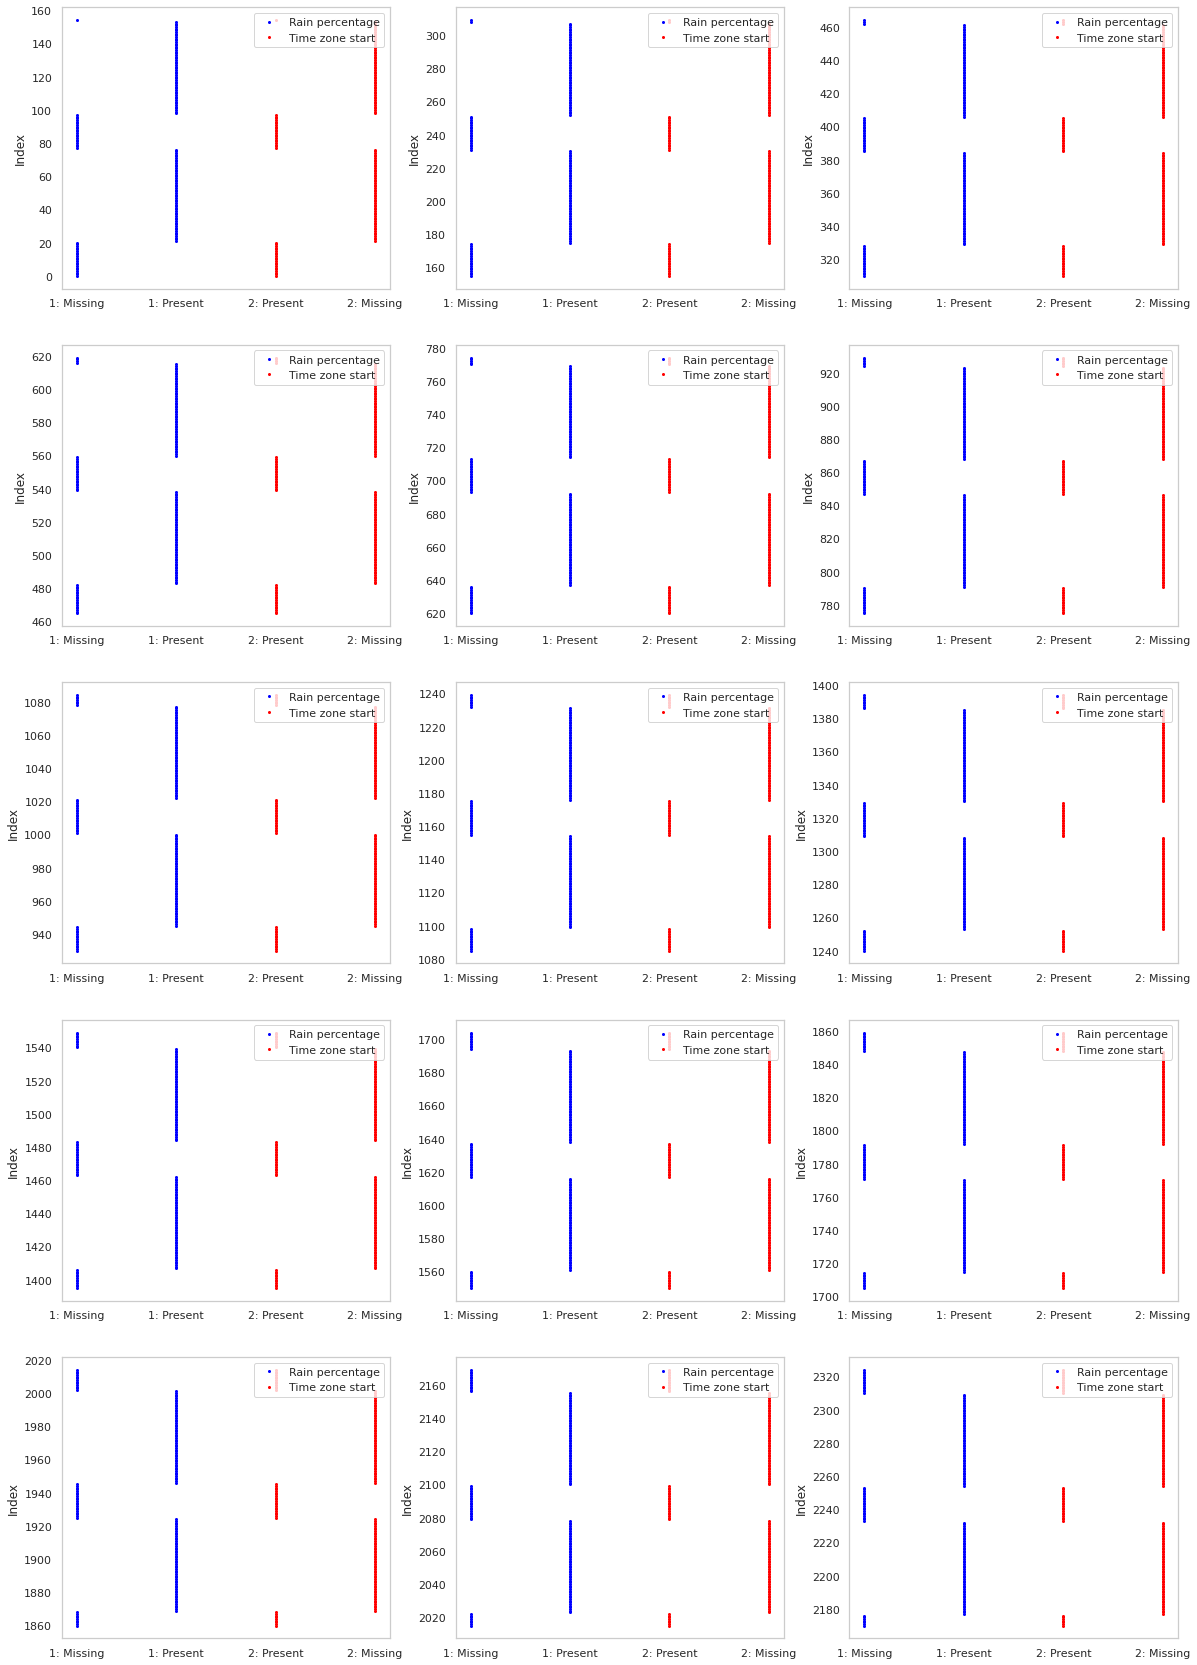

In [20]:
xdf = data.copy()
xdf.M_RAIN_PERCENTAGE = np.where(xdf.M_RAIN_PERCENTAGE.isnull(),'1: Missing','1: Present')
xdf.M_ZONE_START = np.where(xdf.M_ZONE_START.isnull(),'2: Missing','2: Present')
xdf.M_ZONE_START.unique()

plt.figure(figsize=(20,30))
count = 0
for i in range(1,16):
    x1 = xdf[count:count+155].M_RAIN_PERCENTAGE
    x2 = xdf[count:count+155].M_ZONE_START
    index = range(count,count+155)
    plt.subplot(5,3,i)
    plt.plot(x1,index,'bo',markersize = 2,label='Rain percentage')
    plt.plot(x2,index,'ro',markersize = 2,label='Time zone start')
    plt.ylabel('Index') 
    plt.legend(loc='upper right')
    plt.grid(False)
    count+=155

From these plots, we can generalise that the missing values in one column appear in rows where the others are filled. This holds true for the other columns across the two sets. As the insights build up, we willgain better claarity on how to prepare the data to achieve overall completeness and accuracy.

<br>
<h4><b>4. Cleaning the Data</b></h4>

<b> (a) We will drop the following rows immediately </b>
1. Rows where the number of forcast samples equals 0 as they provide no prediction at time t = 0
2. Rows where the session type is unknown (0)
3. Rows where the packet received shows a session type of NaN or 0
4. Rows where the packet received is sent while the game is paused
5. Rows where the packet received shows player is both spectating and playing online (inconsistency)
6. Rows where marshal_zone_start or marshal_zone_flag is null, as these indicates gaps in the game

In [21]:
df = data.copy()
df.shape

(3572328, 58)

In [22]:
df.drop(df[df['M_NUM_WEATHER_FORECAST_SAMPLES']==0].index, inplace=True)
df[df['M_NUM_WEATHER_FORECAST_SAMPLES']==0].count()

M_PACKET_FORMAT                                   0
M_GAME_MAJOR_VERSION                              0
M_GAME_MINOR_VERSION                              0
M_PACKET_VERSION                                  0
M_PACKET_ID                                       0
M_SESSION_UID                                     0
M_SESSION_TIME                                    0
M_FRAME_IDENTIFIER                                0
M_PLAYER_CAR_INDEX                                0
M_SECONDARY_PLAYER_CAR_INDEX                      0
M_BRAKING_ASSIST                                  0
M_SESSION_LINK_IDENTIFIER                         0
M_PIT_RELEASE_ASSIST                              0
TIMESTAMP                                         0
M_ZONE_START                                      0
M_ZONE_FLAG                                       0
M_PIT_STOP_WINDOW_IDEAL_LAP                       0
M_TRACK_TEMPERATURE                               0
M_TRACK_LENGTH                                    0
M_GAME_PAUSE

In [23]:
df.shape

(2745117, 58)

In [24]:
df.drop(df[df['M_SESSION_TYPE']==0].index, inplace=True)
df.shape

(2745117, 58)

In [25]:
df.drop(df[df['M_GAME_PAUSED']==1].index, inplace=True)
df.shape

(2696299, 58)

In [26]:
df.drop(df[(df['M_IS_SPECTATING'] == 1) & (df['M_NETWORK_GAME'] == 1)].index, inplace=True)
df.shape

(2690986, 58)

In [27]:
df.drop(df[df['M_WEATHER_FORECAST_SAMPLES_M_SESSION_TYPE'].isnull()].index, inplace=True)
df.shape

(1957078, 58)

This last operation leaves the zone start and zone flag columns with NaN values as we can see below. We will therefore eliminate these columns in due time.

In [28]:
df['M_ZONE_FLAG'].isnull().sum()

1957078

<br><b>(a) We will drop the following columns immediately:</b>
1. Redundant columns not included with the packet, starting with gamehost and timestamp
2. Redundant columns with single unique values (i.e., predominantly ID columns)
3. Duplicated Columns
4. Already Engineered Columns
5. Forcast samples columns outside weather and %rainfall, since this is a weather forecast project

We start by aggregating the session duration and Session time left column to generate a new column representing the time delta in the game.

In [29]:
df['M_SESSION_TIME_SPENT'] = df['M_SESSION_DURATION'] - df['M_SESSION_TIME_LEFT']

In [30]:
drop_col = ['GAMEHOST','TIMESTAMP', 'M_ZONE_FLAG', 'M_ZONE_START', 'M_SESSION_DURATION', 
           'M_SESSION_TIME_LEFT', 'M_WEATHER_FORECAST_SAMPLES_M_TRACK_TEMPERATURE', 
            'M_WEATHER_FORECAST_SAMPLES_M_AIR_TEMPERATURE', 'M_WEATHER_FORECAST_SAMPLES_M_SESSION_TYPE']

for col in df.columns:
    if df[col].nunique()<2:
        drop_col.append(col)
print(drop_col)
len(drop_col)

['GAMEHOST', 'TIMESTAMP', 'M_ZONE_FLAG', 'M_ZONE_START', 'M_SESSION_DURATION', 'M_SESSION_TIME_LEFT', 'M_WEATHER_FORECAST_SAMPLES_M_TRACK_TEMPERATURE', 'M_WEATHER_FORECAST_SAMPLES_M_AIR_TEMPERATURE', 'M_WEATHER_FORECAST_SAMPLES_M_SESSION_TYPE', 'M_PACKET_FORMAT', 'M_GAME_MAJOR_VERSION', 'M_GAME_MINOR_VERSION', 'M_PACKET_VERSION', 'M_PACKET_ID', 'M_SECONDARY_PLAYER_CAR_INDEX', 'M_ZONE_START', 'M_ZONE_FLAG', 'M_GAME_PAUSED', 'GAMEHOST', 'M_SLI_PRO_NATIVE_SUPPORT', 'M_SAFETY_CAR_STATUS', 'M_SPECTATOR_CAR_INDEX', 'M_IS_SPECTATING']


23

In [31]:
df.drop(drop_col, axis=1, inplace=True)

In [32]:
df.count()

M_SESSION_UID                           1957078
M_SESSION_TIME                          1957078
M_FRAME_IDENTIFIER                      1957078
M_PLAYER_CAR_INDEX                      1957078
M_BRAKING_ASSIST                        1957078
M_SESSION_LINK_IDENTIFIER               1957078
M_PIT_RELEASE_ASSIST                    1957078
M_PIT_STOP_WINDOW_IDEAL_LAP             1957078
M_TRACK_TEMPERATURE                     1957078
M_TRACK_LENGTH                          1957078
M_FORECAST_ACCURACY                     1957078
M_AIR_TEMPERATURE                       1957078
M_NUM_WEATHER_FORECAST_SAMPLES          1957078
M_TRACK_ID                              1957078
M_ERSASSIST                             1957078
M_FORMULA                               1957078
M_SEASON_LINK_IDENTIFIER                1957078
M_PIT_ASSIST                            1957078
M_GEARBOX_ASSIST                        1957078
M_SESSION_TYPE                          1957078
M_PIT_STOP_WINDOW_LATEST_LAP            

In [33]:
df.isna().any().sum()

6

<b>(c) Filling in the 6 columns containing single missing values</b>

In [34]:
fill_col = df.columns[df.isna().any() == True]
for col in fill_col:
    df[col].fillna(df[col].mode()[0], inplace=True)
df.isna().any().sum()

0

In [35]:
#Shape of data before cleaning
data.shape

(3572328, 58)

In [36]:
#Shape of data after cleaning
df.shape

(1957078, 39)

In [37]:
#df.to_csv('cleaned_one.csv', encoding='utf-8', index=False)

## Part II: Exploratory Data Analysis and Feature Selection
<h4><b>Overview</b></h4>

This is the EDA and Feature Egineering component of our solution to the FormulaAI Hack 2022 Competition. The workflow for this notebook is outlined as follows: 
- Multivariate Exploratory Analysis
- Feature Importance and Selection

In [38]:
import os

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None, 'display.max_rows', 100)


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


import deepchecks as dc
from deepchecks.checks.methodology import SingleFeatureContribution
from deepchecks.base import Dataset

#from sklearnex import patch_sklearn
#patch_sklearn()
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline

from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import GenericUnivariateSelect
from sklearn.preprocessing import scale, StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy import stats

import random
import time
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

In [39]:
#data= pd.read_csv('cleaned_one.csv')
#data.head()

In [40]:
#data.drop('Unnamed: 0', axis =1, inplace = True)

In [41]:
#df = data.copy()
print(df.shape)
df.isna().values.any()

(1957078, 39)


False

<br>
<h4><b>1. Multivariate Exploratory Analysis</b></h4>
<p> Our first step is to visualise and understand the correlation that exists between the features in the data

<AxesSubplot:>

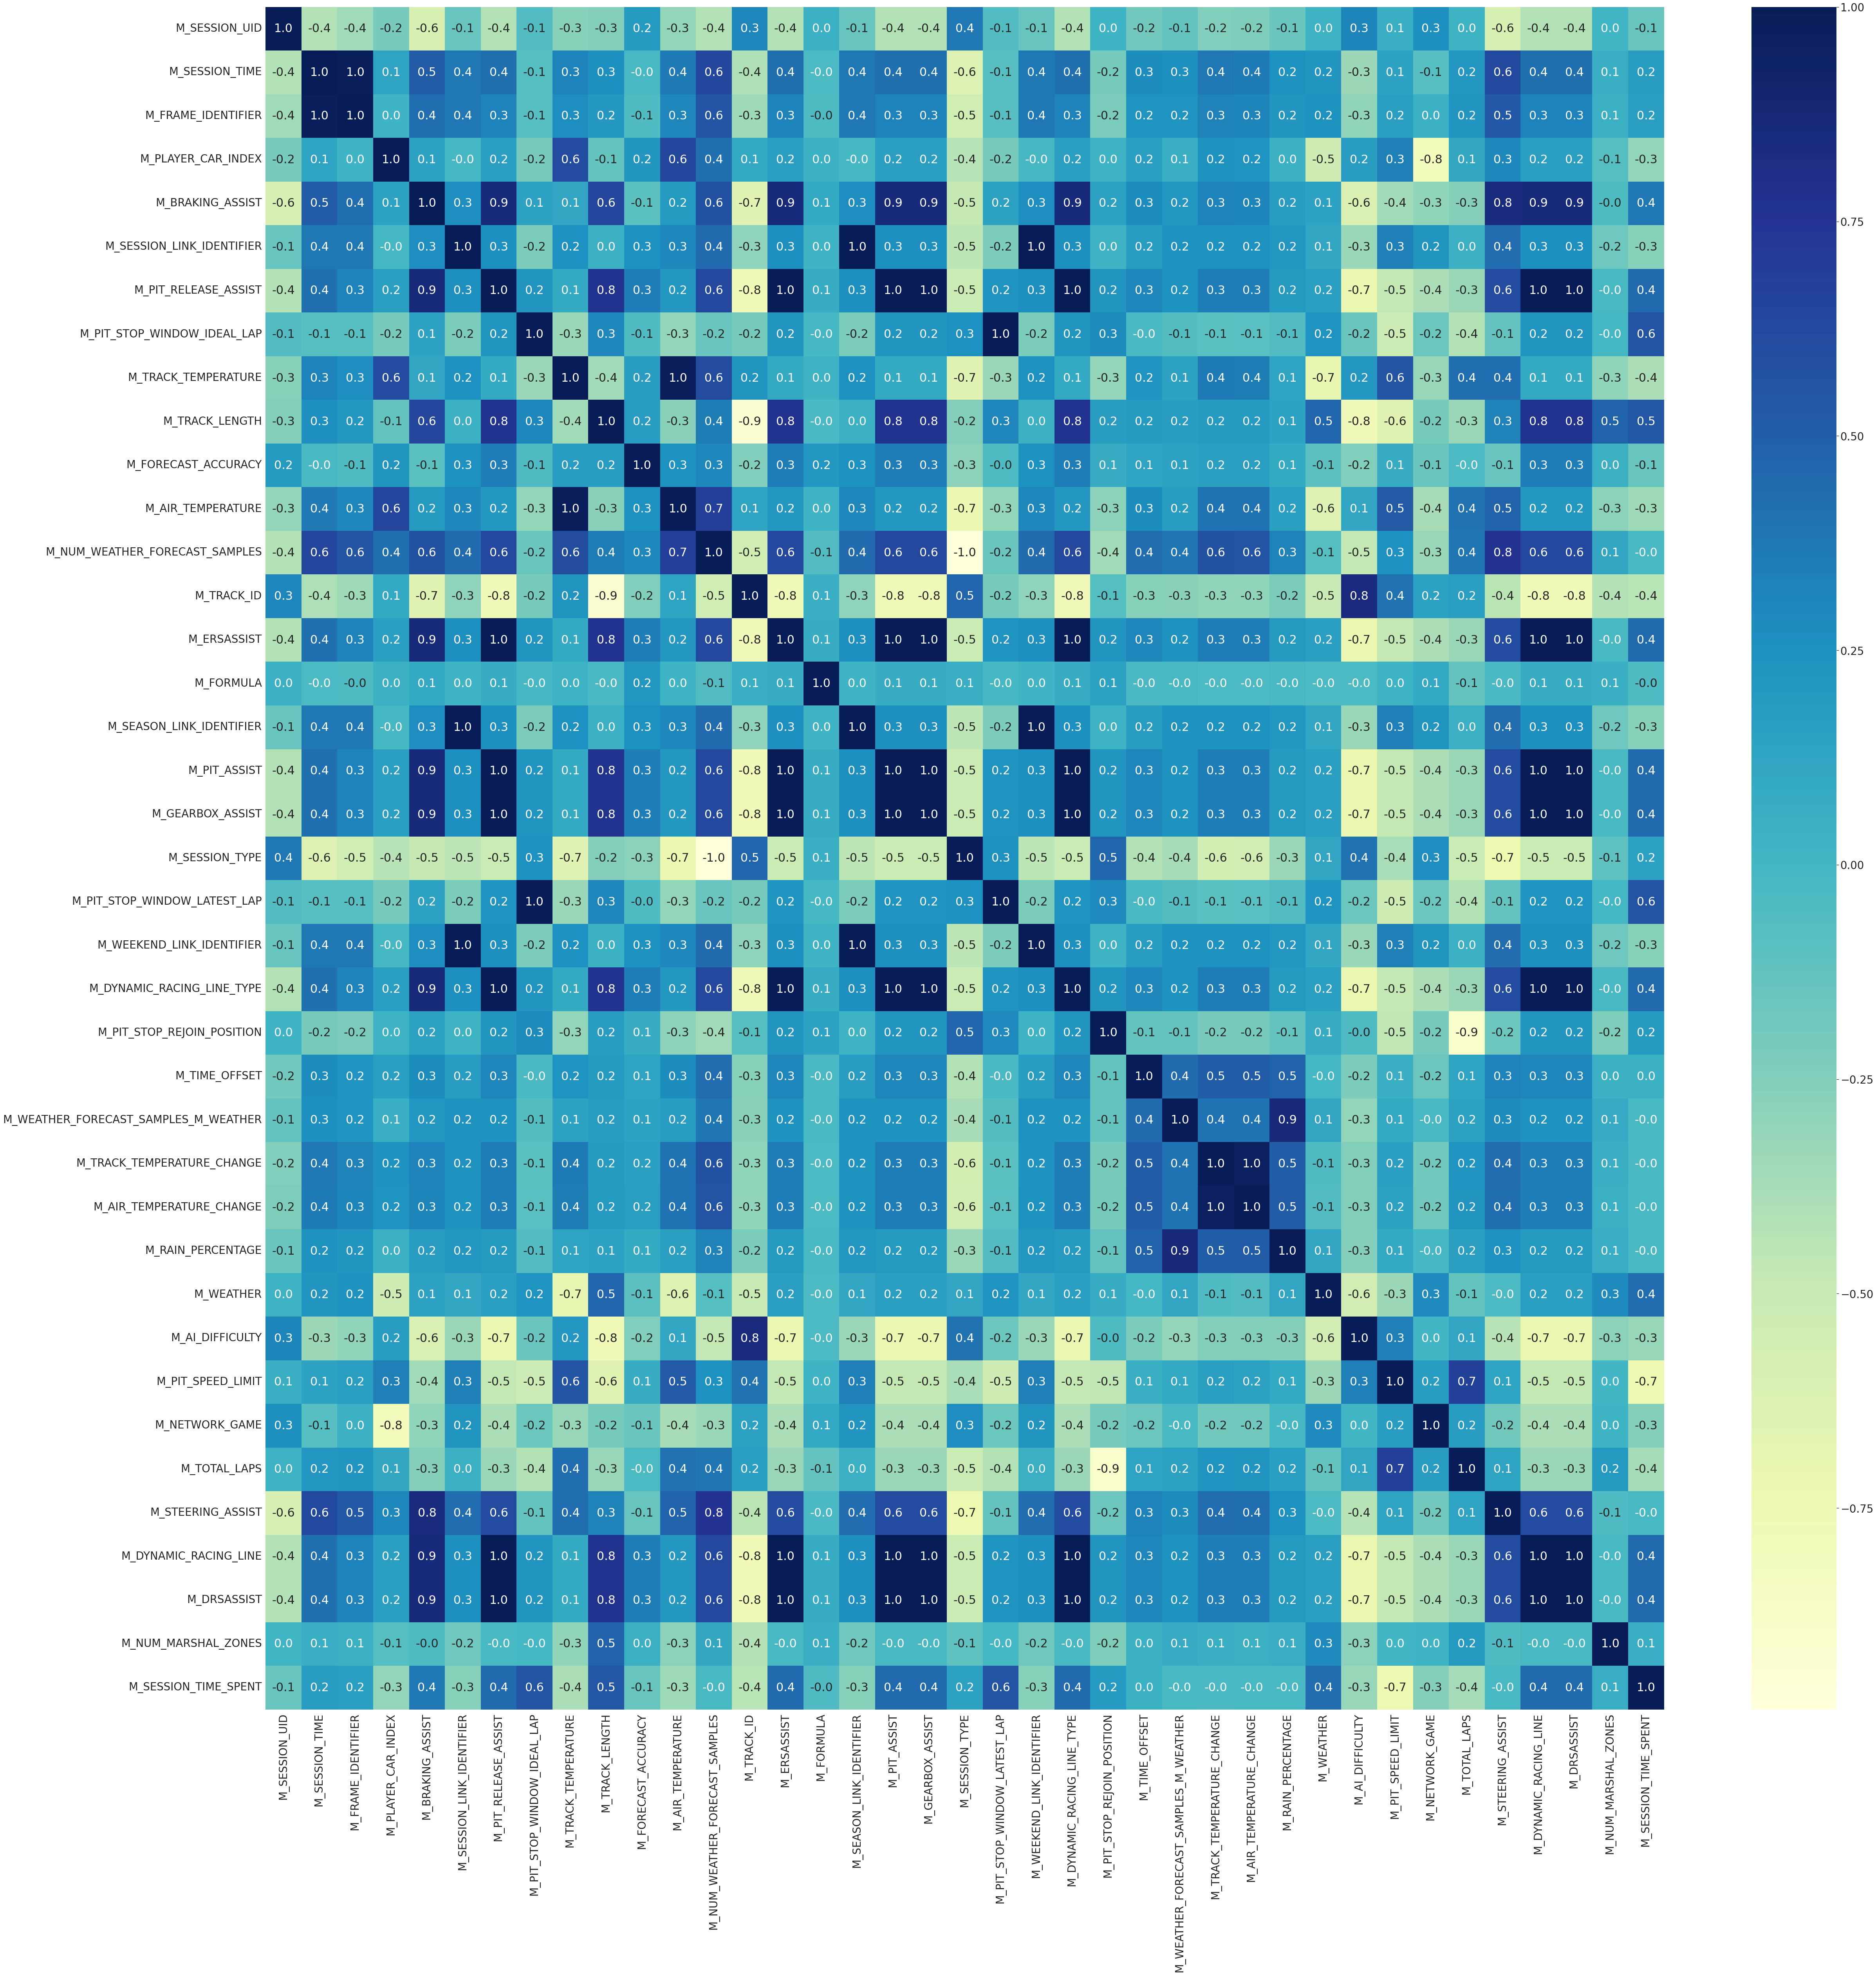

In [42]:
corrmat = df.corr()
#f, ax = plt.subplots(figsize=(16, 12))
#sns.heatmap(corrmat, vmax=.8, annot=True, square=True, fmt='.2f')

plt.figure(figsize=(80,80))
sns.set(font_scale=2.5)
sns.heatmap(corrmat, annot=True, fmt='.1f', cmap='YlGnBu')

The above plot is too cluttered. If we zoom further in to the above plot, we find that M_WEEKEND_LINK_IDENTIFIER, M_SEASON_LINK_IDENTIFIER and M_SESSION_LINK_IDENTIFIER show
perfect correleration of 1.

In [43]:
xtremilar_col = ['M_WEEKEND_LINK_IDENTIFIER', 'M_SEASON_LINK_IDENTIFIER', 'M_SESSION_LINK_IDENTIFIER']

<AxesSubplot:>

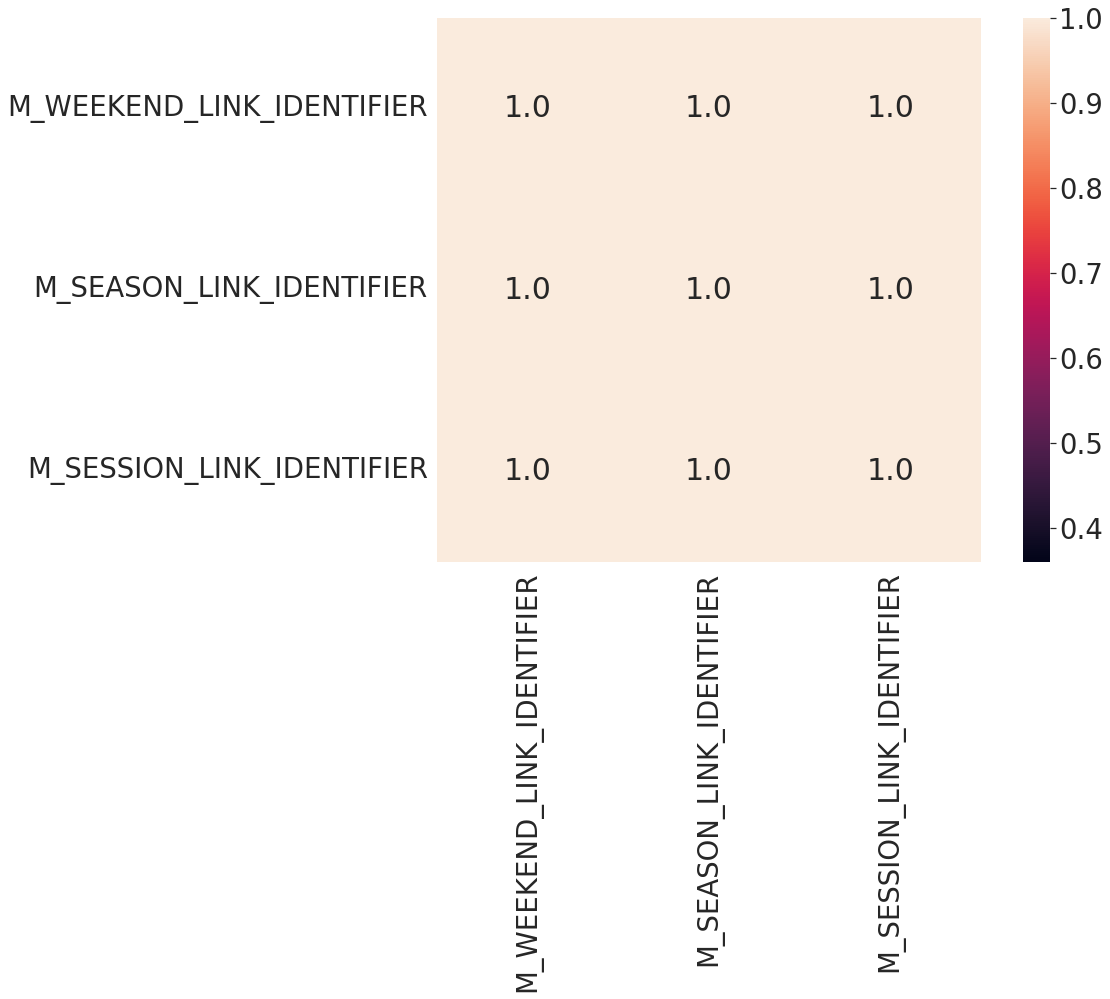

In [44]:
corrmat = df[xtremilar_col ].corr()
f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(corrmat, vmax=.4, annot=True, square=True, fmt='.1f',)

In [45]:
for col in xtremilar_col:
    print(col,'-->',df[col].nunique())

M_WEEKEND_LINK_IDENTIFIER --> 37
M_SEASON_LINK_IDENTIFIER --> 32
M_SESSION_LINK_IDENTIFIER --> 49


<br>For the heatmap to have indicated a correlation of 1.0, then it means one or 2 columns will most likely contain all of the values in others. We will perform a groupby on each of them to identify how many unique values in one column correspond to each unique value in another column.

In [46]:
df[xtremilar_col].groupby('M_WEEKEND_LINK_IDENTIFIER').nunique()

M_SEASON_LINK_IDENTIFIER  M_SESSION_LINK_IDENTIFIER
M_WEEKEND_LINK_IDENTIFIER                                                     
861334657                                         1                          1
1110683812                                        1                          1
1484504721                                        1                          1
1553478724                                        1                          1
1563223907                                        1                          1
1618716359                                        1                          1
1835625305                                        1                          2
1951222531                                        1                          2
1951222631                                        1                          2
1951222731                                        1                          2
1951222831                                        1                          1
2121613153                                        1                          1
2147180855                                        1                          1
2179439779                                        1                          2
2184232491                                        1                          2
2585742948                                        1                          1
2684478162                                        1                          1
2756721461                                        1                          2
2763502765                                        1                          1
2842617962                                        1                          1
2880781899                                        1                          2
2908583271                                        1                          1
3037248480                                        1                          1
3081081018                                        1                          1
3271241059                                        1                          1
3314973601                                        1                          2
3447124844                                        1                          2
3553396220                                        1                          1
3555771081                                        1                          1
3589936465                                        1                          1
3605912076                                        1                          1
3846328331                                        1                          2
4115554664                                        1                          1
4155675678                                        1                          1
4155675778                                        1                          2
4155675878                                        1                          1
4264308897                                        1                          1

In [47]:
df[xtremilar_col].groupby('M_SEASON_LINK_IDENTIFIER').nunique()

M_WEEKEND_LINK_IDENTIFIER  M_SESSION_LINK_IDENTIFIER
M_SEASON_LINK_IDENTIFIER                                                      
861334657                                         1                          1
1110683812                                        1                          1
1484504721                                        1                          1
1553478724                                        1                          1
1563223907                                        1                          1
1618716359                                        1                          1
1835625305                                        1                          2
1951222531                                        4                          7
2121613153                                        1                          1
2147179955                                        1                          1
2179439779                                        1                          2
2184232491                                        1                          2
2585742948                                        1                          1
2684478162                                        1                          1
2756721461                                        1                          2
2763502765                                        1                          1
2842617962                                        1                          1
2880781899                                        1                          2
2908583271                                        1                          1
3037248480                                        1                          1
3081081018                                        1                          1
3271241059                                        1                          1
3314973601                                        1                          2
3447124844                                        1                          2
3553396220                                        1                          1
3555771081                                        1                          1
3589936465                                        1                          1
3605912076                                        1                          1
3846328331                                        1                          2
4115554664                                        1                          1
4155674778                                        3                          4
4264308897                                        1                          1

In [48]:
df[xtremilar_col].groupby('M_SESSION_LINK_IDENTIFIER').nunique()

M_WEEKEND_LINK_IDENTIFIER  M_SEASON_LINK_IDENTIFIER
M_SESSION_LINK_IDENTIFIER                                                     
861334657                                          1                         1
1110683812                                         1                         1
1484504761                                         1                         1
1553478724                                         1                         1
1563223907                                         1                         1
1618716359                                         1                         1
1835625305                                         1                         1
1835625315                                         1                         1
1951222561                                         1                         1
1951222591                                         1                         1
1951222661                                         1                         1
1951222691                                         1                         1
1951222731                                         1                         1
1951222791                                         1                         1
1951222831                                         1                         1
2121613153                                         1                         1
2147180865                                         1                         1
2179439779                                         1                         1
2179439789                                         1                         1
2184232491                                         1                         1
2184232501                                         1                         1
2585742948                                         1                         1
2684478162                                         1                         1
2756721461                                         1                         1
2756721471                                         1                         1
2763502775                                         1                         1
2842617962                                         1                         1
2880781899                                         1                         1
2880781909                                         1                         1
2908583271                                         1                         1
3037248480                                         1                         1
3081081018                                         1                         1
3271241059                                         1                         1
3314973601                                         1                         1
3314973611                                         1                         1
3447124844                                         1                         1
3447124854                                         1                         1
3553396220                                         1                         1
3555771081                                         1                         1
3589936465                                         1                         1
3605912076                                         1                         1
3846328331                                         1                         1
3846328341                                         1                         1
4115554664                                         1                         1
4155675688                                         1                         1
4155675778                                         1                         1
4155675788                                         1                         1
4155675888                                         1                         1
4264308897                                         1                         

From the first result, we find that only the season link ID occurs exactly once in the weekend ID groups. However, the second result shows that the weekend ID occurs more than once in some season ID groups. Therefore, weekend ID is a superset of season ID, indicating that weekend ID captures all the information that weekend ID presents. 

Finally, we see that in the third result, both season ID and weekend ID occur exactly once in the session ID group, indicating that session ID captures all the informations that both season ID and weekend ID presents. This makes sense considering that whether the games are played in a weekend, a season, or otherwise, each game is played in session. This provides the justification for which we will be dropping both the season and weekend IDs.

In [49]:
df.drop(xtremilar_col[:-1], axis=1, inplace=True)
print(df.shape)

(1957078, 37)


Now, let's zoom into the heatmap to observe the top 20 most correlated features with weather

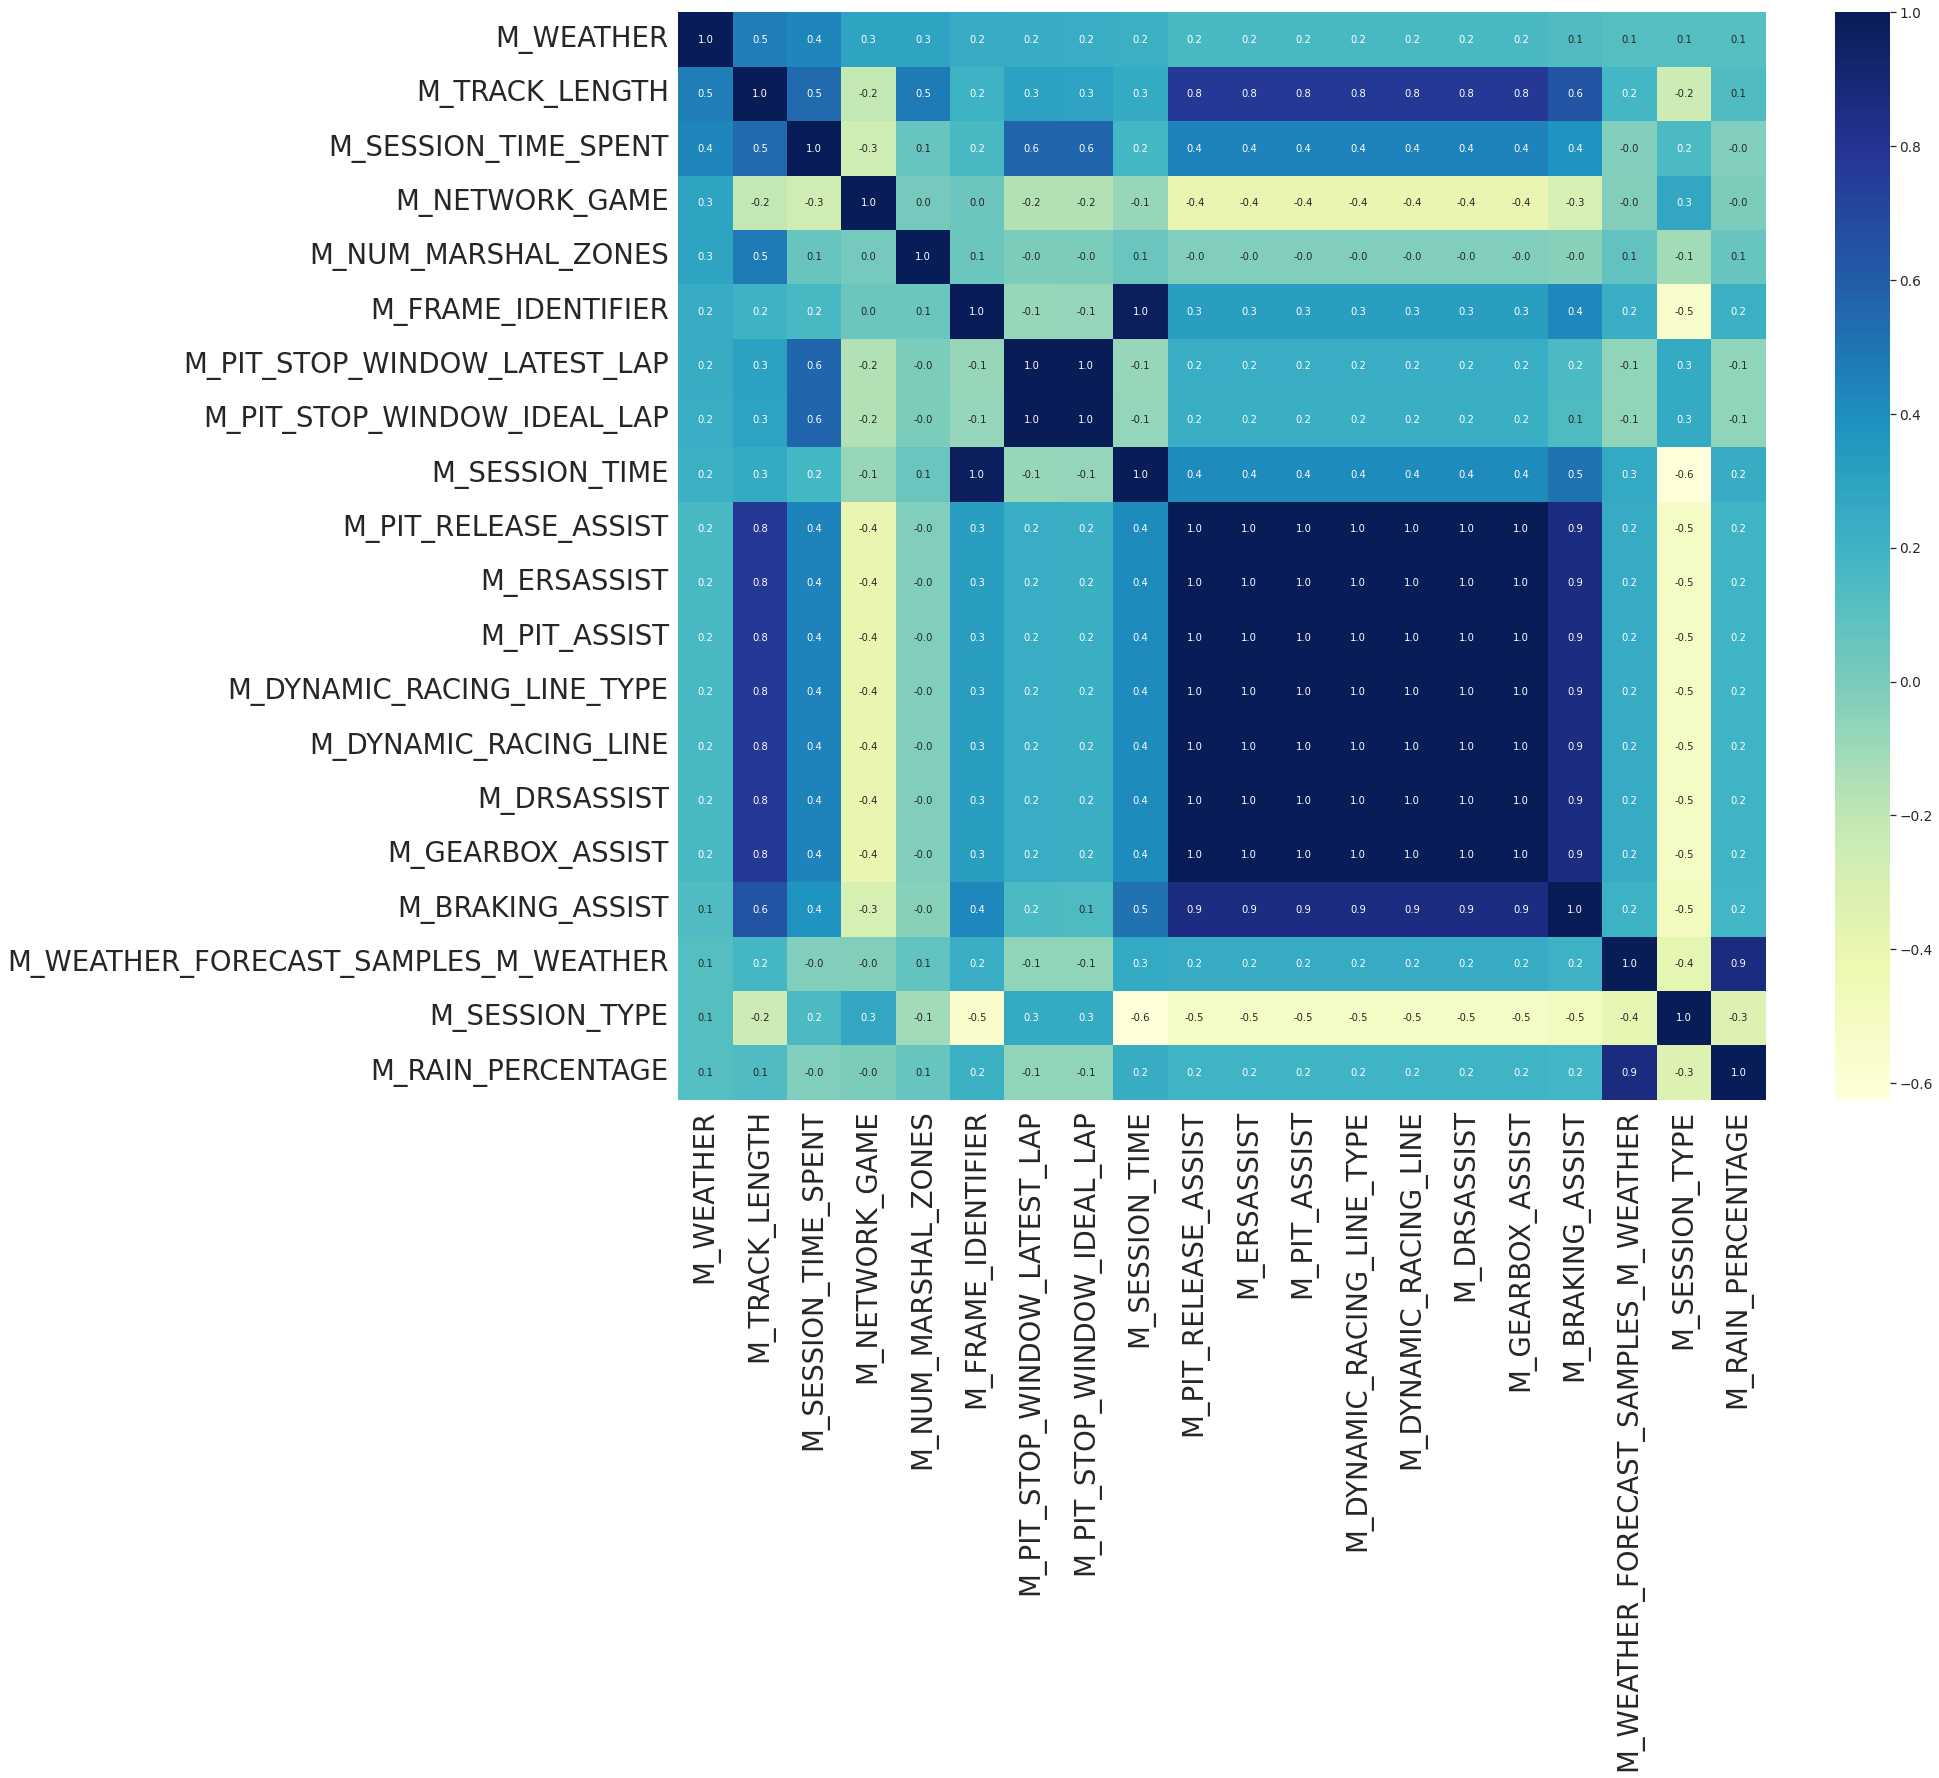

In [50]:
#### top 20 most correlated features with Weather (correlation matrix) 

f, ax = plt.subplots(figsize=(25,20))
k = 20 #number of variables for heatmap
cols = df.corr().nlargest(k, 'M_WEATHER')['M_WEATHER'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.1f', cmap='YlGnBu', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Zooming further, we notice a correlated submatrix of 7 features which showed perfect correleration of 1. This block contains five of the seven assist features and the two dynamic racing line features. 

Our assumption is that the other two assists features that do not make it to this block, namely steering assist and braking assist, could be due to a much smaller proportion of players using these assists, as more players typically have the experience to play without these 2 supports. 

In [51]:
xtremilar_col2 = [
'M_DYNAMIC_RACING_LINE_TYPE'
,'M_DYNAMIC_RACING_LINE'
,'M_PIT_RELEASE_ASSIST'
,'M_ERSASSIST'
,'M_PIT_ASSIST'
,'M_GEARBOX_ASSIST'
,'M_STEERING_ASSIST'
,'M_BRAKING_ASSIST'
,'M_DRSASSIST']

<AxesSubplot:>

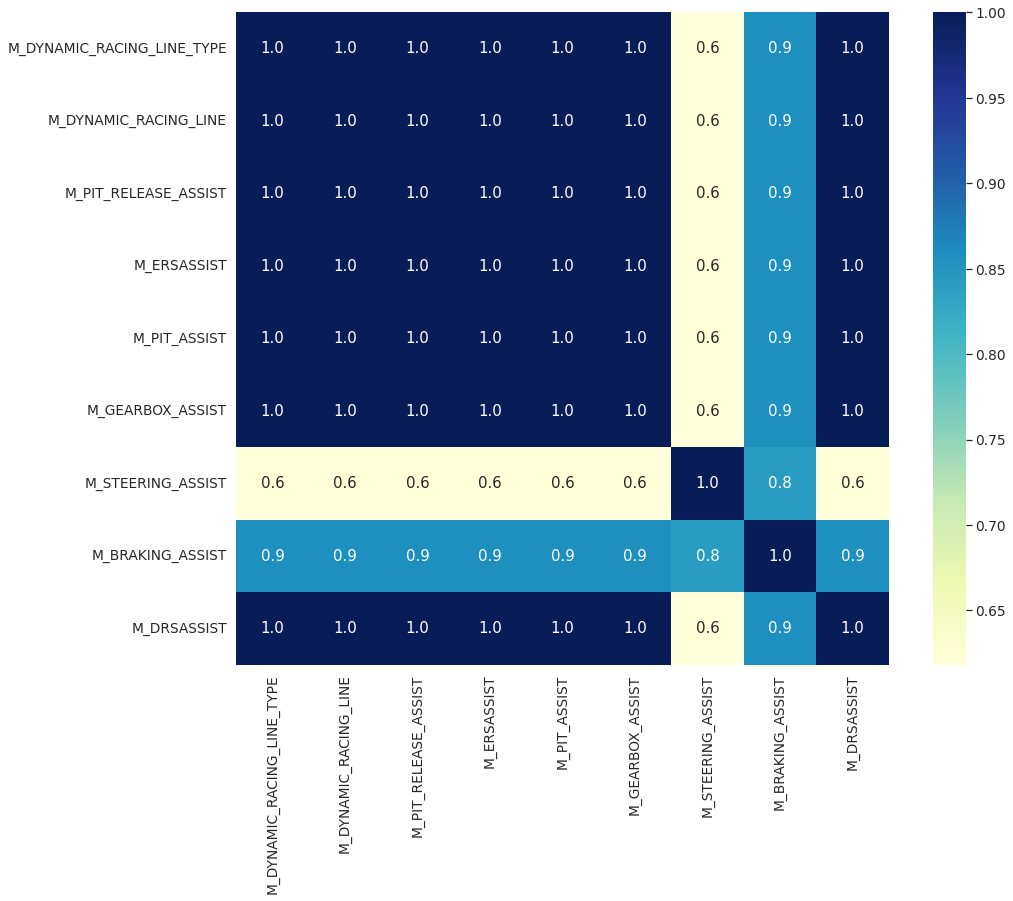

In [52]:
corrmat2 = df[xtremilar_col2].corr()
f, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(corrmat2, vmax=1, annot=True, square=True, fmt='.1f', cmap='YlGnBu')

Now, we have added the two remaining assists and we see they are not as correlated. We begin by performing a groupby on the columns in the list, one column at a time.

In [53]:
df[xtremilar_col2].groupby('M_DYNAMIC_RACING_LINE_TYPE').nunique()

M_DYNAMIC_RACING_LINE  M_PIT_RELEASE_ASSIST  \
M_DYNAMIC_RACING_LINE_TYPE                                                
0                                               1                     1   
1                                               1                     1   

                            M_ERSASSIST  M_PIT_ASSIST  M_GEARBOX_ASSIST  \
M_DYNAMIC_RACING_LINE_TYPE                                                
0                                     1             1                 1   
1                                     1             1                 1   

                            M_STEERING_ASSIST  M_BRAKING_ASSIST  M_DRSASSIST  
M_DYNAMIC_RACING_LINE_TYPE                                                    
0                                           1                 1            1  
1                                           2                 3            1

In [54]:
df[xtremilar_col2].groupby('M_DYNAMIC_RACING_LINE').nunique()

M_DYNAMIC_RACING_LINE_TYPE  M_PIT_RELEASE_ASSIST  \
M_DYNAMIC_RACING_LINE                                                     
0.0                                             1                     1   
2.0                                             1                     1   

                       M_ERSASSIST  M_PIT_ASSIST  M_GEARBOX_ASSIST  \
M_DYNAMIC_RACING_LINE                                                
0.0                              1             1                 1   
2.0                              1             1                 1   

                       M_STEERING_ASSIST  M_BRAKING_ASSIST  M_DRSASSIST  
M_DYNAMIC_RACING_LINE                                                    
0.0                                    1                 1            1  
2.0                                    2                 3            1

In [55]:
df[xtremilar_col2].groupby('M_ERSASSIST').nunique()

M_DYNAMIC_RACING_LINE_TYPE  M_DYNAMIC_RACING_LINE  \
M_ERSASSIST                                                      
0                                     1                      1   
1                                     1                      1   

             M_PIT_RELEASE_ASSIST  M_PIT_ASSIST  M_GEARBOX_ASSIST  \
M_ERSASSIST                                                         
0                               1             1                 1   
1                               1             1                 1   

             M_STEERING_ASSIST  M_BRAKING_ASSIST  M_DRSASSIST  
M_ERSASSIST                                                    
0                            1                 1            1  
1                            2                 3            1

In [56]:
df[xtremilar_col2].groupby('M_PIT_ASSIST').nunique()

M_DYNAMIC_RACING_LINE_TYPE  M_DYNAMIC_RACING_LINE  \
M_PIT_ASSIST                                                      
0                                      1                      1   
1                                      1                      1   

              M_PIT_RELEASE_ASSIST  M_ERSASSIST  M_GEARBOX_ASSIST  \
M_PIT_ASSIST                                                        
0                                1            1                 1   
1                                1            1                 1   

              M_STEERING_ASSIST  M_BRAKING_ASSIST  M_DRSASSIST  
M_PIT_ASSIST                                                    
0                             1                 1            1  
1                             2                 3            1

In [57]:
df[xtremilar_col2].groupby('M_GEARBOX_ASSIST').nunique()

M_DYNAMIC_RACING_LINE_TYPE  M_DYNAMIC_RACING_LINE  \
M_GEARBOX_ASSIST                                                      
1                                          1                      1   
3                                          1                      1   

                  M_PIT_RELEASE_ASSIST  M_ERSASSIST  M_PIT_ASSIST  \
M_GEARBOX_ASSIST                                                    
1                                    1            1             1   
3                                    1            1             1   

                  M_STEERING_ASSIST  M_BRAKING_ASSIST  M_DRSASSIST  
M_GEARBOX_ASSIST                                                    
1                                 1                 1            1  
3                                 2                 3            1

In [58]:
df[xtremilar_col2].groupby('M_STEERING_ASSIST').nunique()

M_DYNAMIC_RACING_LINE_TYPE  M_DYNAMIC_RACING_LINE  \
M_STEERING_ASSIST                                                      
0.0                                         2                      2   
1.0                                         1                      1   

                   M_PIT_RELEASE_ASSIST  M_ERSASSIST  M_PIT_ASSIST  \
M_STEERING_ASSIST                                                    
0.0                                   2            2             2   
1.0                                   1            1             1   

                   M_GEARBOX_ASSIST  M_BRAKING_ASSIST  M_DRSASSIST  
M_STEERING_ASSIST                                                   
0.0                               2                 3            2  
1.0                               1                 1            1

In [59]:
df[xtremilar_col2].groupby('M_BRAKING_ASSIST').nunique()

M_DYNAMIC_RACING_LINE_TYPE  M_DYNAMIC_RACING_LINE  \
M_BRAKING_ASSIST                                                      
0                                          2                      2   
2                                          1                      1   
3                                          1                      1   

                  M_PIT_RELEASE_ASSIST  M_ERSASSIST  M_PIT_ASSIST  \
M_BRAKING_ASSIST                                                    
0                                    2            2             2   
2                                    1            1             1   
3                                    1            1             1   

                  M_GEARBOX_ASSIST  M_STEERING_ASSIST  M_DRSASSIST  
M_BRAKING_ASSIST                                                    
0                                2                  1            2  
2                                1                  1            1  
3                                1                  2            1

In [60]:
df[xtremilar_col2].groupby('M_PIT_RELEASE_ASSIST').nunique()

M_DYNAMIC_RACING_LINE_TYPE  M_DYNAMIC_RACING_LINE  \
M_PIT_RELEASE_ASSIST                                                      
0                                              1                      1   
1                                              1                      1   

                      M_ERSASSIST  M_PIT_ASSIST  M_GEARBOX_ASSIST  \
M_PIT_RELEASE_ASSIST                                                
0                               1             1                 1   
1                               1             1                 1   

                      M_STEERING_ASSIST  M_BRAKING_ASSIST  M_DRSASSIST  
M_PIT_RELEASE_ASSIST                                                    
0                                     1                 1            1  
1                                     2                 3            1

In [61]:
df[xtremilar_col2].groupby('M_DRSASSIST').nunique()

M_DYNAMIC_RACING_LINE_TYPE  M_DYNAMIC_RACING_LINE  \
M_DRSASSIST                                                      
0.0                                   1                      1   
1.0                                   1                      1   

             M_PIT_RELEASE_ASSIST  M_ERSASSIST  M_PIT_ASSIST  \
M_DRSASSIST                                                    
0.0                             1            1             1   
1.0                             1            1             1   

             M_GEARBOX_ASSIST  M_STEERING_ASSIST  M_BRAKING_ASSIST  
M_DRSASSIST                                                         
0.0                         1                  1                 1  
1.0                         1                  2                 3

It's a litlle challenging deciding which of the 9 columns to retain, considering that none of the grouby results shows columns having values uniquely occuring once across the groups. An even more important question is whether we need any of these features to predict the targets. We will therefore implement a feature contribution assessment to evaluate which of the 9 (if any) have the highest predictive power score with respect to the targets.

In [62]:
_ = Dataset(df[xtremilar_col2], label=df['M_WEATHER'])
SingleFeatureContribution().run(_)

Single Feature Contribution Return the PPS (Predictive Power Score) of all features in relation to the label. Read More... Additional Outputs ✓ Nothing found

In [63]:
_ = Dataset(df[xtremilar_col2], label=df['M_RAIN_PERCENTAGE'])
SingleFeatureContribution().run(_)

Single Feature Contribution Return the PPS (Predictive Power Score) of all features in relation to the label. Read More... Additional Outputs ✓ Nothing found

We will just drop all the 9 features. Our argument is that the AI engine doesn't take these informations into consideration to make inference on expected weather condition.

In [64]:
df.drop(xtremilar_col2, axis=1, inplace=True)
print(df.shape)
df.head()

(1957078, 28)


M_SESSION_UID  M_SESSION_TIME  M_FRAME_IDENTIFIER  \
17038  2939734289500381614          65.276                1647   
17039  2939734289500381614          65.276                1647   
17040  2939734289500381614          65.276                1647   
17041  2939734289500381614          65.276                1647   
17042  2939734289500381614          65.276                1647   

       M_PLAYER_CAR_INDEX  M_SESSION_LINK_IDENTIFIER  \
17038                   0                 1553478724   
17039                   0                 1553478724   
17040                   0                 1553478724   
17041                   0                 1553478724   
17042                   0                 1553478724   

       M_PIT_STOP_WINDOW_IDEAL_LAP  M_TRACK_TEMPERATURE  M_TRACK_LENGTH  \
17038                            0                   33            4650   
17039                            0                   33            4650   
17040                            0                   33            4650   
17041                            0                   33            4650   
17042                            0                   33            4650   

       M_FORECAST_ACCURACY  M_AIR_TEMPERATURE  M_NUM_WEATHER_FORECAST_SAMPLES  \
17038                    0                 25                              10   
17039                    0                 25                              10   
17040                    0                 25                              10   
17041                    0                 25                              10   
17042                    0                 25                              10   

       M_TRACK_ID  M_FORMULA  M_SESSION_TYPE  M_PIT_STOP_WINDOW_LATEST_LAP  \
17038          28          0               8                             0   
17039          28          0               8                             0   
17040          28          0               8                             0   
17041          28          0               8                             0   
17042          28          0               8                             0   

       M_PIT_STOP_REJOIN_POSITION  M_TIME_OFFSET  \
17038                           0            0.0   
17039                           0            5.0   
17040                           0           10.0   
17041                           0            0.0   
17042                           0            5.0   

       M_WEATHER_FORECAST_SAMPLES_M_WEATHER  M_TRACK_TEMPERATURE_CHANGE  \
17038                                   0.0                         2.0   
17039                                   0.0                         2.0   
17040                                   0.0                         2.0   
17041                                   1.0                         1.0   
17042                                   1.0                         2.0   

       M_AIR_TEMPERATURE_CHANGE  M_RAIN_PERCENTAGE  M_WEATHER  \
17038                       2.0                1.0          0   
17039                       2.0                1.0          0   
17040                       2.0                2.0          0   
17041                       1.0                5.0          0   
17042                       2.0                5.0          0   

       M_AI_DIFFICULTY  M_PIT_SPEED_LIMIT  M_NETWORK_GAME  M_TOTAL_LAPS  \
17038               31                 80             1.0         200.0   
17039               31                 80             1.0         200.0   
17040               31                 80             1.0         200.0   
17041               31                 80             1.0         200.0   
17042               31                 80             1.0         200.0   

       M_NUM_MARSHAL_ZONES  M_SESSION_TIME_SPENT  
17038                 16.0                    61  
17039                 16.0                    61  
17040                 16.0                    61  
17041                 16.0                    61  
17042      

The above contribution checks showed us that we do not need any of the 9 features for our model. We will apply such an assessment on the rest of our features during feature selection. For now, we want to explore the groupings in the data.

<br><b> Exploring the groupings in the data</b>

In [65]:
de = df.copy()

In [66]:
dd = de.groupby(['M_SESSION_UID', 'M_TIME_OFFSET'])
dd.first()

M_SESSION_TIME  M_FRAME_IDENTIFIER  \
M_SESSION_UID        M_TIME_OFFSET                                       
21060822879603068    0.0                    28.860                 624   
                     5.0                    28.860                 624   
                     10.0                   28.860                 624   
                     15.0                   28.860                 624   
                     30.0                   28.860                 624   
...                                            ...                 ...   
18024707237561859570 10.0                    0.004                   0   
                     15.0                    0.004                   0   
                     30.0                    0.004                   0   
                     45.0                    0.004                   0   
                     60.0                    0.004                   0   

                                    M_PLAYER_CAR_INDEX  \
M_SESSION_UID        M_TIME_OFFSET                       
21060822879603068    0.0                            19   
                     5.0                            19   
                     10.0                           19   
                     15.0                           19   
                     30.0                           19   
...                                                ...   
18024707237561859570 10.0                            0   
                     15.0                            0   
                     30.0                            0   
                     45.0                            0   
                     60.0                            0   

                                    M_SESSION_LINK_IDENTIFIER  \
M_SESSION_UID        M_TIME_OFFSET                              
21060822879603068    0.0                           2184232491   
                     5.0                           2184232491   
                     10.0                          2184232491   
                     15.0                          2184232491   
                     30.0                          2184232491   
...                                                       ...   
18024707237561859570 10.0                          3846328341   
                     15.0                          3846328341   
                     30.0                          3846328341   
                     45.0                          3846328341   
                     60.0                          3846328341   

                                    M_PIT_STOP_WINDOW_IDEAL_LAP  \
M_SESSION_UID        M_TIME_OFFSET                                
21060822879603068    0.0                                      0   
                     5.0                                      0   
                     10.0                                     0   
                     15.0                                     0   
                     30.0                                     0   
...                                                         ...   
18024707237561859570 10.0                                     6   
                     15.0                                     6   
                     30.0                                     6   
                     45.0                                     6   
                     60.0                                     6   

                                    M_TRACK_TEMPERATURE  M_TRACK_LENGTH  \
M_SESSION_UID        M_TIME_OFFSET                                        
21060822879603068    0.0                             33            4650   
                     5.0                             33            4650   
                     10.0                            33            4650   
                     15.0                            33            4650   
                     30.0                            33            4650   
...                                                 ...             ...   


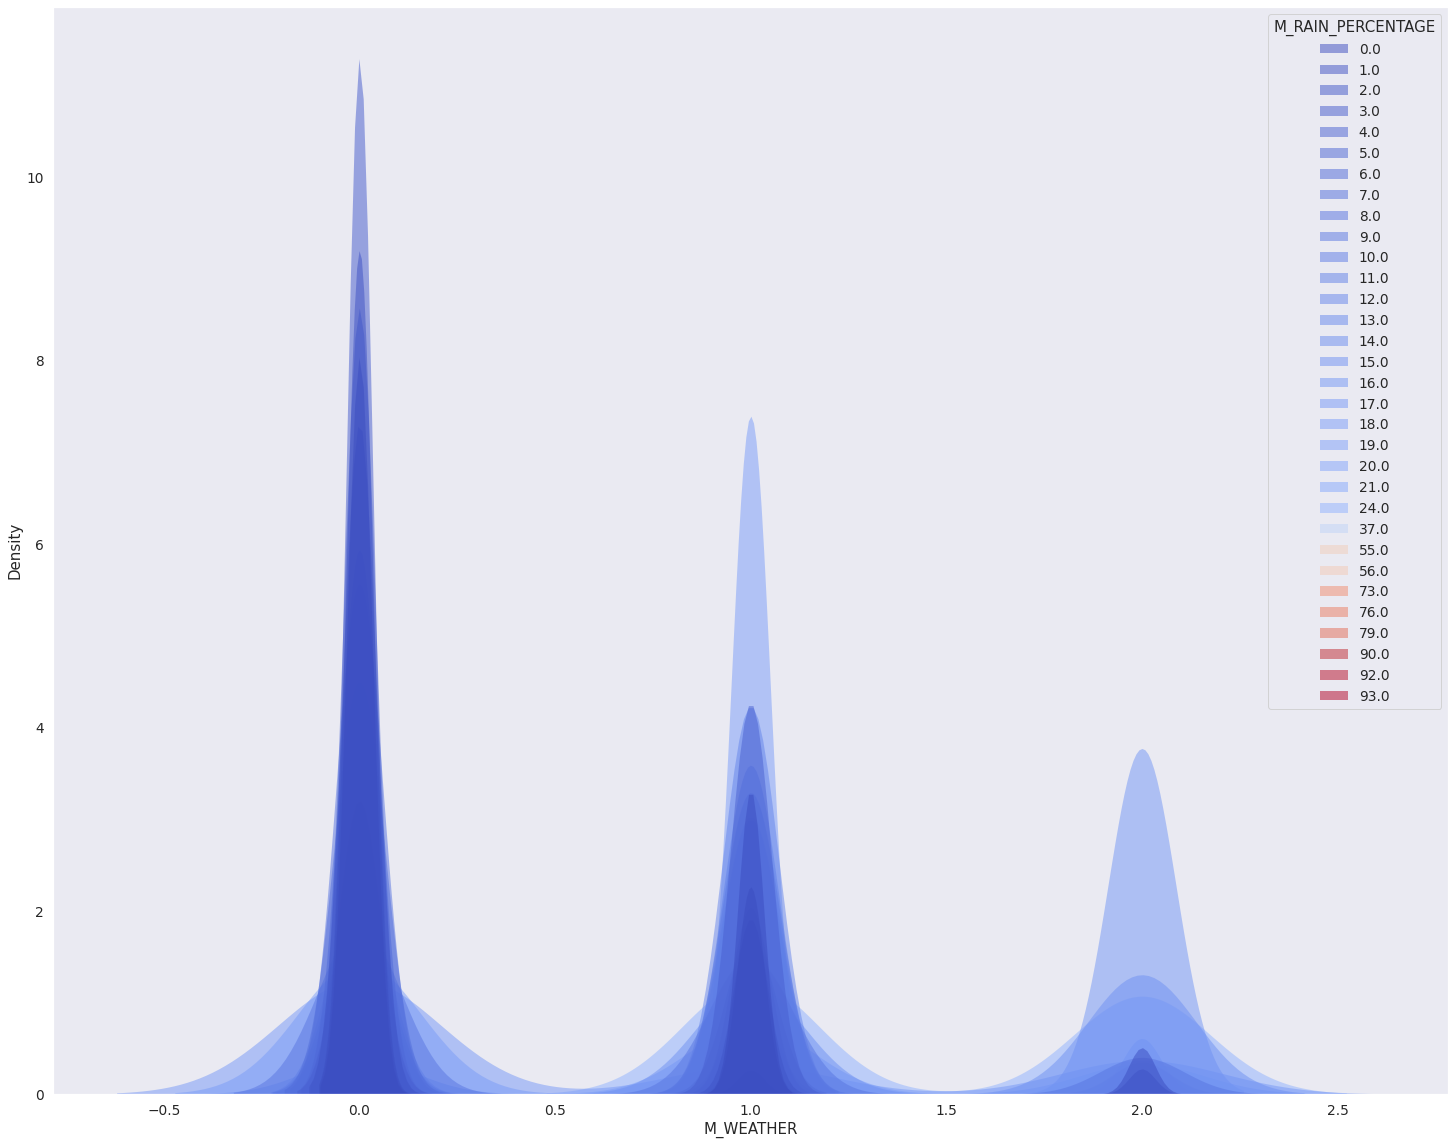

In [67]:
plt.figure(figsize=(25, 20))
sns.kdeplot(
   data=df, x="M_WEATHER", hue="M_RAIN_PERCENTAGE",
   fill=True, common_norm=False, palette="coolwarm",
   alpha=.5, linewidth=0,
)
plt.grid(False)

Now, let us explore the distribution of some of the features within the groups of the data, and see how these features change over time, session to session.

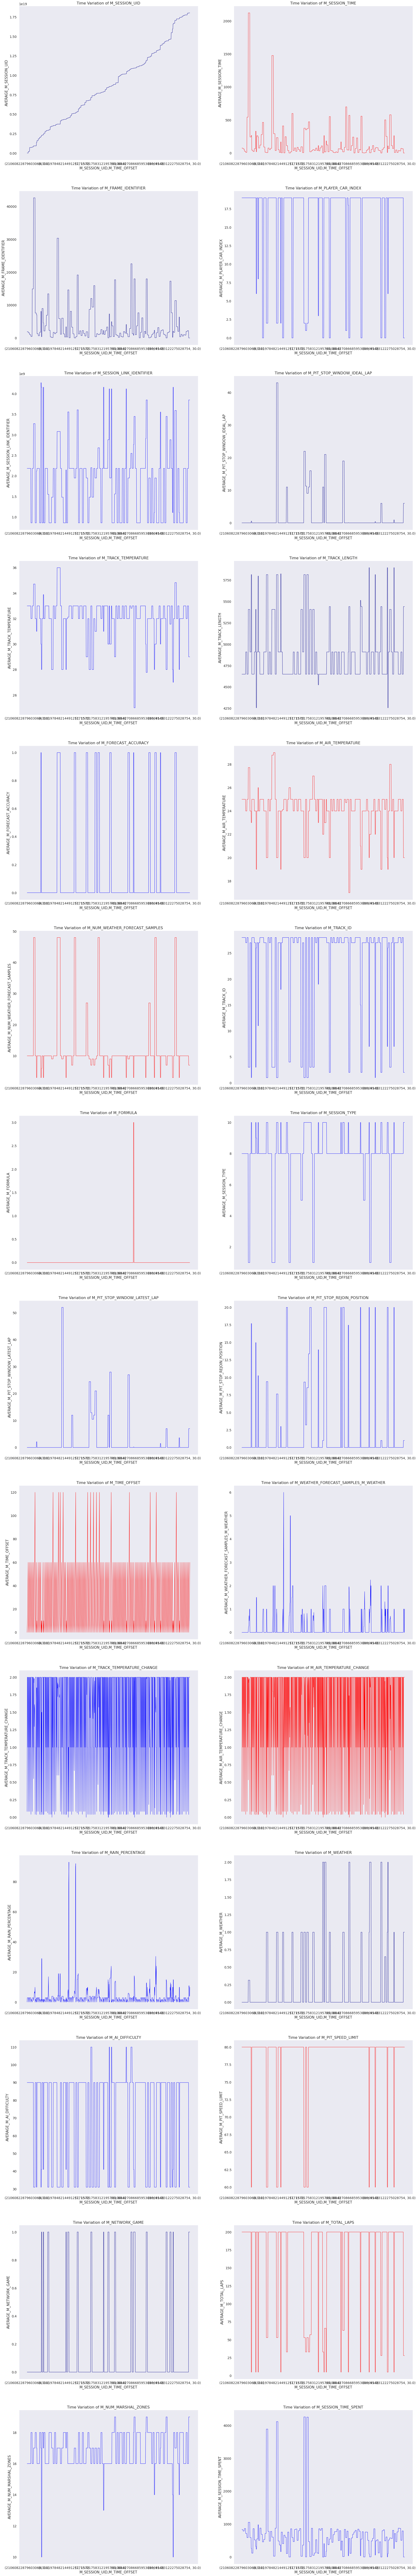

In [68]:
count = 1
colour = ['blue','red','darkblue']
plt.figure(figsize=(30,200))
for col in de.columns:
    plt.subplot(14,2,count)
    dd[col].mean().plot(lw=1,color=np.random.choice(colour))
    plt.ylabel('AVERAGE_{}'.format(col)) 
    plt.title('Time Variation of {}'.format(col), fontsize = 16)
    #plt.legend(loc='center')
    plt.grid(False)
    if count<36:
        count+=1

<br>As our ultimate goal is to <b> build models that learn the evolution of in-game weather conditions over time</b> features that do not show reasonable variation over time, as revealed by the plots, will be less useful for our models.

Before dropping these features, let's transform the data by regrouping by session UID, we then sort by session time and time offset. In other words, we want the data to represent the time variation, session by session.

In [69]:
start = de.copy()
frames = []
for uid in np.sort(start['M_SESSION_UID'].unique()):
    _ = start[start['M_SESSION_UID']==uid]
    _.sort_values(by=['M_SESSION_TIME','M_TIME_OFFSET'], inplace=True,
               ascending = [True, True])
    frames.append(_)
dtime = pd.concat(frames)
dtime.shape

(1957078, 28)

In [70]:
dtime.head()

M_SESSION_UID  M_SESSION_TIME  M_FRAME_IDENTIFIER  \
1530935  21060822879603068           28.86                 624   
1530938  21060822879603068           28.86                 624   
1530945  21060822879603068           28.86                 624   
1530946  21060822879603068           28.86                 624   
1530947  21060822879603068           28.86                 624   

         M_PLAYER_CAR_INDEX  M_SESSION_LINK_IDENTIFIER  \
1530935                  19                 2184232491   
1530938                  19                 2184232491   
1530945                  19                 2184232491   
1530946                  19                 2184232491   
1530947                  19                 2184232491   

         M_PIT_STOP_WINDOW_IDEAL_LAP  M_TRACK_TEMPERATURE  M_TRACK_LENGTH  \
1530935                            0                   33            4650   
1530938                            0                   33            4650   
1530945                            0                   33            4650   
1530946                            0                   33            4650   
1530947                            0                   33            4650   

         M_FORECAST_ACCURACY  M_AIR_TEMPERATURE  \
1530935                    0                 25   
1530938                    0                 25   
1530945                    0                 25   
1530946                    0                 25   
1530947                    0                 25   

         M_NUM_WEATHER_FORECAST_SAMPLES  M_TRACK_ID  M_FORMULA  \
1530935                              10          28          0   
1530938                              10          28          0   
1530945                              10          28          0   
1530946                              10          28          0   
1530947                              10          28          0   

         M_SESSION_TYPE  M_PIT_STOP_WINDOW_LATEST_LAP  \
1530935               8                             0   
1530938               8                             0   
1530945               8                             0   
1530946               8                             0   
1530947               8                             0   

         M_PIT_STOP_REJOIN_POSITION  M_TIME_OFFSET  \
1530935                           0            0.0   
1530938                           0            0.0   
1530945                           0            0.0   
1530946                           0            0.0   
1530947                           0            0.0   

         M_WEATHER_FORECAST_SAMPLES_M_WEATHER  M_TRACK_TEMPERATURE_CHANGE  \
1530935                                   0.0                         2.0   
1530938                                   0.0                         2.0   
1530945                                   0.0                         0.0   
1530946                                   0.0                         0.0   
1530947                                   0.0                         0.0   

         M_AIR_TEMPERATURE_CHANGE  M_RAIN_PERCENTAGE  M_WEATHER  \
1530935                       2.0                3.0          0   
1530938                       2.0                3.0          0   
1530945                       0.0                0.0          0   
1530946                       0.0                0.0          0   
1530947                       0.0                0.0          0   

         M_AI_DIFFICULTY  M_PIT_SPEED_LIMIT  M_NETWORK_GAME  M_TOTAL_LAPS  \
1530935               90                 80             0.0         200.0   
1530938               90                 80             0.0         200.0   
1530945               90                 80             0.0         200.0   
1530946               90                 80             0.0         200.0   
1530947               90                 80             0.0         200.0   

         M_NUM_MARSHAL_ZONES  M_SESSION_TIME_SPENT  
1530935                 16.0                   788

In the preceeding plots, we explored the internal variations in the data grouped by session UID and time offset. Now that we have reordered our data, we will visualise the variations in the grouping by time offset alone and inspect what the seasonality looks like across features.

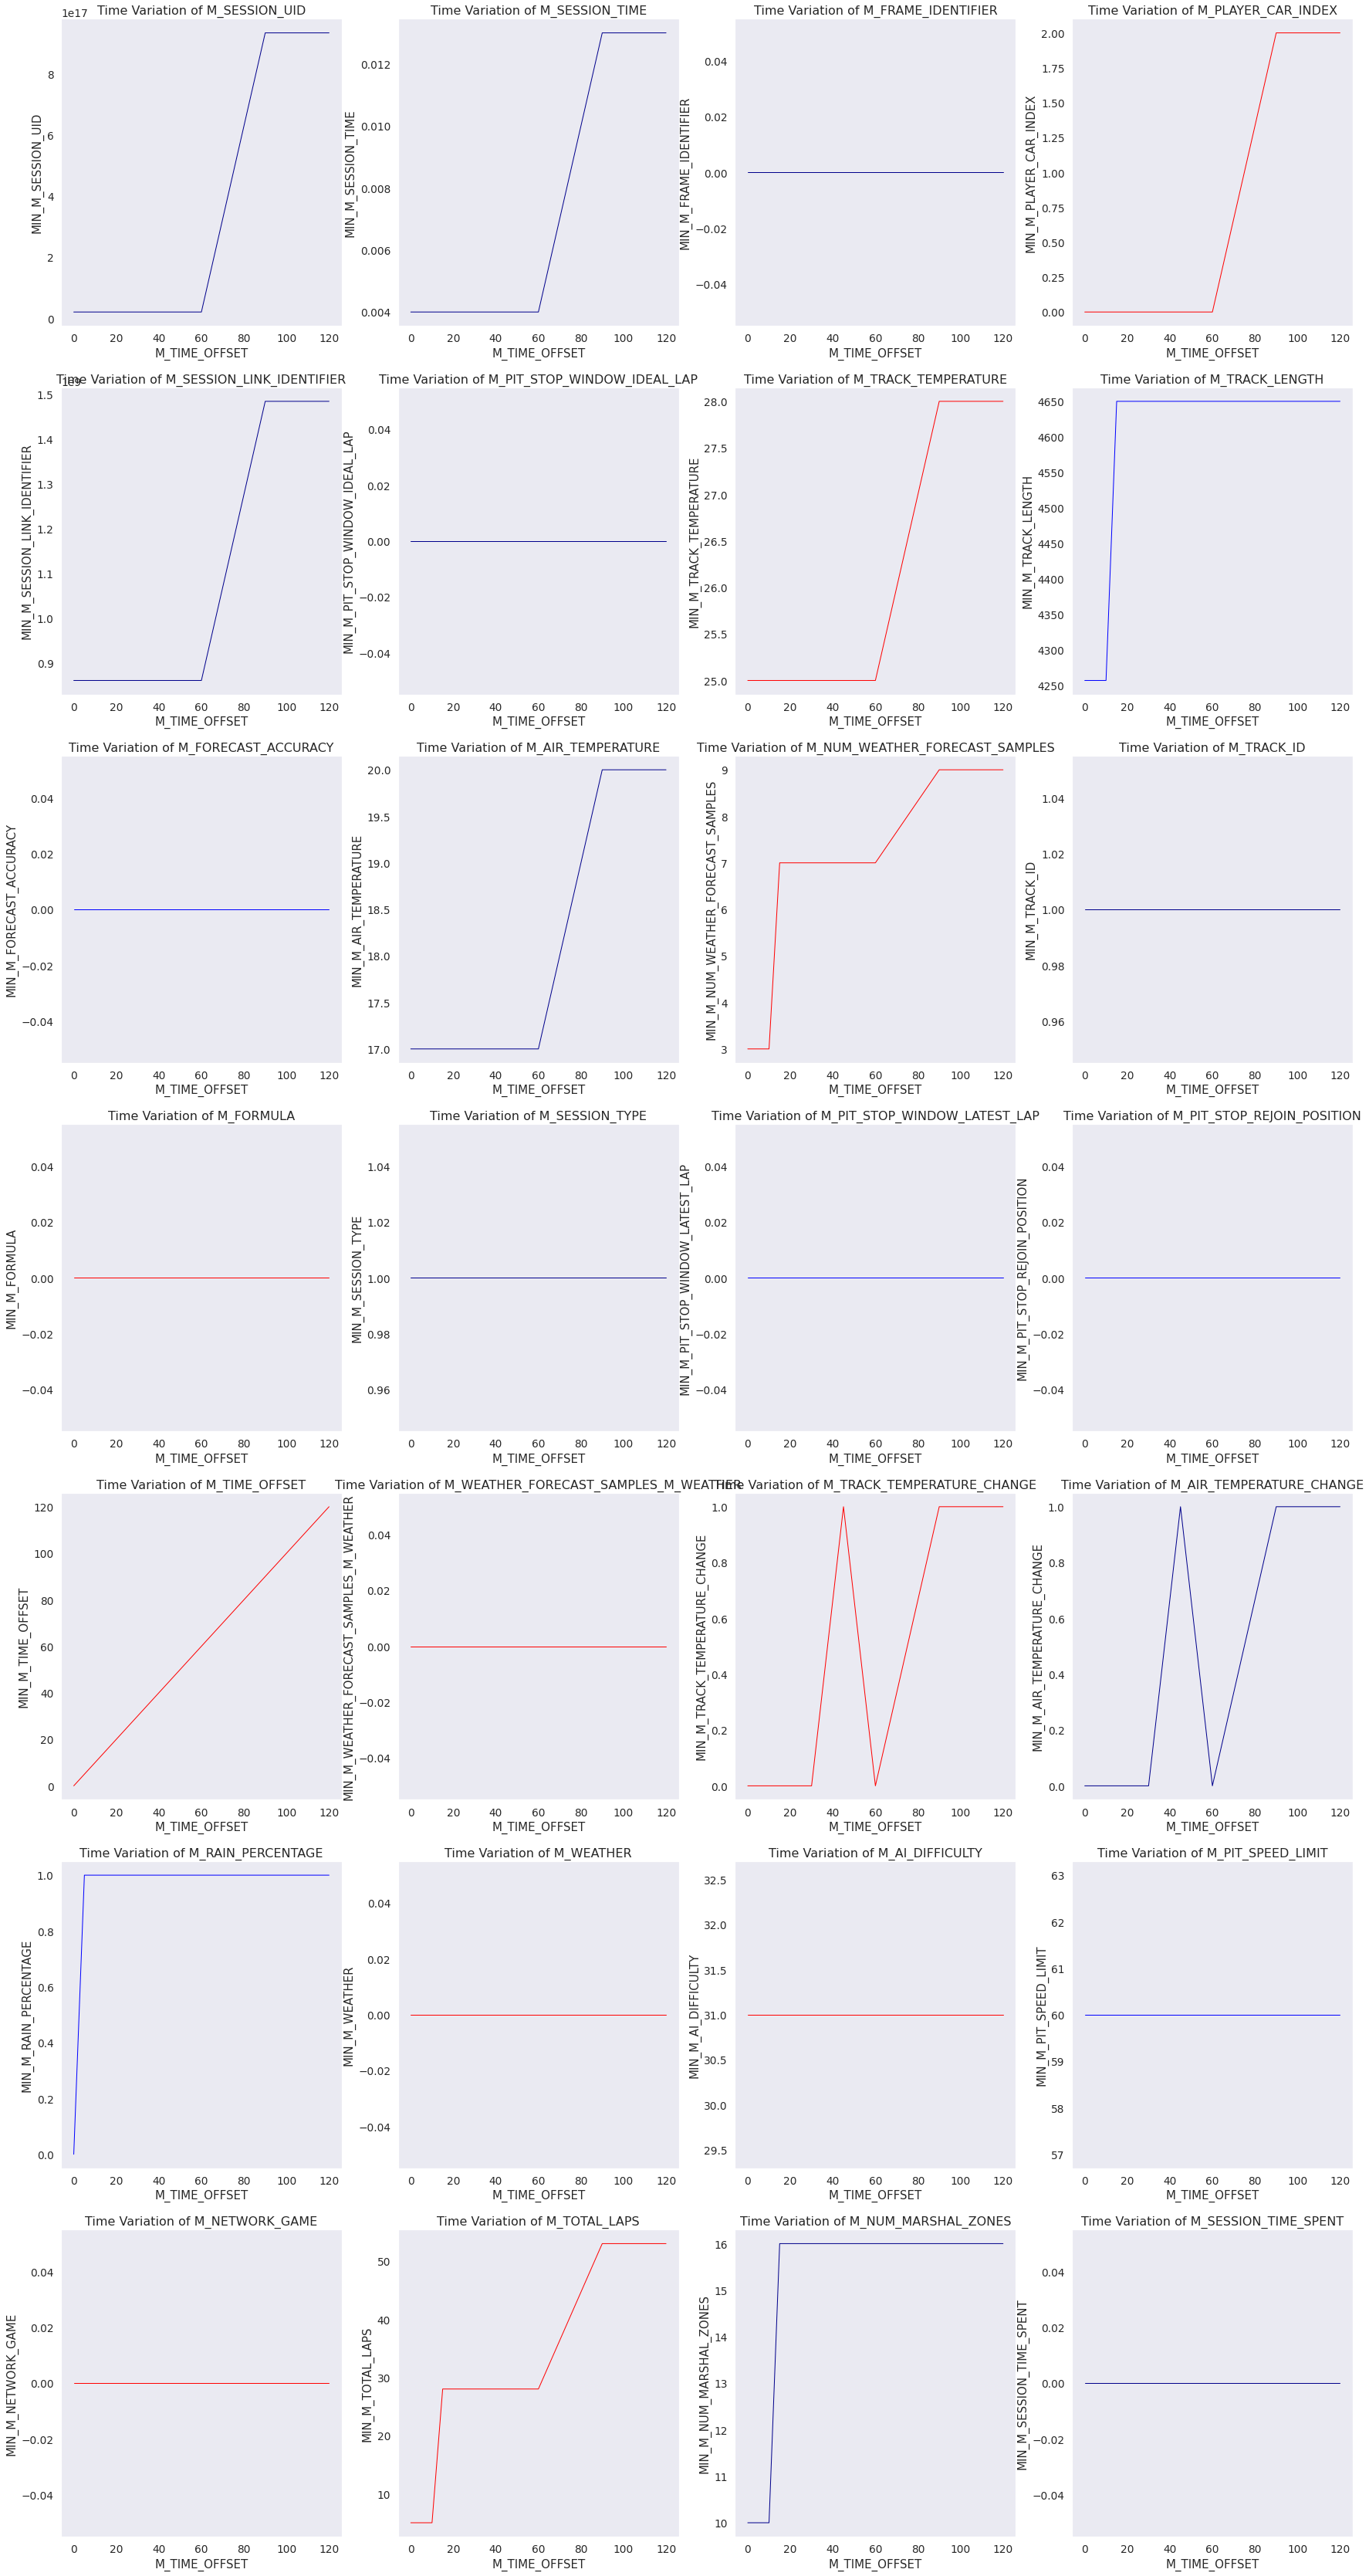

In [71]:
count = 1
colour = ['blue','red','darkblue']
plt.figure(figsize=(30,60))
for col in dtime.columns.unique():
    plt.subplot(7,4,count)
    dtime.groupby('M_TIME_OFFSET')[col].min().plot(lw=1,color=np.random.choice(colour))
    plt.ylabel('MIN_{}'.format(col)) 
    plt.title('Time Variation of {}'.format(col), fontsize = 16)
    #plt.legend(loc='center')
    plt.grid(False)
    if count<28:
        count+=1

<br>The distributions would have looked different from this had it been we had plotted with the mean since this would have made it more seasonal. However, max or min are more realistic in this case as they allow us detect features that have constant max or min across time offsets. However, it is not clear from this plot whether the features that show no variation across time offsets in this plot are binary.

<b>At a glance, we observe the following features are constant in time at min and max:</b><br>
- frame ID
- pit stop window ideal lap
- track id
- formula
- session type
- pit stop window latest lap
- forecast accuracy
- pit stop rejoin position
- track temperature change
- weather forecast sample
- AI difficulty
- pit speed limit
- network game

Now, we will isolate these features and study their variations ***with respect to weather*** after 5, 10, 15, 30 and 60 minutes. <b>Before this, we will perform our final row reduction by removing rows with time offset 0, as there's been no indication that these provide any predictive value</b>. This is justfied by the visualisations above which show us constant observations across this time offset value.

In [72]:
print('Shape before dropping -->', dtime.shape)
afterdrop = dtime.drop(dtime[dtime['M_TIME_OFFSET']==0.].index)
print('Shape after dropping -->', afterdrop.shape)

Shape before dropping --> (1957078, 28)
Shape after dropping --> (534055, 28)


In [73]:
isolated = afterdrop[[
            'M_SESSION_UID',
            'M_SESSION_TYPE',
            'M_TIME_OFFSET',
            'M_FRAME_IDENTIFIER',
            'M_PIT_STOP_WINDOW_IDEAL_LAP',
            'M_TRACK_ID',
            'M_FORMULA',
            'M_PIT_STOP_WINDOW_LATEST_LAP',
            'M_PIT_STOP_REJOIN_POSITION',
            'M_TRACK_TEMPERATURE_CHANGE',
            'M_AI_DIFFICULTY',
            'M_PIT_SPEED_LIMIT',
            'M_NETWORK_GAME',
            'M_FORECAST_ACCURACY',
            'M_WEATHER_FORECAST_SAMPLES_M_WEATHER',
            'M_WEATHER'
            ]]

In [74]:
isolated = isolated[(isolated['M_TIME_OFFSET'] <= 60) & (isolated['M_TIME_OFFSET'] > 0)]
isolated['M_TIME_OFFSET'].unique()

array([ 5., 10., 15., 30., 45., 60.])

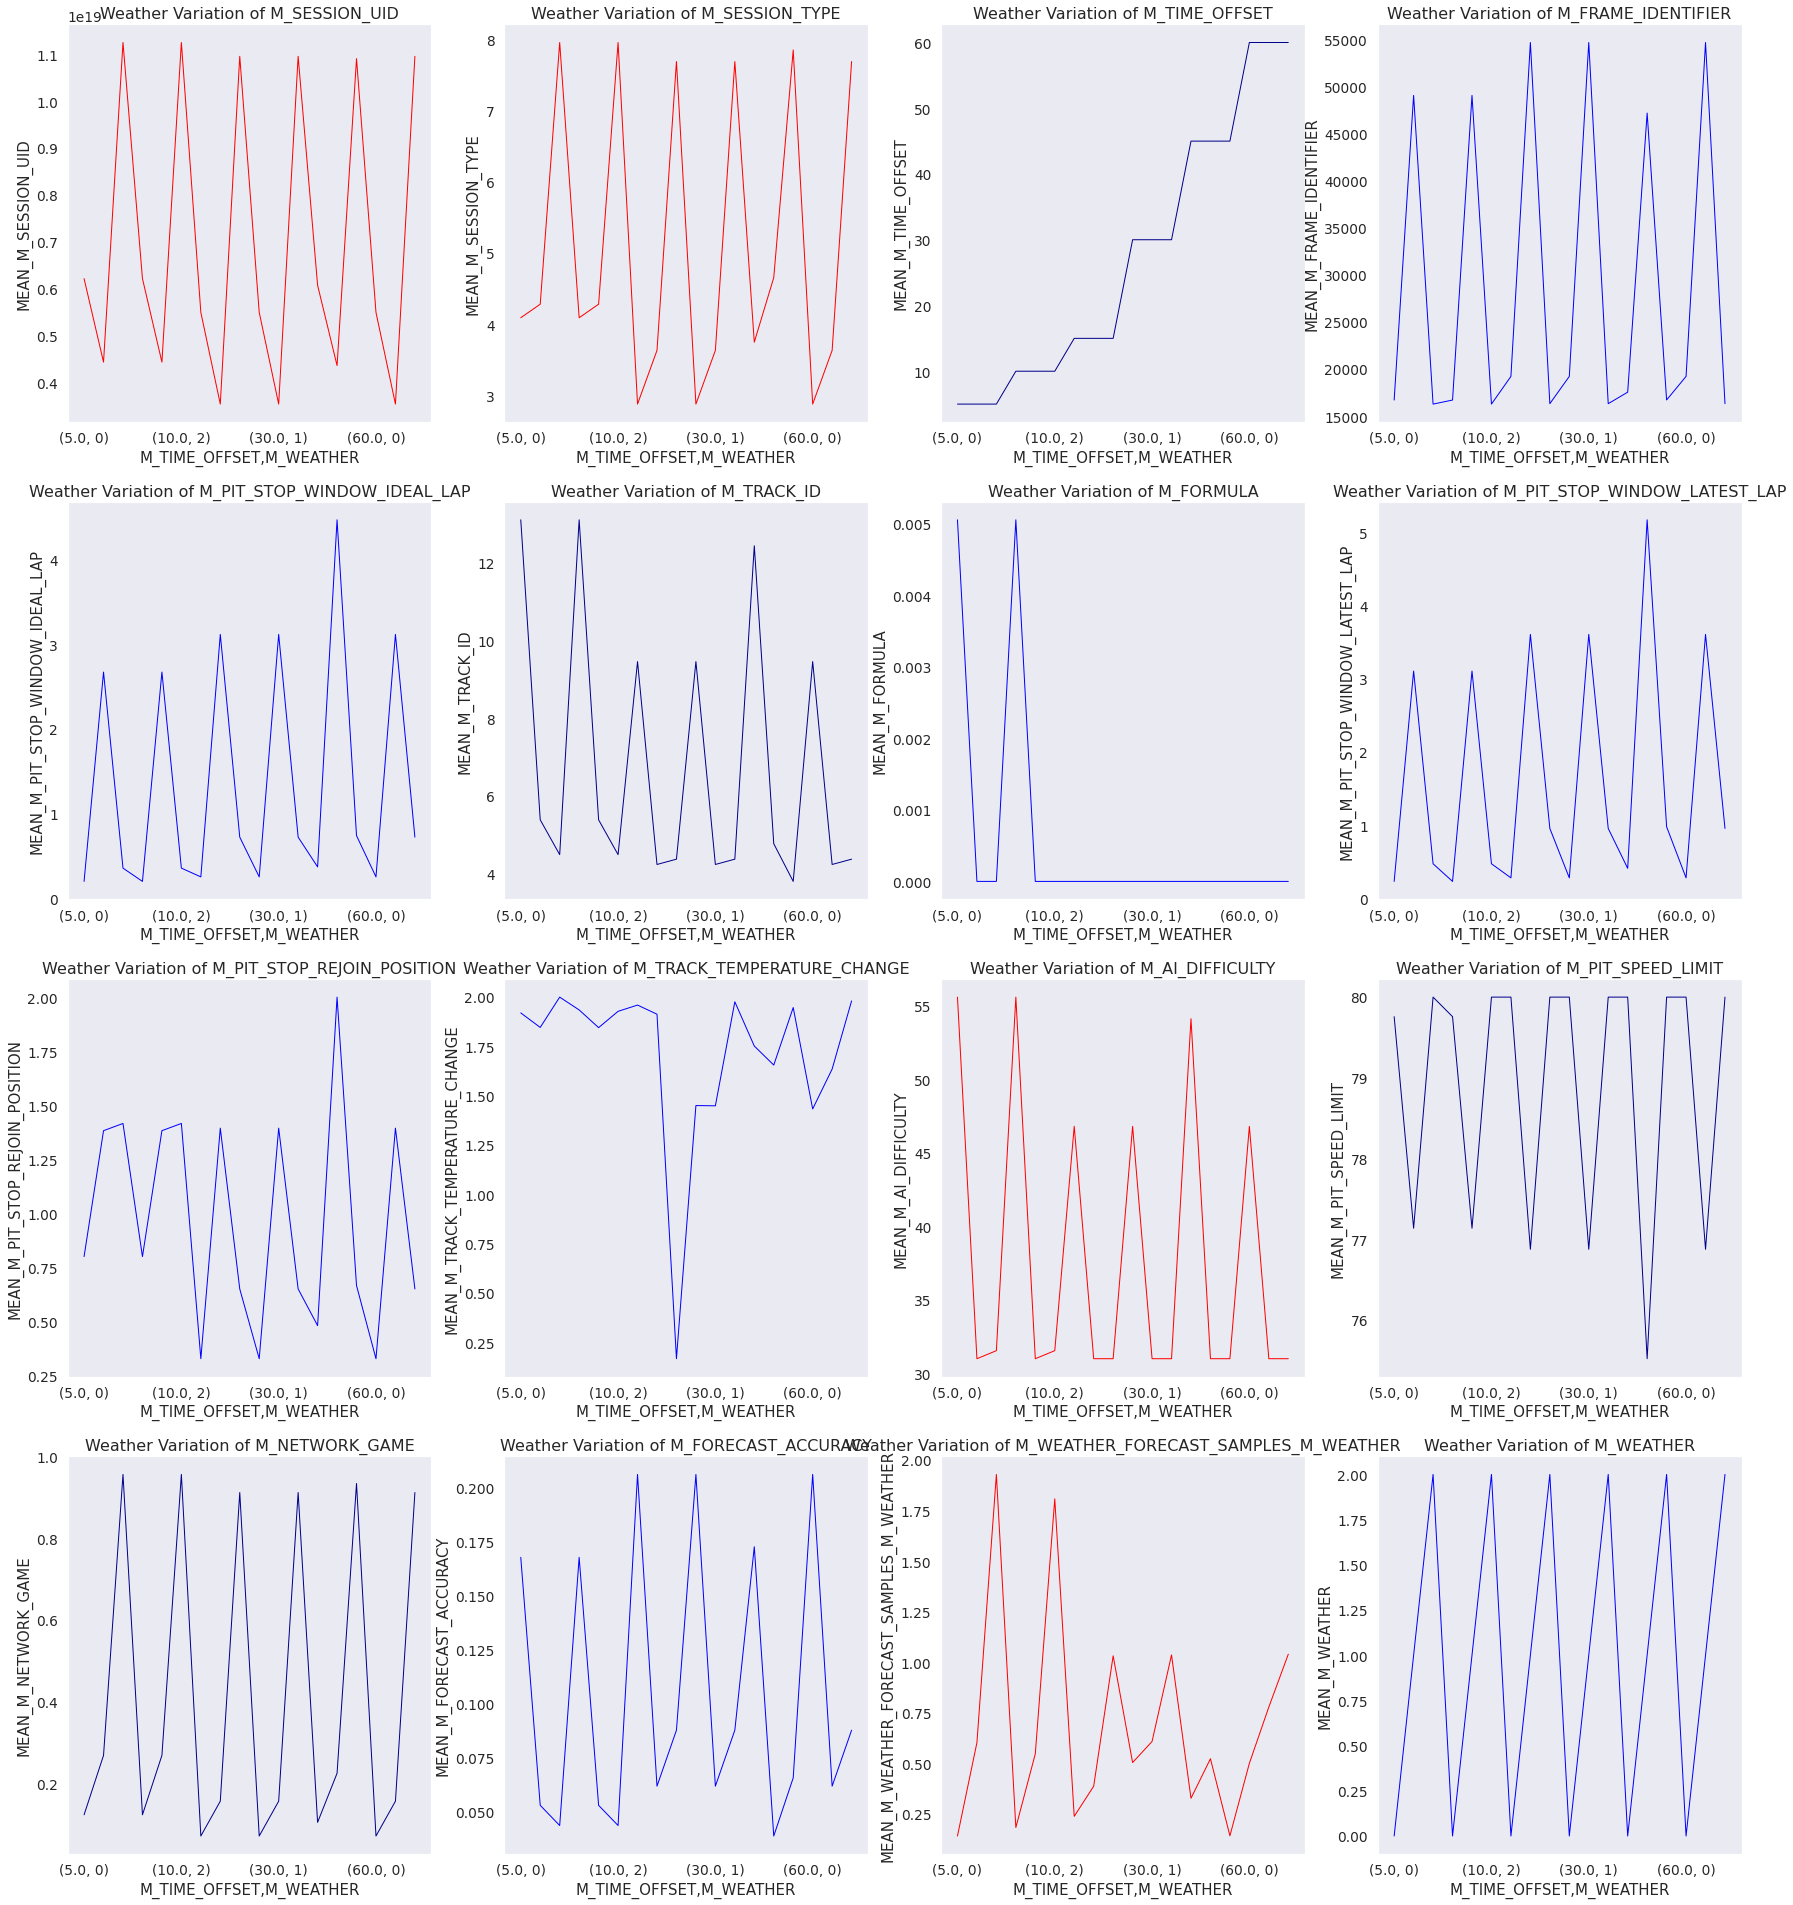

In [75]:
count = 1
colour = ['blue','red','darkblue']
plt.figure(figsize=(30,60))
for col in isolated.columns:
    plt.subplot(7,4,count)
    isolated.groupby(['M_TIME_OFFSET','M_WEATHER'])[col].mean().plot(lw=1,color=np.random.choice(colour)) #plotting by mode, implemented by finding the highest value count
    plt.ylabel('MEAN_{}'.format(col)) 
    plt.title('Weather Variation of {}'.format(col), fontsize = 16)
    #plt.legend(loc='center')
    plt.grid(False)
    if count<16:
        count+=1

<br> We are being careful at this point not to second guess dropping of unwanted features, as many of these features, despite demonstrating no variation in the time offsets, have been shown in our earliest observations to vary session ID by session ID. We will therefore leave the rest of the preprocessing to the next section on feature selection.

In [76]:
#print('Downloading data...')
#afterdrop.to_csv('eda_output.csv')
#print('Done!')

<br>
<h4><b>2. Feature Selection Experimentations</b></h4>

We begin this section by obtaining a feature importance ranking. Then we perform feature selection using two algorithms side by side: first with **generic univariate select**, and second with **recursive feature elimination**. We compare the results from both procedures and immdediately eliminate those features that were not selected by both.

**(a) Ranking Feature Importance**

We will implement Kepler Variable Importance to rank feature importance for each of our targets:

In [77]:
target1 = afterdrop['M_WEATHER']
target2 = afterdrop['M_RAIN_PERCENTAGE']
features1 = afterdrop.drop('M_WEATHER', axis=1)
features2 = afterdrop.drop('M_RAIN_PERCENTAGE', axis=1)
features1.shape

(534055, 27)

In [78]:
features2.shape

(534055, 27)

<i> **Rank feature importance for Target 1** </i>🎯 

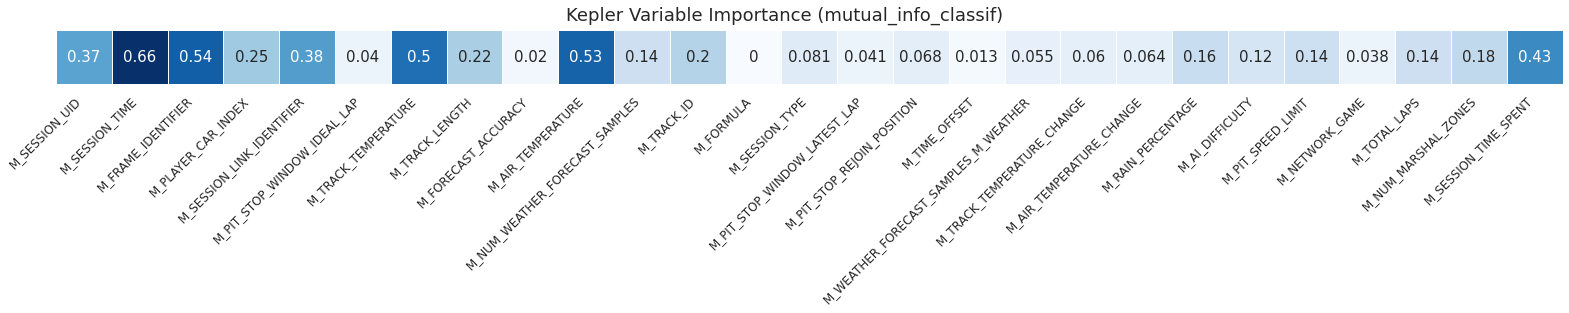

In [79]:
kepler_mutual_information = mutual_info_classif(features1, target1)

plt.subplots(1, figsize=(27, 1))
sns.heatmap(kepler_mutual_information[:, np.newaxis].T, cmap='Blues', cbar=False, linewidths=1, annot=True)
plt.yticks([], [])
plt.gca().set_xticklabels(features1.columns[0:], rotation=45, ha='right', fontsize=12)
plt.suptitle("Kepler Variable Importance (mutual_info_classif)", fontsize=18, y=1.2)
plt.gcf().subplots_adjust(wspace=0.2)
pass

<i> **Rank feature importance for Target 2** </i> 🎯 

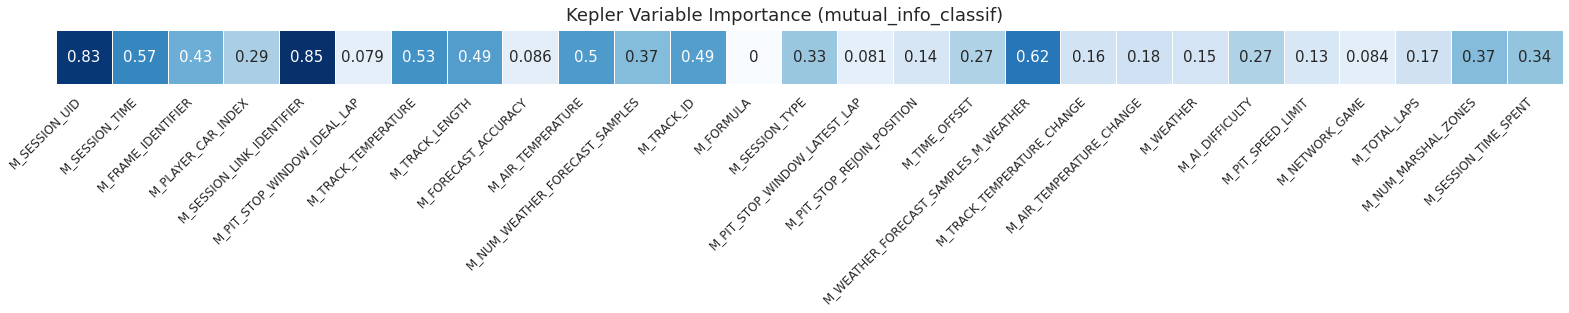

In [80]:
kepler_mutual_information_2 = mutual_info_classif(features2, target2)

plt.subplots(1, figsize=(27, 1))
sns.heatmap(kepler_mutual_information_2[:, np.newaxis].T, cmap='Blues', cbar=False, linewidths=1, annot=True)
plt.yticks([], [])
plt.gca().set_xticklabels(features2.columns[0:], rotation=45, ha='right', fontsize=12)
plt.suptitle("Kepler Variable Importance (mutual_info_classif)", fontsize=18, y=1.2)
plt.gcf().subplots_adjust(wspace=0.2)
pass

<br> **(b) Feature Selection with Kepler Variable Importance (Generic Univariate Select)**

In [81]:
def feature_selection_table(selected, original_features):
    """
    Display a table that indicates whether or not a feature was selected
    """
    status = []
    index = []
    for col in original_features:
        if col in selected:
            index.append(col)
            status.append('Selected')
        else:
            index.append(col)
            status.append('Not Selected')
            
    _selection_table = pd.DataFrame(status, columns = ['Selection Status'], index = original_features)
    
    print('Number of features selected:', len(selected))
    print('Number of features left out:', len([col for col in original_features if col not in selected]))
    
    return _selection_table

<i> **Select features for target 1** </i>

In [82]:
#GenericUnivariateSelect(score_func=lambda X, y: X.mean(axis=0), mode='percentile', param=50)
trans = GenericUnivariateSelect(score_func=mutual_info_classif, mode = 'percentile', param=50)
kepler_X_trans = trans.fit_transform(features1, target1)

In [83]:
columns_retained_Select = features1.iloc[:, :].columns[trans.get_support()].values
features_selected_1 = pd.DataFrame(kepler_X_trans, columns=columns_retained_Select)
features_selected_1.shape

(534055, 13)

In [84]:
Kepler_Target_1 = features_selected_1.columns
feature_selection_table(Kepler_Target_1, features1.columns)

Number of features selected: 13
Number of features left out: 14


Selection Status
M_SESSION_UID                                Selected
M_SESSION_TIME                               Selected
M_FRAME_IDENTIFIER                           Selected
M_PLAYER_CAR_INDEX                           Selected
M_SESSION_LINK_IDENTIFIER                    Selected
M_PIT_STOP_WINDOW_IDEAL_LAP              Not Selected
M_TRACK_TEMPERATURE                          Selected
M_TRACK_LENGTH                               Selected
M_FORECAST_ACCURACY                      Not Selected
M_AIR_TEMPERATURE                            Selected
M_NUM_WEATHER_FORECAST_SAMPLES               Selected
M_TRACK_ID                                   Selected
M_FORMULA                                Not Selected
M_SESSION_TYPE                           Not Selected
M_PIT_STOP_WINDOW_LATEST_LAP             Not Selected
M_PIT_STOP_REJOIN_POSITION               Not Selected
M_TIME_OFFSET                            Not Selected
M_WEATHER_FORECAST_SAMPLES_M_WEATHER     Not Selected
M_TRACK_TEMPERATURE_CHANGE               Not Selected
M_AIR_TEMPERATURE_CHANGE                 Not Selected
M_RAIN_PERCENTAGE                            Selected
M_AI_DIFFICULTY                          Not Selected
M_PIT_SPEED_LIMIT                        Not Selected
M_NETWORK_GAME                           Not Selected
M_TOTAL_LAPS                             Not Selected
M_NUM_MARSHAL_ZONES                          Selected
M_SESSION_TIME_SPENT                         Selected

<i> **Select features for target 2** </i>

In [85]:
#GenericUnivariateSelect(score_func=lambda X, y: X.mean(axis=0), mode='percentile', param=50)
trans_2 = GenericUnivariateSelect(score_func=mutual_info_classif, mode = 'percentile', param=50)
kepler_X_trans_2 = trans_2.fit_transform(features2, target2)

In [86]:
columns_retained_Select_2 = features2.iloc[:, :].columns[trans.get_support()].values
features_selected_2 = pd.DataFrame(kepler_X_trans_2, columns=columns_retained_Select_2)
features_selected_2.shape

(534055, 13)

In [87]:
Kepler_Target_2 = features_selected_2.columns
feature_selection_table(Kepler_Target_2, features2.columns)

Number of features selected: 13
Number of features left out: 14


Selection Status
M_SESSION_UID                                Selected
M_SESSION_TIME                               Selected
M_FRAME_IDENTIFIER                           Selected
M_PLAYER_CAR_INDEX                           Selected
M_SESSION_LINK_IDENTIFIER                    Selected
M_PIT_STOP_WINDOW_IDEAL_LAP              Not Selected
M_TRACK_TEMPERATURE                          Selected
M_TRACK_LENGTH                               Selected
M_FORECAST_ACCURACY                      Not Selected
M_AIR_TEMPERATURE                            Selected
M_NUM_WEATHER_FORECAST_SAMPLES               Selected
M_TRACK_ID                                   Selected
M_FORMULA                                Not Selected
M_SESSION_TYPE                           Not Selected
M_PIT_STOP_WINDOW_LATEST_LAP             Not Selected
M_PIT_STOP_REJOIN_POSITION               Not Selected
M_TIME_OFFSET                            Not Selected
M_WEATHER_FORECAST_SAMPLES_M_WEATHER     Not Selected
M_TRACK_TEMPERATURE_CHANGE               Not Selected
M_AIR_TEMPERATURE_CHANGE                 Not Selected
M_WEATHER                                    Selected
M_AI_DIFFICULTY                          Not Selected
M_PIT_SPEED_LIMIT                        Not Selected
M_NETWORK_GAME                           Not Selected
M_TOTAL_LAPS                             Not Selected
M_NUM_MARSHAL_ZONES                          Selected
M_SESSION_TIME_SPENT                         Selected

<br>**(c) Feature Selection by Recursive Feature Elimination (RFE)**

<i> **Eliminate features for target 1** </i>

Since target 1 (weather) is a binary class label, we will implement RFE using the logistic regression algorithm

In [88]:
estimator_1 = LogisticRegression(solver='liblinear')
rfe_1 = RFE(estimator_1, n_features_to_select=13, step=1)
fit_1 = rfe_1.fit(features1, target1)
print("Num Features: %s" % (fit_1.n_features_))
print("Selected Features: %s" % (fit_1.support_))
print("Feature Ranking: %s" % (fit_1.ranking_))

#RFE_Target_2 = fit.get_feature_names_out(features2.columns)
#RFE_Target_2

Num Features: 13
Selected Features: [ True  True  True False  True False  True  True False  True  True False
 False False False False  True False False False False  True  True False
  True False  True]
Feature Ranking: [ 1  1  1  2  1 11  1  1 14  1  1  4 15  8 10 12  1  9  7  6  5  1  1 13
  1  3  1]


Now, we will use the following helper functions to generate an array of the names of features that were selected corresponding to the selection index position. This array will then be used to generate the dataframe that displays selected features.

In [89]:
def _check_feature_names_in(estimator, input_features=None):
    """Get output feature names for transformation.
    Parameters
    ----------
    input_features : array-like of str or None, default=None
        Input features.
        - If `input_features` is `None`, then `feature_names_in_` is
            used as feature names in. If `feature_names_in_` is not defined,
            then names are generated: `[x0, x1, ..., x(n_features_in_)]`.
        - If `input_features` is an array-like, then `input_features` must
            match `feature_names_in_` if `feature_names_in_` is defined.
    Returns
    -------
    feature_names_in : ndarray of str
        Feature names in.
    """

    feature_names_in_ = getattr(estimator, "feature_names_in_", None)
    n_features_in_ = getattr(estimator, "n_features_in_", None)

    if input_features is not None:
        input_features = np.asarray(input_features, dtype=object)
        if feature_names_in_ is not None and not np.array_equal(
            feature_names_in_, input_features
        ):
            raise ValueError("input_features is not equal to feature_names_in_")

        if n_features_in_ is not None and len(input_features) != n_features_in_:
            raise ValueError(
                "input_features should have length equal to number of "
                f"features ({n_features_in_}), got {len(input_features)}"
            )
        return input_features

    if feature_names_in_ is not None:
        return feature_names_in_

    # Generates feature names if `n_features_in_` is defined
    if n_features_in_ is None:
        raise ValueError("Unable to generate feature names without n_features_in_")

    return np.asarray([f"x{i}" for i in range(n_features_in_)], dtype=object)


def get_feature_names_out(estimator, input_features=None):
    """Mask feature names according to selected features.
    Parameters
    ----------
    input_features : array-like of str or None, default=None
        Input features.
        - If `input_features` is `None`, then `feature_names_in_` is
          used as feature names in. If `feature_names_in_` is not defined,
          then names are generated: `[x0, x1, ..., x(n_features_in_)]`.
        - If `input_features` is an array-like, then `input_features` must
          match `feature_names_in_` if `feature_names_in_` is defined.
    Returns
    -------
    feature_names_out : ndarray of str objects
        Transformed feature names.
    """
    input_features = _check_feature_names_in(estimator, input_features)
    return input_features[estimator.get_support()]

In [90]:
RFE_Target_1 = get_feature_names_out(fit_1, features1.columns)
RFE_Target_1 

array(['M_SESSION_UID', 'M_SESSION_TIME', 'M_FRAME_IDENTIFIER',
       'M_SESSION_LINK_IDENTIFIER', 'M_TRACK_TEMPERATURE',
       'M_TRACK_LENGTH', 'M_AIR_TEMPERATURE',
       'M_NUM_WEATHER_FORECAST_SAMPLES', 'M_TIME_OFFSET',
       'M_AI_DIFFICULTY', 'M_PIT_SPEED_LIMIT', 'M_TOTAL_LAPS',
       'M_SESSION_TIME_SPENT'], dtype=object)

In [91]:
feature_selection_table(RFE_Target_1, features1.columns)

Number of features selected: 13
Number of features left out: 14


Selection Status
M_SESSION_UID                                Selected
M_SESSION_TIME                               Selected
M_FRAME_IDENTIFIER                           Selected
M_PLAYER_CAR_INDEX                       Not Selected
M_SESSION_LINK_IDENTIFIER                    Selected
M_PIT_STOP_WINDOW_IDEAL_LAP              Not Selected
M_TRACK_TEMPERATURE                          Selected
M_TRACK_LENGTH                               Selected
M_FORECAST_ACCURACY                      Not Selected
M_AIR_TEMPERATURE                            Selected
M_NUM_WEATHER_FORECAST_SAMPLES               Selected
M_TRACK_ID                               Not Selected
M_FORMULA                                Not Selected
M_SESSION_TYPE                           Not Selected
M_PIT_STOP_WINDOW_LATEST_LAP             Not Selected
M_PIT_STOP_REJOIN_POSITION               Not Selected
M_TIME_OFFSET                                Selected
M_WEATHER_FORECAST_SAMPLES_M_WEATHER     Not Selected
M_TRACK_TEMPERATURE_CHANGE               Not Selected
M_AIR_TEMPERATURE_CHANGE                 Not Selected
M_RAIN_PERCENTAGE                        Not Selected
M_AI_DIFFICULTY                              Selected
M_PIT_SPEED_LIMIT                            Selected
M_NETWORK_GAME                           Not Selected
M_TOTAL_LAPS                                 Selected
M_NUM_MARSHAL_ZONES                      Not Selected
M_SESSION_TIME_SPENT                         Selected

<br><i> **Eliminate features for target 2** </i>

Since target 2 (percentage rain) is a continuous target, we will implement RFE using a decision tree regressor

In [92]:
estimator_2 = DecisionTreeRegressor()
rfe = RFE(estimator_2, n_features_to_select=13, step=1)
fit = rfe.fit(features2, target2)

print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))

#RFE_Target_2 = fit.get_feature_names_out(features2.columns)
#RFE_Target_2

Num Features: 13
Selected Features: [ True False  True False  True False  True False False  True False  True
 False False False False  True  True  True  True  True False False False
 False  True  True]
Feature Ranking: [ 1  2  1  6  1 13  1  3  5  1  4  1 14  8 12  7  1  1  1  1  1 11 15 10
  9  1  1]


In [93]:
RFE_Target_2 = get_feature_names_out(fit, features2.columns)
RFE_Target_2

array(['M_SESSION_UID', 'M_FRAME_IDENTIFIER', 'M_SESSION_LINK_IDENTIFIER',
       'M_TRACK_TEMPERATURE', 'M_AIR_TEMPERATURE', 'M_TRACK_ID',
       'M_TIME_OFFSET', 'M_WEATHER_FORECAST_SAMPLES_M_WEATHER',
       'M_TRACK_TEMPERATURE_CHANGE', 'M_AIR_TEMPERATURE_CHANGE',
       'M_WEATHER', 'M_NUM_MARSHAL_ZONES', 'M_SESSION_TIME_SPENT'],
      dtype=object)

In [94]:
feature_selection_table(RFE_Target_2, features2.columns)

Number of features selected: 13
Number of features left out: 14


Selection Status
M_SESSION_UID                                Selected
M_SESSION_TIME                           Not Selected
M_FRAME_IDENTIFIER                           Selected
M_PLAYER_CAR_INDEX                       Not Selected
M_SESSION_LINK_IDENTIFIER                    Selected
M_PIT_STOP_WINDOW_IDEAL_LAP              Not Selected
M_TRACK_TEMPERATURE                          Selected
M_TRACK_LENGTH                           Not Selected
M_FORECAST_ACCURACY                      Not Selected
M_AIR_TEMPERATURE                            Selected
M_NUM_WEATHER_FORECAST_SAMPLES           Not Selected
M_TRACK_ID                                   Selected
M_FORMULA                                Not Selected
M_SESSION_TYPE                           Not Selected
M_PIT_STOP_WINDOW_LATEST_LAP             Not Selected
M_PIT_STOP_REJOIN_POSITION               Not Selected
M_TIME_OFFSET                                Selected
M_WEATHER_FORECAST_SAMPLES_M_WEATHER         Selected
M_TRACK_TEMPERATURE_CHANGE                   Selected
M_AIR_TEMPERATURE_CHANGE                     Selected
M_WEATHER                                    Selected
M_AI_DIFFICULTY                          Not Selected
M_PIT_SPEED_LIMIT                        Not Selected
M_NETWORK_GAME                           Not Selected
M_TOTAL_LAPS                             Not Selected
M_NUM_MARSHAL_ZONES                          Selected
M_SESSION_TIME_SPENT                         Selected

**Now we will create a function that combines the results from RFE and those from Kepler's, which will allow us compare between both**

In [95]:
cols_classif = ['Kepler Target 1 Results', 'RFE Target 1 Results']
results_classif = [Kepler_Target_1, RFE_Target_1]
features_classif = [features1.columns, features1.columns]

cols_reg = ['Kepler Target 2 Results', 'RFE Target 2 Results']
results_reg = [Kepler_Target_2, RFE_Target_2]
features_reg = [features2.columns, features2.columns]

In [96]:
def new_selection_table(selection_lists, features_list, cols):
    """
    Display a table combining all the feature selection results for the two targets
    """
    #cols = []
    #for j in range(len(selection_lists)):
    #    cols.append([i for i, a in locals().items() if a == '{}'.format(selection_lists[j])])
    
    tables_list = [feature_selection_table(i,j) for i,j in zip(selection_lists, features_list)]
    _selection_table = pd.DataFrame(columns = cols, index = tables_list[0].index)
    
    for table, algorithm in zip(tables_list, cols):
        _selection_table[algorithm] = table
    
    return _selection_table

In [97]:
selection_results_classif = new_selection_table(results_classif, features_classif, cols_classif)
selection_results_classif

Number of features selected: 13
Number of features left out: 14
Number of features selected: 13
Number of features left out: 14


Kepler Target 1 Results  \
M_SESSION_UID                                       Selected   
M_SESSION_TIME                                      Selected   
M_FRAME_IDENTIFIER                                  Selected   
M_PLAYER_CAR_INDEX                                  Selected   
M_SESSION_LINK_IDENTIFIER                           Selected   
M_PIT_STOP_WINDOW_IDEAL_LAP                     Not Selected   
M_TRACK_TEMPERATURE                                 Selected   
M_TRACK_LENGTH                                      Selected   
M_FORECAST_ACCURACY                             Not Selected   
M_AIR_TEMPERATURE                                   Selected   
M_NUM_WEATHER_FORECAST_SAMPLES                      Selected   
M_TRACK_ID                                          Selected   
M_FORMULA                                       Not Selected   
M_SESSION_TYPE                                  Not Selected   
M_PIT_STOP_WINDOW_LATEST_LAP                    Not Selected   
M_PIT_STOP_REJOIN_POSITION                      Not Selected   
M_TIME_OFFSET                                   Not Selected   
M_WEATHER_FORECAST_SAMPLES_M_WEATHER            Not Selected   
M_TRACK_TEMPERATURE_CHANGE                      Not Selected   
M_AIR_TEMPERATURE_CHANGE                        Not Selected   
M_RAIN_PERCENTAGE                                   Selected   
M_AI_DIFFICULTY                                 Not Selected   
M_PIT_SPEED_LIMIT                               Not Selected   
M_NETWORK_GAME                                  Not Selected   
M_TOTAL_LAPS                                    Not Selected   
M_NUM_MARSHAL_ZONES                                 Selected   
M_SESSION_TIME_SPENT                                Selected   

                                     RFE Target 1 Results  
M_SESSION_UID                                    Selected  
M_SESSION_TIME                                   Selected  
M_FRAME_IDENTIFIER                               Selected  
M_PLAYER_CAR_INDEX                           Not Selected  
M_SESSION_LINK_IDENTIFIER                        Selected  
M_PIT_STOP_WINDOW_IDEAL_LAP                  Not Selected  
M_TRACK_TEMPERATURE                              Selected  
M_TRACK_LENGTH                                   Selected  
M_FORECAST_ACCURACY                          Not Selected  
M_AIR_TEMPERATURE                                Selected  
M_NUM_WEATHER_FORECAST_SAMPLES                   Selected  
M_TRACK_ID                                   Not Selected  
M_FORMULA                                    Not Selected  
M_SESSION_TYPE                               Not Selected  
M_PIT_STOP_WINDOW_LATEST_LAP                 Not Selected  
M_PIT_STOP_REJOIN_POSITION                   Not Selected  
M_TIME_OFFSET                                    Selected  
M_WEATHER_FORECAST_SAMPLES_M_WEATHER         Not Selected  
M_TRACK_TEMPERATURE_CHANGE                   Not Selected  
M_AIR_TEMPERATURE_CHANGE                     Not Selected  
M_RAIN_PERCENTAGE                            Not Selected  
M_AI_DIFFICULTY                                  Selected  
M_PIT_SPEED_LIMIT                                Selected  
M_NETWORK_GAME                               Not Selected  
M_TOTAL_LAPS                                     Selected  
M_NUM_MARSHAL_ZONES                          Not Selected  
M_SESSION_TIME_SPENT                             Selected

In [98]:
selection_results_reg = new_selection_table(results_reg, features_reg, cols_reg)
selection_results_reg

Number of features selected: 13
Number of features left out: 14
Number of features selected: 13
Number of features left out: 14


Kepler Target 2 Results  \
M_SESSION_UID                                       Selected   
M_SESSION_TIME                                      Selected   
M_FRAME_IDENTIFIER                                  Selected   
M_PLAYER_CAR_INDEX                                  Selected   
M_SESSION_LINK_IDENTIFIER                           Selected   
M_PIT_STOP_WINDOW_IDEAL_LAP                     Not Selected   
M_TRACK_TEMPERATURE                                 Selected   
M_TRACK_LENGTH                                      Selected   
M_FORECAST_ACCURACY                             Not Selected   
M_AIR_TEMPERATURE                                   Selected   
M_NUM_WEATHER_FORECAST_SAMPLES                      Selected   
M_TRACK_ID                                          Selected   
M_FORMULA                                       Not Selected   
M_SESSION_TYPE                                  Not Selected   
M_PIT_STOP_WINDOW_LATEST_LAP                    Not Selected   
M_PIT_STOP_REJOIN_POSITION                      Not Selected   
M_TIME_OFFSET                                   Not Selected   
M_WEATHER_FORECAST_SAMPLES_M_WEATHER            Not Selected   
M_TRACK_TEMPERATURE_CHANGE                      Not Selected   
M_AIR_TEMPERATURE_CHANGE                        Not Selected   
M_WEATHER                                           Selected   
M_AI_DIFFICULTY                                 Not Selected   
M_PIT_SPEED_LIMIT                               Not Selected   
M_NETWORK_GAME                                  Not Selected   
M_TOTAL_LAPS                                    Not Selected   
M_NUM_MARSHAL_ZONES                                 Selected   
M_SESSION_TIME_SPENT                                Selected   

                                     RFE Target 2 Results  
M_SESSION_UID                                    Selected  
M_SESSION_TIME                               Not Selected  
M_FRAME_IDENTIFIER                               Selected  
M_PLAYER_CAR_INDEX                           Not Selected  
M_SESSION_LINK_IDENTIFIER                        Selected  
M_PIT_STOP_WINDOW_IDEAL_LAP                  Not Selected  
M_TRACK_TEMPERATURE                              Selected  
M_TRACK_LENGTH                               Not Selected  
M_FORECAST_ACCURACY                          Not Selected  
M_AIR_TEMPERATURE                                Selected  
M_NUM_WEATHER_FORECAST_SAMPLES               Not Selected  
M_TRACK_ID                                       Selected  
M_FORMULA                                    Not Selected  
M_SESSION_TYPE                               Not Selected  
M_PIT_STOP_WINDOW_LATEST_LAP                 Not Selected  
M_PIT_STOP_REJOIN_POSITION                   Not Selected  
M_TIME_OFFSET                                    Selected  
M_WEATHER_FORECAST_SAMPLES_M_WEATHER             Selected  
M_TRACK_TEMPERATURE_CHANGE                       Selected  
M_AIR_TEMPERATURE_CHANGE                         Selected  
M_WEATHER                                        Selected  
M_AI_DIFFICULTY                              Not Selected  
M_PIT_SPEED_LIMIT                            Not Selected  
M_NETWORK_GAME                               Not Selected  
M_TOTAL_LAPS                                 Not Selected  
M_NUM_MARSHAL_ZONES                              Selected  
M_SESSION_TIME_SPENT                             Selected

We can see a few differences in selection decisions made by the feature selection algorithms, so our next step is to immediately drop features that were eliminated both by RFE and Kepler. We will retain features that were slected by both, and decide how to handle the mixed results.

In [99]:
to_drop_classif = selection_results_classif[(selection_results_classif['Kepler Target 1 Results'] == 'Not Selected') 
                                                         & (selection_results_classif['RFE Target 1 Results'] == 'Not Selected')]
to_drop_classif

Kepler Target 1 Results  \
M_PIT_STOP_WINDOW_IDEAL_LAP                     Not Selected   
M_FORECAST_ACCURACY                             Not Selected   
M_FORMULA                                       Not Selected   
M_SESSION_TYPE                                  Not Selected   
M_PIT_STOP_WINDOW_LATEST_LAP                    Not Selected   
M_PIT_STOP_REJOIN_POSITION                      Not Selected   
M_WEATHER_FORECAST_SAMPLES_M_WEATHER            Not Selected   
M_TRACK_TEMPERATURE_CHANGE                      Not Selected   
M_AIR_TEMPERATURE_CHANGE                        Not Selected   
M_NETWORK_GAME                                  Not Selected   

                                     RFE Target 1 Results  
M_PIT_STOP_WINDOW_IDEAL_LAP                  Not Selected  
M_FORECAST_ACCURACY                          Not Selected  
M_FORMULA                                    Not Selected  
M_SESSION_TYPE                               Not Selected  
M_PIT_STOP_WINDOW_LATEST_LAP                 Not Selected  
M_PIT_STOP_REJOIN_POSITION                   Not Selected  
M_WEATHER_FORECAST_SAMPLES_M_WEATHER         Not Selected  
M_TRACK_TEMPERATURE_CHANGE                   Not Selected  
M_AIR_TEMPERATURE_CHANGE                     Not Selected  
M_NETWORK_GAME                               Not Selected

In [100]:
to_drop_reg = selection_results_reg[(selection_results_reg['Kepler Target 2 Results'] == 'Not Selected') 
                                                         & (selection_results_reg['RFE Target 2 Results'] == 'Not Selected')]
to_drop_reg

Kepler Target 2 Results RFE Target 2 Results
M_PIT_STOP_WINDOW_IDEAL_LAP             Not Selected         Not Selected
M_FORECAST_ACCURACY                     Not Selected         Not Selected
M_FORMULA                               Not Selected         Not Selected
M_SESSION_TYPE                          Not Selected         Not Selected
M_PIT_STOP_WINDOW_LATEST_LAP            Not Selected         Not Selected
M_PIT_STOP_REJOIN_POSITION              Not Selected         Not Selected
M_AI_DIFFICULTY                         Not Selected         Not Selected
M_PIT_SPEED_LIMIT                       Not Selected         Not Selected
M_NETWORK_GAME                          Not Selected         Not Selected
M_TOTAL_LAPS                            Not Selected         Not Selected

<i>It turns out from the above that not all features relevant for weather classification are relevant for percentage rain prediction</i>

In [101]:
train1 = selection_results_classif.drop(to_drop_classif.index)
train1

Kepler Target 1 Results RFE Target 1 Results
M_SESSION_UID                                 Selected             Selected
M_SESSION_TIME                                Selected             Selected
M_FRAME_IDENTIFIER                            Selected             Selected
M_PLAYER_CAR_INDEX                            Selected         Not Selected
M_SESSION_LINK_IDENTIFIER                     Selected             Selected
M_TRACK_TEMPERATURE                           Selected             Selected
M_TRACK_LENGTH                                Selected             Selected
M_AIR_TEMPERATURE                             Selected             Selected
M_NUM_WEATHER_FORECAST_SAMPLES                Selected             Selected
M_TRACK_ID                                    Selected         Not Selected
M_TIME_OFFSET                             Not Selected             Selected
M_RAIN_PERCENTAGE                             Selected         Not Selected
M_AI_DIFFICULTY                           Not Selected             Selected
M_PIT_SPEED_LIMIT                         Not Selected             Selected
M_TOTAL_LAPS                              Not Selected             Selected
M_NUM_MARSHAL_ZONES                           Selected         Not Selected
M_SESSION_TIME_SPENT                          Selected             Selected

In [102]:
train2 = selection_results_reg.drop(to_drop_reg.index)
train2

Kepler Target 2 Results  \
M_SESSION_UID                                       Selected   
M_SESSION_TIME                                      Selected   
M_FRAME_IDENTIFIER                                  Selected   
M_PLAYER_CAR_INDEX                                  Selected   
M_SESSION_LINK_IDENTIFIER                           Selected   
M_TRACK_TEMPERATURE                                 Selected   
M_TRACK_LENGTH                                      Selected   
M_AIR_TEMPERATURE                                   Selected   
M_NUM_WEATHER_FORECAST_SAMPLES                      Selected   
M_TRACK_ID                                          Selected   
M_TIME_OFFSET                                   Not Selected   
M_WEATHER_FORECAST_SAMPLES_M_WEATHER            Not Selected   
M_TRACK_TEMPERATURE_CHANGE                      Not Selected   
M_AIR_TEMPERATURE_CHANGE                        Not Selected   
M_WEATHER                                           Selected   
M_NUM_MARSHAL_ZONES                                 Selected   
M_SESSION_TIME_SPENT                                Selected   

                                     RFE Target 2 Results  
M_SESSION_UID                                    Selected  
M_SESSION_TIME                               Not Selected  
M_FRAME_IDENTIFIER                               Selected  
M_PLAYER_CAR_INDEX                           Not Selected  
M_SESSION_LINK_IDENTIFIER                        Selected  
M_TRACK_TEMPERATURE                              Selected  
M_TRACK_LENGTH                               Not Selected  
M_AIR_TEMPERATURE                                Selected  
M_NUM_WEATHER_FORECAST_SAMPLES               Not Selected  
M_TRACK_ID                                       Selected  
M_TIME_OFFSET                                    Selected  
M_WEATHER_FORECAST_SAMPLES_M_WEATHER             Selected  
M_TRACK_TEMPERATURE_CHANGE                       Selected  
M_AIR_TEMPERATURE_CHANGE                         Selected  
M_WEATHER                                        Selected  
M_NUM_MARSHAL_ZONES                              Selected  
M_SESSION_TIME_SPENT                             Selected

**(d) Final Feature Selection by Intuition**

After the last series of steps, we see that the rest of the features we are left with have been either selected by both algorithms or by only one algorithm. At this point, we will now use our intuition to pick out the features we deem most relevant, based on our understanding of the data and the game so far.

Our argument is that, while the features retained have shown certain levels of importance based on our earlier steps, the ones relevant for our model are simply those that will cause definitive changes to the observed outcomes (weather, %rain) if they were changed. As such, we will retain features that: (i) capture information that a player could readily provide if asked, and (ii) show potential to change the outcomes if they were varied.

***The features we consider to match both criteria, supported by the preceding EDA, are:***
- Session Time
- Session Time Spent
- Track Length
- Track Temperature
- Air Temperature
- AI Difficulty
- Total Laps

These along with Time Offset, Weather and Rain Percentage will make up our final dataset. We are excluding session UID because we consider that its major role was to help us organise portions of the data according to their session group.

In [103]:
final_data_weather = afterdrop[[
    'M_SESSION_TIME',
    'M_SESSION_TIME_SPENT',
    'M_TRACK_LENGTH',
    'M_TRACK_TEMPERATURE',
    'M_AIR_TEMPERATURE',
    'M_AI_DIFFICULTY',
    'M_TOTAL_LAPS',
    'M_TIME_OFFSET',
    'M_WEATHER',
    'M_RAIN_PERCENTAGE'
    
]]

print(final_data_weather.shape)
final_data_weather.head()

(534055, 10)


M_SESSION_TIME  M_SESSION_TIME_SPENT  M_TRACK_LENGTH  \
1530936           28.86                   788            4650   
1530939           28.86                   788            4650   
1530937           28.86                   788            4650   
1530940           28.86                   788            4650   
1530941           28.86                   788            4650   

         M_TRACK_TEMPERATURE  M_AIR_TEMPERATURE  M_AI_DIFFICULTY  \
1530936                   33                 25               90   
1530939                   33                 25               90   
1530937                   33                 25               90   
1530940                   33                 25               90   
1530941                   33                 25               90   

         M_TOTAL_LAPS  M_TIME_OFFSET  M_WEATHER  M_RAIN_PERCENTAGE  
1530936         200.0            5.0          0                3.0  
1530939         200.0            5.0          0                3.0  
1530937         200.0           10.0          0                3.0  
1530940         200.0           10.0          0                3.0  
1530941         200.0           15.0          0                3.0

Now that we have ended up with 8 input features, we will validate our choice using the following plots that show the ***variation of weather against each input feature grouped by time offsets***. This is the reverse of what we did earlier where we showed the distribution of each input feature with respect to weather and time offsets. We will repeat the same procedure for rain percentage as the dependent variable.

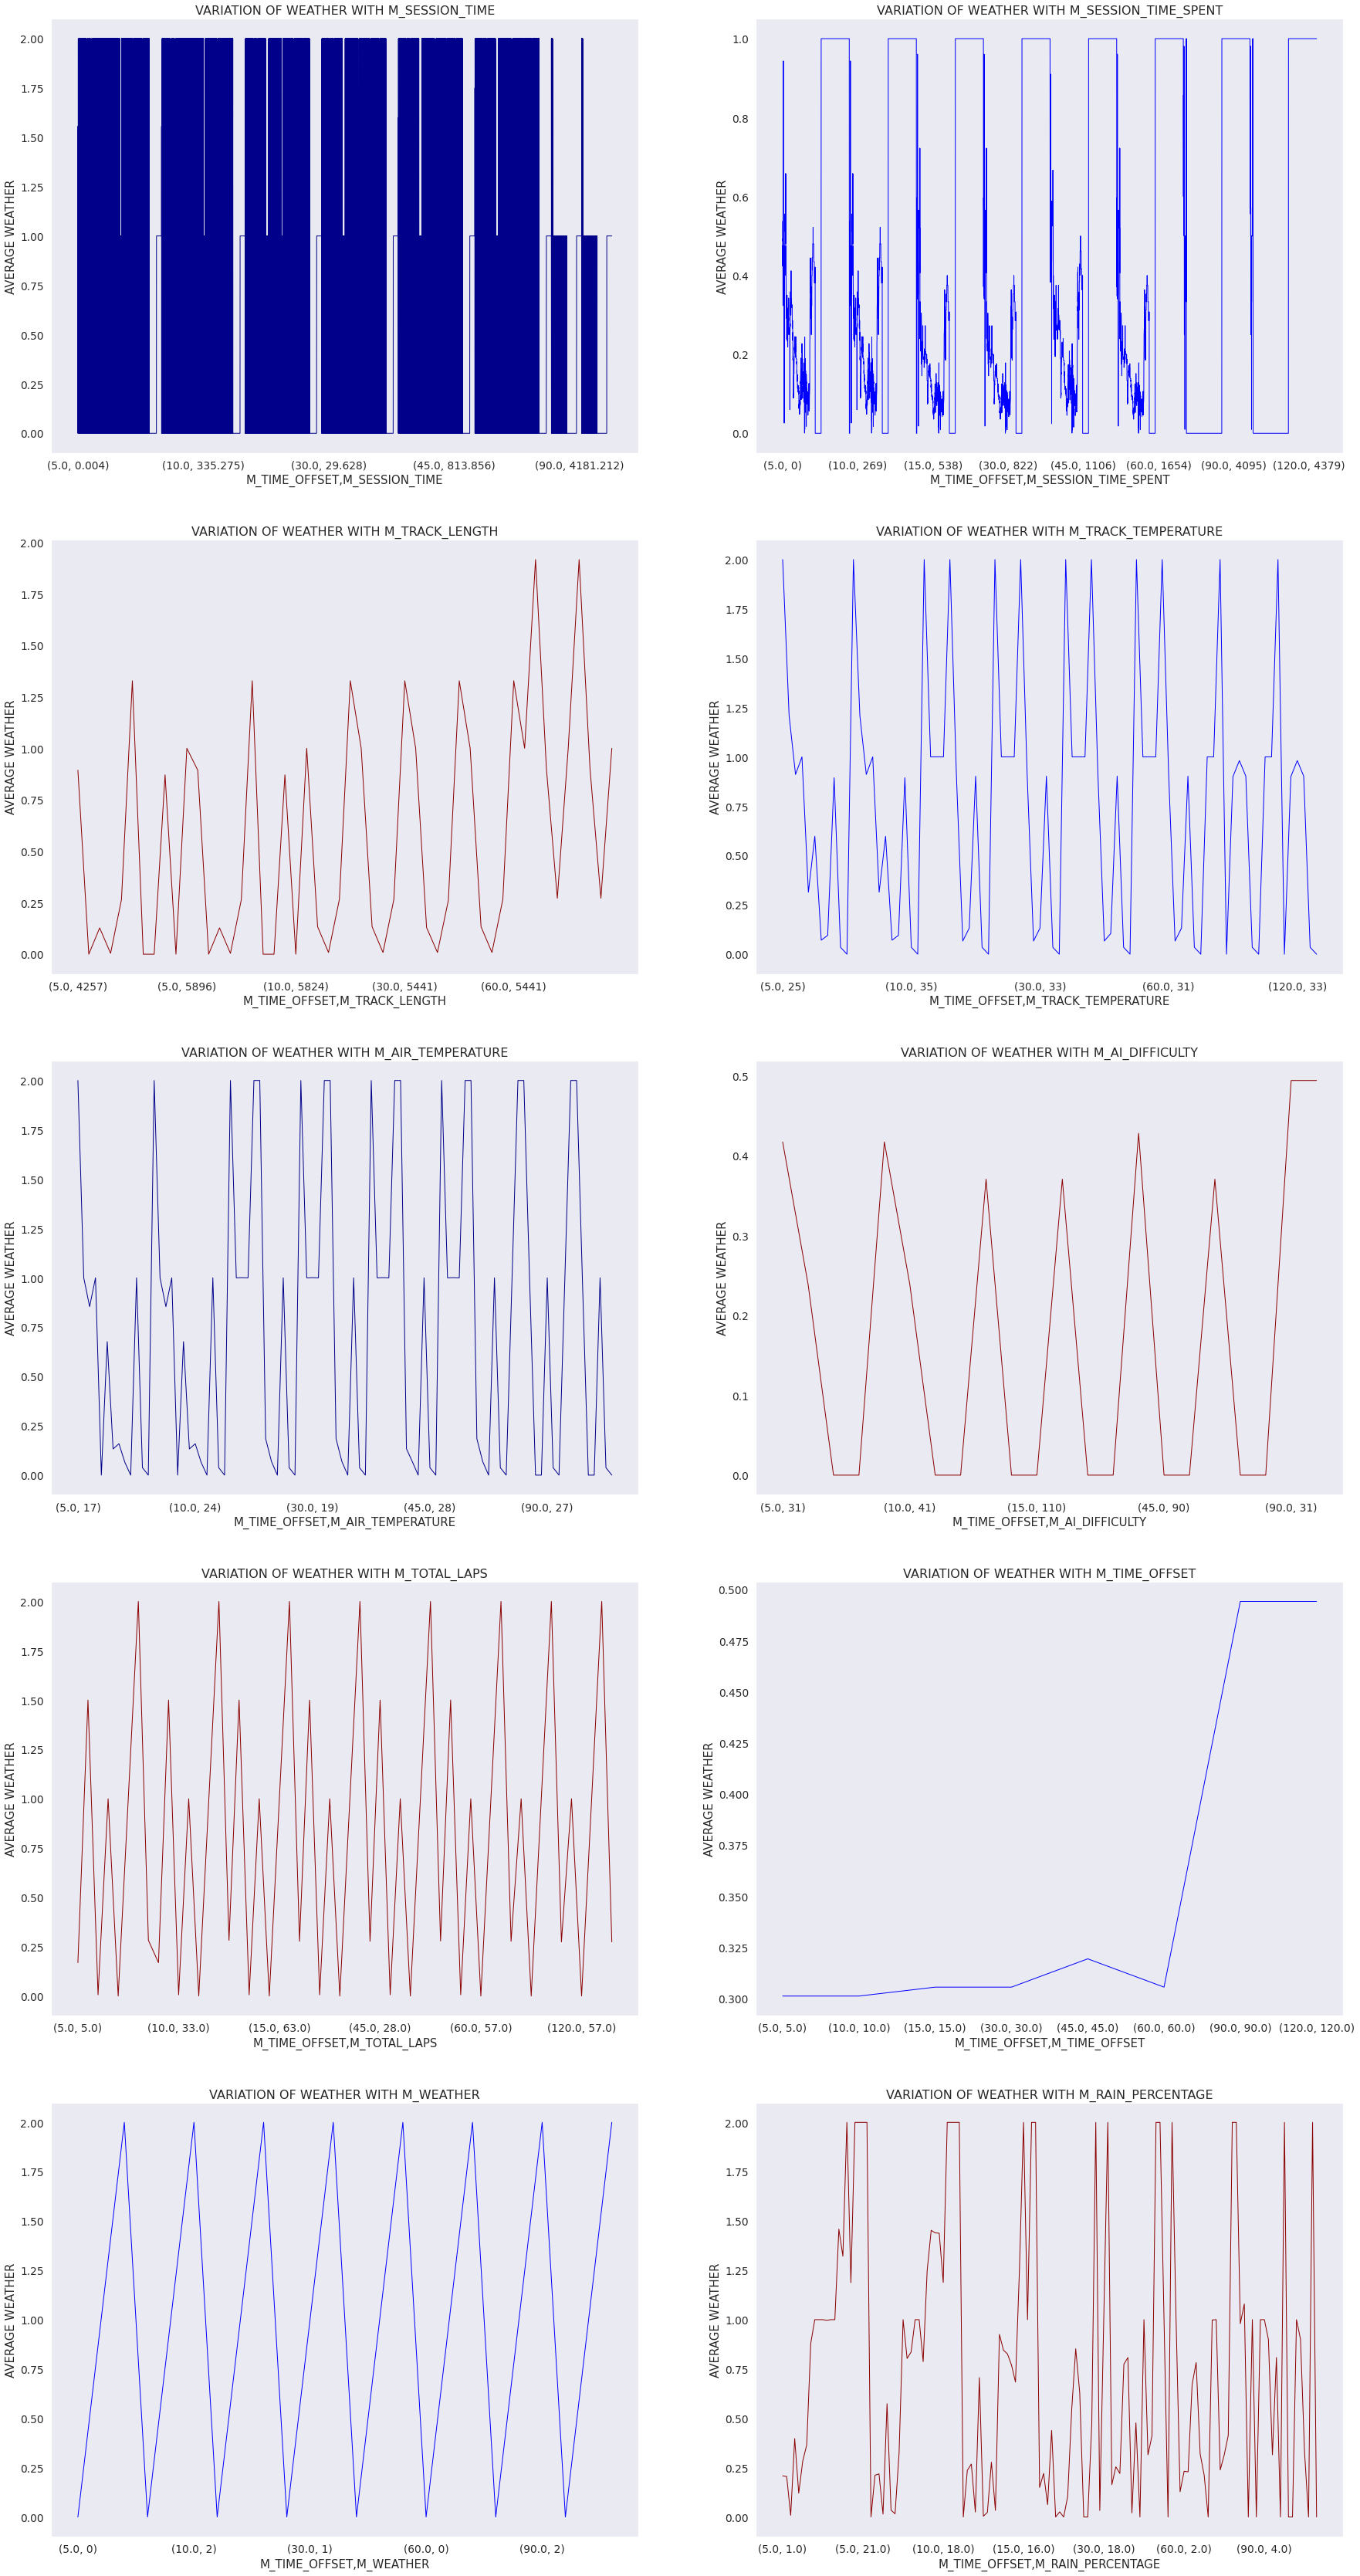

In [104]:
count = 1
colour = ['blue','darkred','darkblue']
plt.figure(figsize=(30,60))
for col in final_data_weather.columns:
    plt.subplot(5,2,count)
    final_data_weather.groupby(['M_TIME_OFFSET',col])['M_WEATHER'].mean().plot(lw=1,color=np.random.choice(colour))
    plt.ylabel('AVERAGE WEATHER') 
    plt.title('VARIATION OF WEATHER WITH {}'.format(col), fontsize = 16)
    plt.grid(False)
    if count<12:
        count+=1

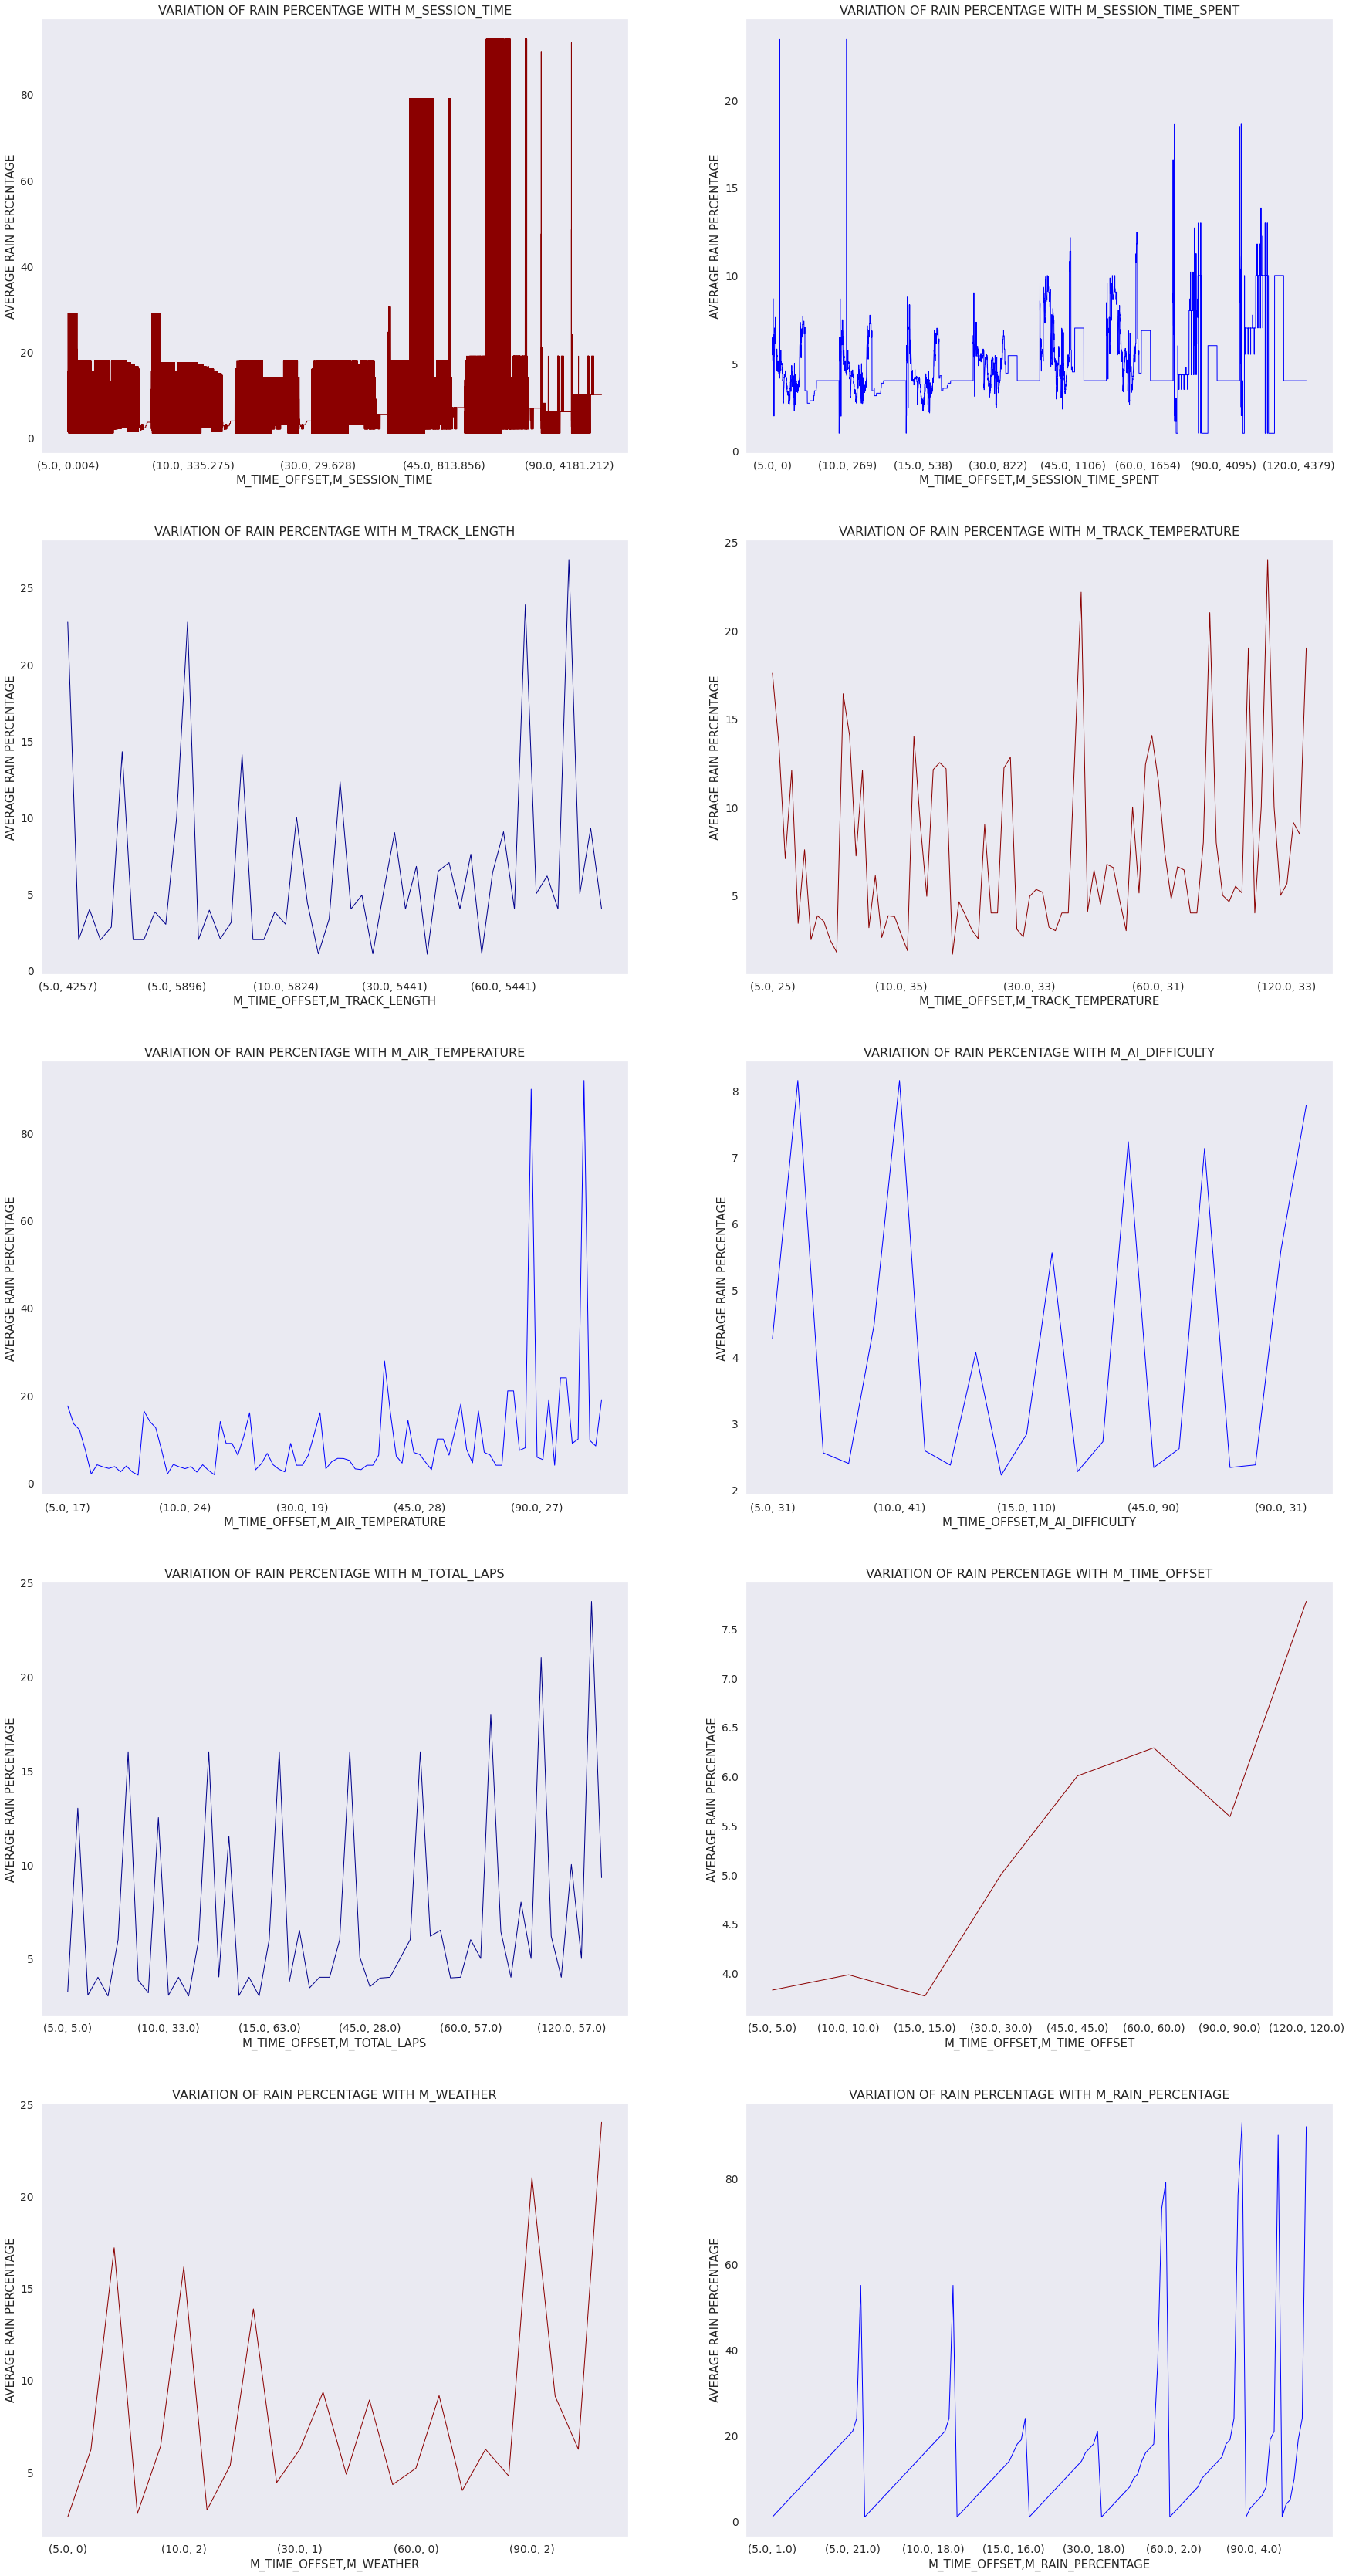

In [105]:
count = 1
colour = ['blue','darkred','darkblue']
plt.figure(figsize=(30,60))
for col in final_data_weather.columns:
    plt.subplot(5,2,count)
    final_data_weather.groupby(['M_TIME_OFFSET',col])['M_RAIN_PERCENTAGE'].mean().plot(lw=1,color=np.random.choice(colour))
    plt.ylabel('AVERAGE RAIN PERCENTAGE') 
    plt.title('VARIATION OF RAIN PERCENTAGE WITH {}'.format(col), fontsize = 16)
    plt.grid(False)
    if count<12:
        count+=1

In [106]:
#final_data_weather.reset_index(drop=True, inplace=True)
final_data_weather.head()

M_SESSION_TIME  M_SESSION_TIME_SPENT  M_TRACK_LENGTH  \
1530936           28.86                   788            4650   
1530939           28.86                   788            4650   
1530937           28.86                   788            4650   
1530940           28.86                   788            4650   
1530941           28.86                   788            4650   

         M_TRACK_TEMPERATURE  M_AIR_TEMPERATURE  M_AI_DIFFICULTY  \
1530936                   33                 25               90   
1530939                   33                 25               90   
1530937                   33                 25               90   
1530940                   33                 25               90   
1530941                   33                 25               90   

         M_TOTAL_LAPS  M_TIME_OFFSET  M_WEATHER  M_RAIN_PERCENTAGE  
1530936         200.0            5.0          0                3.0  
1530939         200.0            5.0          0                3.0  
1530937         200.0           10.0          0                3.0  
1530940         200.0           10.0          0                3.0  
1530941         200.0           15.0          0                3.0

In [107]:
#final_data_weather.to_csv('./final_data_weather.csv', index = False)

## Part III: Modelling Methodology
<h4><b>Overview</b></h4>

This is the Machine Learning component of our solution to the FormulaAI Hack 2022 Competition. The workflow for this notebook is outlined as follows:
- Cross-Validation Setup
- Experiments with Feature Transformation
- Model Experimentations I: Weather Classification
- Classification Leaderboard Ranking
- Model Experimentations II: Regression
- Regression Leaderboard Ranking 
- Holdout Evaluation

In [108]:
import os

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None, 'display.max_rows', 100)

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
#import deepchecks as dc

from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

from xgboost import XGBClassifier
from xgboost import XGBRFClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
#from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRFRegressor
from sklearn.svm import SVR

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV
#from sklearn.grid_search import HalvingGridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet

import random
import time
from datetime import datetime

***Read the data***

In [109]:
#final_data_weather = pd.read_csv('./final_data_weather.csv', index_col = False)
print(final_data_weather.shape)
final_data_weather.head(2)

(534055, 10)


M_SESSION_TIME  M_SESSION_TIME_SPENT  M_TRACK_LENGTH  \
1530936           28.86                   788            4650   
1530939           28.86                   788            4650   

         M_TRACK_TEMPERATURE  M_AIR_TEMPERATURE  M_AI_DIFFICULTY  \
1530936                   33                 25               90   
1530939                   33                 25               90   

         M_TOTAL_LAPS  M_TIME_OFFSET  M_WEATHER  M_RAIN_PERCENTAGE  
1530936         200.0            5.0          0                3.0  
1530939         200.0            5.0          0                3.0

In [110]:
weather_X = final_data_weather.drop('M_WEATHER', axis=1)
weather_y = final_data_weather['M_WEATHER']

rain_X = final_data_weather.drop('M_RAIN_PERCENTAGE', axis=1)
rain_y = final_data_weather['M_RAIN_PERCENTAGE']

print(weather_X.shape)
print(rain_X.shape)

(534055, 9)
(534055, 9)


<br>
<h4><b>1. Cross-Validation Set Up</b></h4>

***Creating train, test and validation sets***
    
We first split our data into train and test sets. The test set is our holdout set and will not be unlocked until the end of each of the 2 sequences of experiments for classification and regression, respectively. The validation set will be split out of the train data and will be used for primary evaluation and to compute cross validation scores in each of our experiments.

In [111]:
X_train, X_test, y_train, y_test = train_test_split(weather_X, weather_y, test_size=.25, random_state=42)

Considering the huge class imbalance in the weather target, ***we will implement repeated k-fold cross validation to further split our train data***. For our classification experiments, we will use ***repeated stratified k-fold cross validation***. We choose the value of 10 for *k* as this value has been shown empirically to yield test error rate estimates that suffer neither from excessively high bias nor from very high variance. In other words, we are choosing *k = 10* to achieve reasonable bias-variance trade-off in training.

In [112]:
#CV configuration for classificatoiclassification 
skfold = RepeatedStratifiedKFold(n_splits=10, n_repeats = 2, random_state=1)

#CV configuration for regression
kfold = RepeatedKFold(n_splits=10, n_repeats = 2, random_state=1)

Now, we will define a helper function that we will use for all our experiments. This function will also help to return validation scores for each experiment. We will customise this function a bit when we get to regression.

In [113]:
def training(X_train, y_train, model):

    fold_no = 1    
    n_scores, log_scores = [],[]
    for train_index, val_index in skfold.split(X_train, y_train):
        # select rows
        train_X, val_X = X_train.iloc[train_index], X_train.iloc[val_index]
        train_y, val_y = y_train.iloc[train_index], y_train.iloc[val_index]
        
        model.fit(train_X, train_y)
        
        n_scores.append(model.score(val_X, val_y))
        log_scores.append(log_loss(val_y, model.predict_proba(val_X), labels = [0,1,2]))
        print('For Fold {}, the Accuracy is {},'.format(str(fold_no), n_scores[fold_no - 1]), 
              'and the LogLoss is', log_scores[fold_no - 1])

        fold_no += 1
     
    #cv_score = cross_val_score(model, train_X, train_y, scoring='accuracy', cv=skfold, n_jobs=-1, error_score='raise')
    mean_accuracy, std_accuracy = np.mean(n_scores), np.std(n_scores)
    mean_loss, std_loss = np.mean(log_scores), np.std(log_scores)
    
    print('\n======================================')
    
    print('Mean Accuracy: %.3f (%.3f)' % (mean_accuracy, std_accuracy))
    #print('Mean CV Accuracy: %.3f (%.3f)' % (np.mean(cv_score), np.std(cv_score)))
    #
    #print('\n======================================')
    #
    print('Average LogLoss: {} ({})'.format(mean_loss, std_loss))

    return model, mean_loss

<br>
<h4><b>2. Experiments with Feature Transformation</b></h4>

For each algorithm we experiment with, we wil implement a variation using a scaled version of the training features. The following plots show the individual distribution of each input feature.

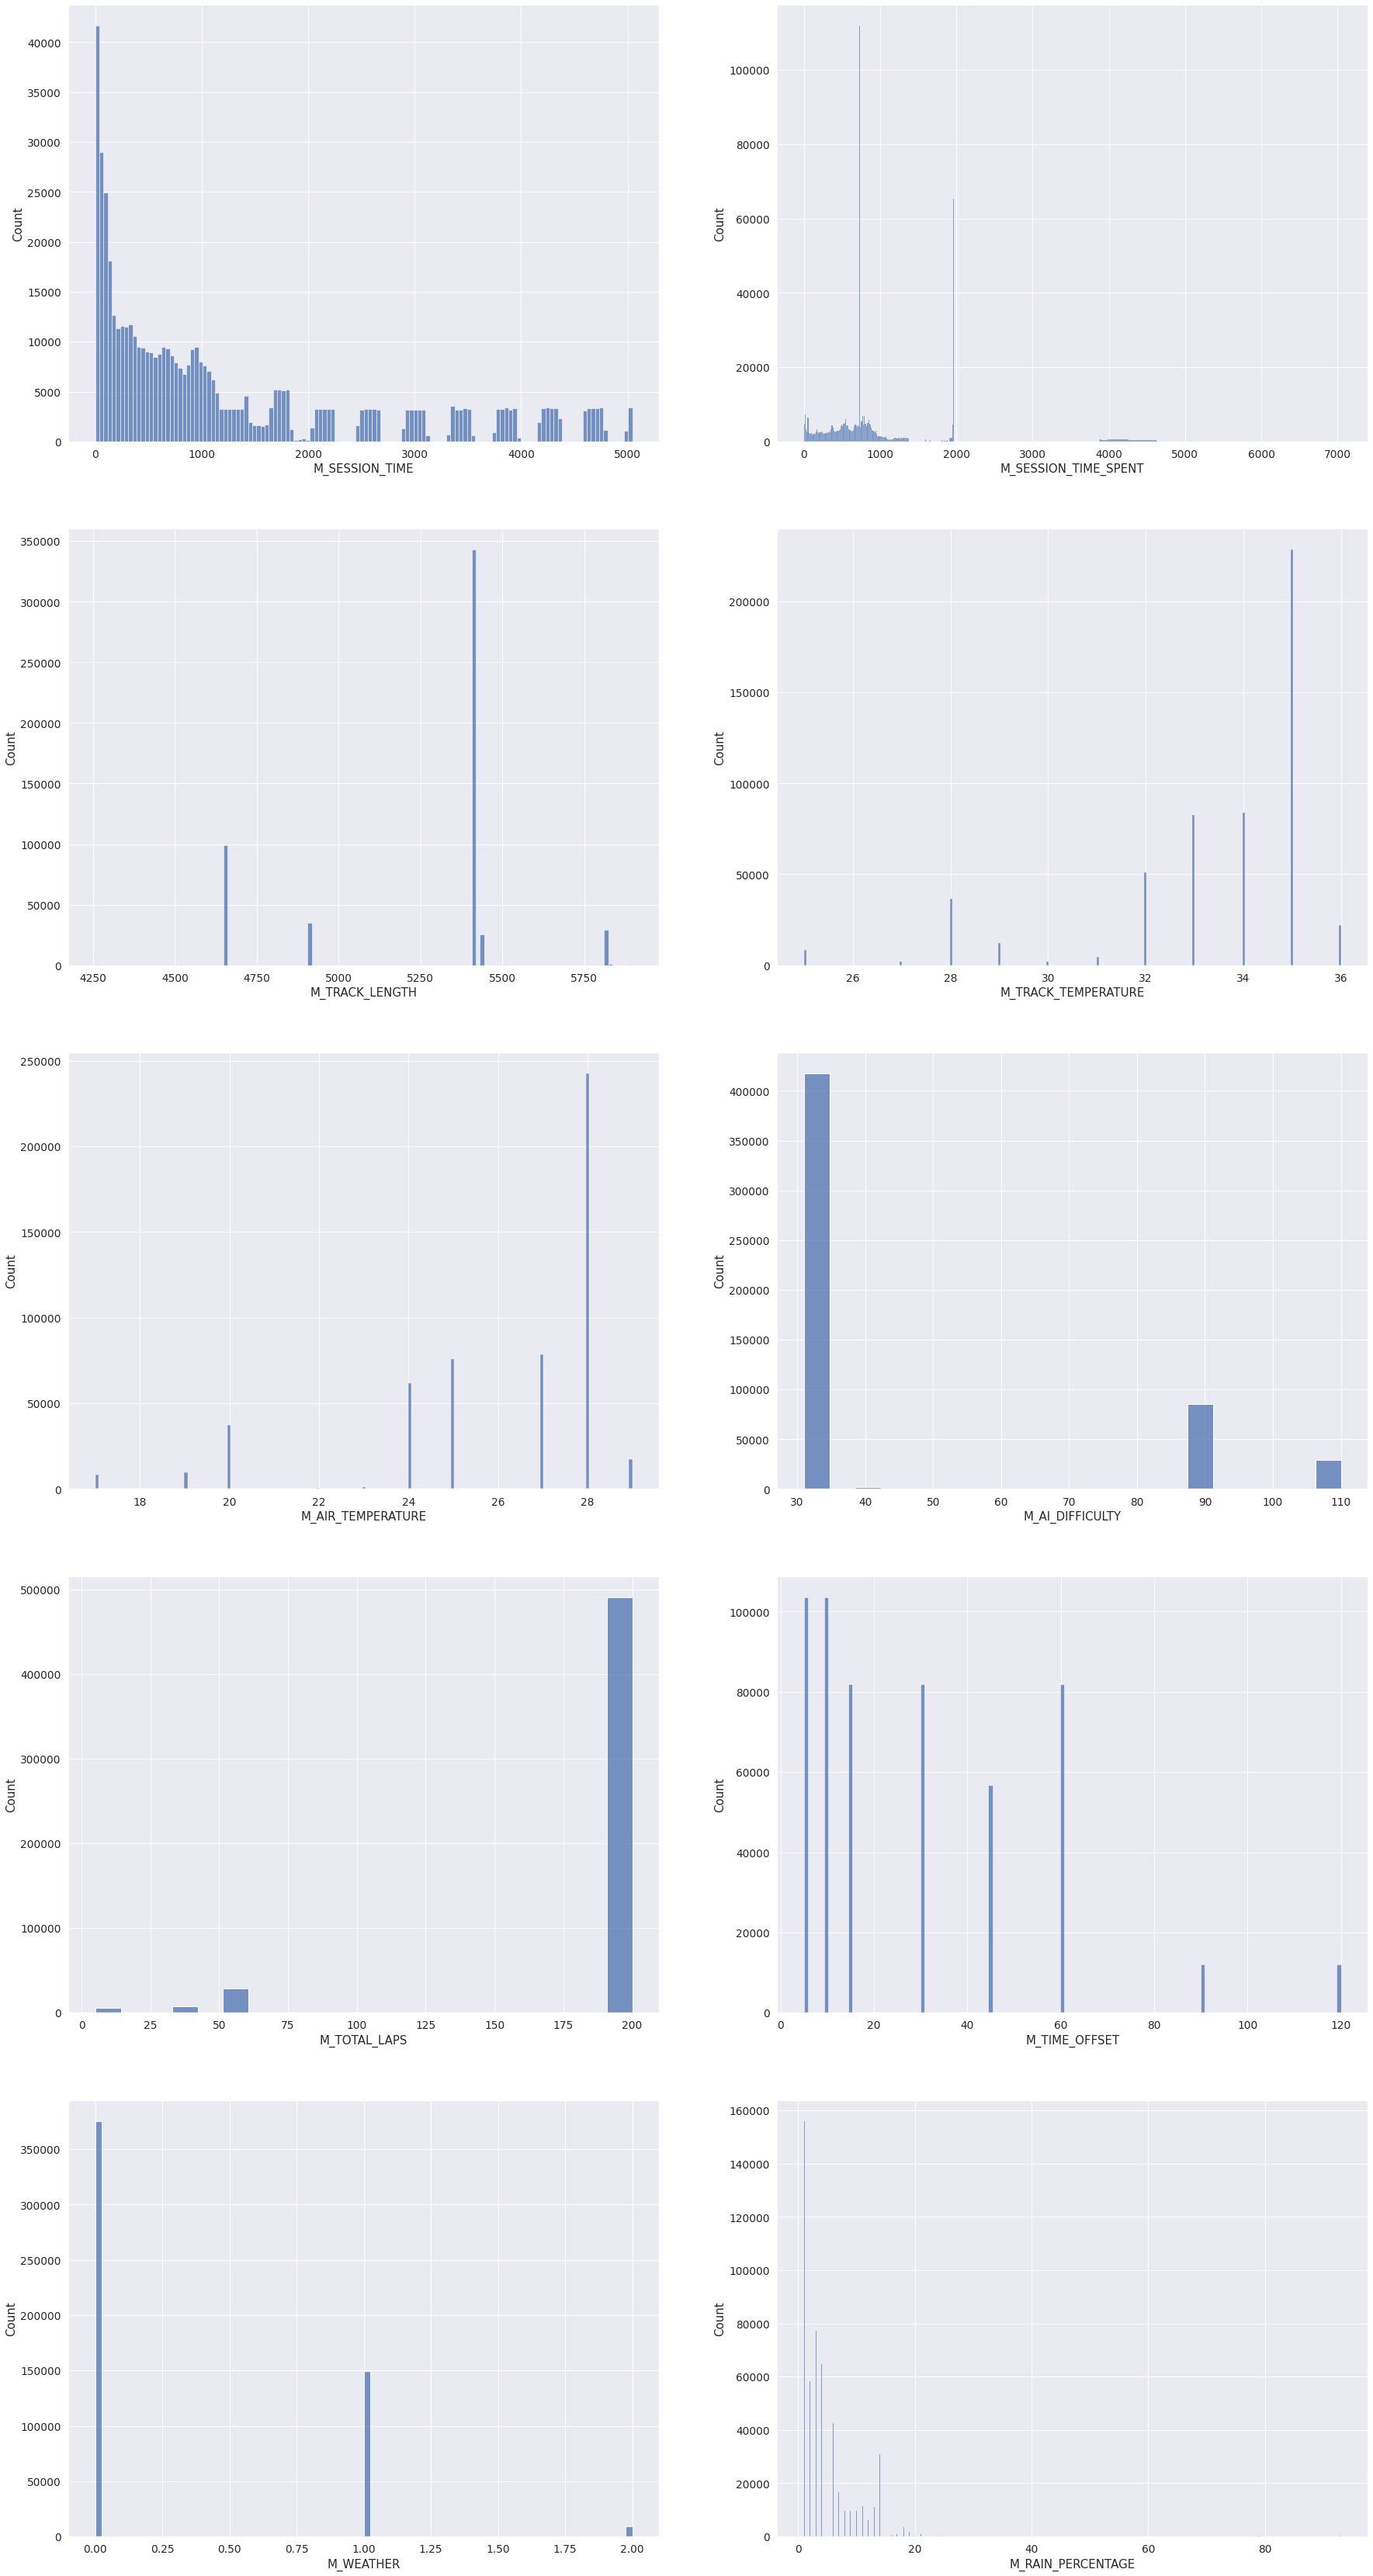

In [114]:
f, ax = plt.subplots(5,2, figsize = (30,60))
axx = ax.flatten()
for index, col in enumerate(final_data_weather.columns):
#     plt.figure(figsize=(15,8))
    sns.histplot(final_data_weather[col], ax=axx[index])

From the distribtion of the features, we see that it may be realistic to standardise the data given the absence of normality across features. We will run a variation of each of our modelling experiment with MinMaxScalar and narrow down the range of input values to [0, 10]. 

We wish to also test variations with RobustScaler to scale down input features in such a way that the influence of huge marginal points in the data are cancelled out.

***During these experiments with the scaled version of the data, we will make use of pipelines to avoid information leakage from our test data into the models we want to train.***

We define a pipeline construct below that implements the desired scaling on the training input features, then fits a model on this data. We will experiment with various models with and without feature transformation and see how they perform.

In [115]:
def scale_pipe(model_name, transformer, x_train, y_train):
    
    pipe = Pipeline([('scaler', transformer), ('model', model_name)])
    model_pipeline, mean_loss = training(x_train, y_train, pipe)
    
    return model_pipeline, mean_loss

<br>
<h4><b>3. Model Experimentations I: Weather Classification</b></h4>
Here are the 4 classification algorithms we will experiment with:

- XGBoost Classifier
- XGB Random Forest Classifier
- Light Gradient Boosted Machines Classifier
- Gradient Boosted Trees with CatBoost

##### **(a) XGBoost Classifier**

*Experiment 1: Without Standardisation*

In [116]:
xgb = XGBClassifier()
model_xgb, model_xgb_loss = training(X_train, y_train, xgb)
model_xgb

[16:28:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
For Fold 1, the Accuracy is 1.0, and the LogLoss is 1.697750032829032e-05
[16:29:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
For Fold 2, the Accuracy is 1.0, and the LogLoss is 1.526689769749743e-05
[16:29:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
For Fold 3, the Accuracy is 1.0, and the LogLoss is 1.609671417990262e-05
[16:30:34] WARNING:

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [117]:
model_xgb_loss

1.9831361503354622e-05

Experiment 2: With Standardisation - MinMax and Robust

In [118]:
#MinMaxScaler
xgb2 = XGBClassifier()
transformer = MinMaxScaler(feature_range=(0, 10),copy=False)
xgb_scaled, xgb_scaled_loss = scale_pipe(xgb2, transformer, X_train, y_train)
xgb_scaled_loss

[16:40:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
For Fold 1, the Accuracy is 1.0, and the LogLoss is 1.697750032829032e-05
[16:41:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
For Fold 2, the Accuracy is 1.0, and the LogLoss is 1.526689769749743e-05
[16:41:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
For Fold 3, the Accuracy is 1.0, and the LogLoss is 1.609671417990262e-05
[16:42:11] WARNING:

1.9836298017198116e-05

In [119]:
#RobustScaler
xgb3 = XGBClassifier()
transformer = RobustScaler()
xgb_scaled_2, xgb_scaled_2_loss = scale_pipe(xgb3, transformer, X_train, y_train)
xgb_scaled_2_loss

[16:52:04] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
For Fold 1, the Accuracy is 1.0, and the LogLoss is 1.697750032829032e-05
[16:52:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
For Fold 2, the Accuracy is 1.0, and the LogLoss is 1.526689769749743e-05
[16:53:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
For Fold 3, the Accuracy is 1.0, and the LogLoss is 1.609671417990262e-05
[16:53:49] WARNING:

1.9831320196391378e-05

##### **(b) XGBoost Random Forest Classifier**
Experiment 1: Without Standardisation

In [120]:
xgbrf = XGBRFClassifier(n_estimators=10, subsample=0.9, colsample_bynode=0.2)
xgb_forest, xgb_forest_loss = training(X_train, y_train, xgbrf)
xgb_forest

[17:03:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
For Fold 1, the Accuracy is 0.9891399325926851, and the LogLoss is 0.2575177353518596
[17:03:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
For Fold 2, the Accuracy is 0.9904129425275877, and the LogLoss is 0.2663295716274223
[17:03:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
For Fold 3, the Accuracy is 0.9899136166175663, and the LogLoss is 0.

XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bynode=0.2, colsample_bytree=1,
                enable_categorical=False, gamma=0, gpu_id=-1,
                importance_type=None, interaction_constraints='',
                max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
                monotone_constraints='()', n_estimators=10, n_jobs=4,
                num_parallel_tree=10, objective='multi:softprob',
                predictor='auto', random_state=0, reg_alpha=0,
                scale_pos_weight=None, subsample=0.9, tree_method='exact',
                validate_parameters=1, verbosity=None)

Experiment 2: With Standardisation

In [121]:
#MinMaxScaler

xgbrf2 = XGBRFClassifier(n_estimators=20, subsample=0.9, colsample_bynode=0.2)

transformer = MinMaxScaler(feature_range=(0, 10),copy=False)
xgb_forest_scaled, xgb_forest_scaled_loss = scale_pipe(xgbrf2, transformer, X_train, y_train)

[17:04:41] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
For Fold 1, the Accuracy is 0.9915116714517538, and the LogLoss is 0.26063192860008166
[17:04:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
For Fold 2, the Accuracy is 0.9918110550756479, and the LogLoss is 0.2510931805790337
[17:04:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
For Fold 3, the Accuracy is 0.9910620662106157, and the LogLoss is 0

In [122]:
#RobustScaler

xgbrf3 = XGBRFClassifier(n_estimators=20, subsample=0.9, colsample_bynode=0.2)

transformer = RobustScaler()
xgb_forest_scaled_2, xgb_forest_scaled_2_loss = scale_pipe(xgbrf3, transformer, X_train, y_train)

[17:06:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
For Fold 1, the Accuracy is 0.9915116714517538, and the LogLoss is 0.26063192860008166
[17:06:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
For Fold 2, the Accuracy is 0.9918110550756479, and the LogLoss is 0.2510931805790337
[17:06:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
For Fold 3, the Accuracy is 0.9910620662106157, and the LogLoss is 0

##### **(c) Light Gradient Boosted Machines Classifier**

*First Experiment: Without Standardisation*

In [123]:
lgb = LGBMClassifier()
lgb_model, lgb_loss = training(X_train, y_train, lgb)

For Fold 1, the Accuracy is 0.9999750343277993, and the LogLoss is 0.00010741856602358757
For Fold 2, the Accuracy is 0.9996005392719828, and the LogLoss is 0.0010242802931926843
For Fold 3, the Accuracy is 0.9992510111349678, and the LogLoss is 0.0011126607108965575
For Fold 4, the Accuracy is 0.9997004044539871, and the LogLoss is 0.0009640679672922763
For Fold 5, the Accuracy is 0.9998252359314925, and the LogLoss is 0.0006707057602607424
For Fold 6, the Accuracy is 0.9992510111349678, and the LogLoss is 0.0012713878454267754
For Fold 7, the Accuracy is 0.9999001348179957, and the LogLoss is 0.00023706763131749883
For Fold 8, the Accuracy is 1.0, and the LogLoss is 8.39994570163703e-07
For Fold 9, the Accuracy is 0.9994757077944775, and the LogLoss is 0.0012874708156613765
For Fold 10, the Accuracy is 0.9999750337044989, and the LogLoss is 3.618538759584415e-05
For Fold 11, the Accuracy is 0.9998002746223942, and the LogLoss is 0.0007579608954781375
For Fold 12, the Accuracy is 0.99

*Second Experiment: With Standardisation*

In [124]:
#MinMaxScaler

lgb2 = LGBMClassifier()
transformer = MinMaxScaler(feature_range=(0, 10),copy=False)
lgb_scaled, lgb_scaled_loss = scale_pipe(lgb2, transformer, X_train, y_train)

For Fold 1, the Accuracy is 0.9999750343277993, and the LogLoss is 0.00011982279428803226
For Fold 2, the Accuracy is 0.9996005392719828, and the LogLoss is 0.0010363446303745124
For Fold 3, the Accuracy is 0.9992510111349678, and the LogLoss is 0.001136593827594054
For Fold 4, the Accuracy is 0.9997004044539871, and the LogLoss is 0.0009682804946695855
For Fold 5, the Accuracy is 0.9998252359314925, and the LogLoss is 0.0006712610326167754
For Fold 6, the Accuracy is 0.9992510111349678, and the LogLoss is 0.0012749160386154043
For Fold 7, the Accuracy is 0.9999001348179957, and the LogLoss is 0.00023793228448502177
For Fold 8, the Accuracy is 1.0, and the LogLoss is 7.921585030819333e-07
For Fold 9, the Accuracy is 0.9994757077944775, and the LogLoss is 0.0013075310925793622
For Fold 10, the Accuracy is 1.0, and the LogLoss is 2.9786786510889432e-06
For Fold 11, the Accuracy is 0.999825240294595, and the LogLoss is 0.0006807841375904298
For Fold 12, the Accuracy is 0.9993758426124731,

In [125]:
#RobustScaler

lgb3 = LGBMClassifier()
transformer = RobustScaler()
lgb_scaled_2, lgb_scaled_2_loss = scale_pipe(lgb3, transformer, X_train, y_train)

For Fold 1, the Accuracy is 0.9997503432779927, and the LogLoss is 0.0006847788642543387
For Fold 2, the Accuracy is 0.9990762470664603, and the LogLoss is 0.0013233087734035108
For Fold 3, the Accuracy is 0.9990512807709592, and the LogLoss is 0.0016684421745409162
For Fold 4, the Accuracy is 0.9989014829979528, and the LogLoss is 0.0016482466925822961
For Fold 5, the Accuracy is 0.9995506066809807, and the LogLoss is 0.001096493411765395
For Fold 6, the Accuracy is 0.9992510111349678, and the LogLoss is 0.0011778247793090986
For Fold 7, the Accuracy is 0.9993009437259699, and the LogLoss is 0.0014053329861969251
For Fold 8, the Accuracy is 0.9991761122484646, and the LogLoss is 0.0012925043822245204
For Fold 9, the Accuracy is 0.9997503370449893, and the LogLoss is 0.0007630965408251865
For Fold 10, the Accuracy is 0.9999750337044989, and the LogLoss is 4.086670295718713e-05
For Fold 11, the Accuracy is 0.9995006865559856, and the LogLoss is 0.0012523100453665705
For Fold 12, the Acc

##### **(d) Gradient Boosted Trees with CatBoost Classifier**

*First Experiment: Without Standardisation*

In [126]:
ctb = CatBoostClassifier(verbose=0, n_estimators=100)
ctb_model, ctb_loss = training(X_train, y_train, ctb)

For Fold 1, the Accuracy is 0.9996005492447884, and the LogLoss is 0.0009086229062574567
For Fold 2, the Accuracy is 0.9994507414989764, and the LogLoss is 0.0014235271574908875
For Fold 3, the Accuracy is 0.9997253707494882, and the LogLoss is 0.0010076011873843833
For Fold 4, the Accuracy is 0.999650471862985, and the LogLoss is 0.0006097753039260373
For Fold 5, the Accuracy is 0.9999750337044989, and the LogLoss is 0.00015841611325374946
For Fold 6, the Accuracy is 0.998976381884456, and the LogLoss is 0.0018935990279472284
For Fold 7, the Accuracy is 0.9995256403854796, and the LogLoss is 0.001488805041173243
For Fold 8, the Accuracy is 0.9998002696359914, and the LogLoss is 0.0008867835000873699
For Fold 9, the Accuracy is 1.0, and the LogLoss is 0.00012563061709713075
For Fold 10, the Accuracy is 0.999675438158486, and the LogLoss is 0.0011668077205307093
For Fold 11, the Accuracy is 0.9991012358007739, and the LogLoss is 0.0015276033921678464
For Fold 12, the Accuracy is 0.99972

*Experiment 2: With Standardisation*

In [127]:
#MinMaxScaler

ctb2 = CatBoostClassifier(verbose=0, n_estimators=100)
transformer = MinMaxScaler(feature_range=(0, 10), copy=False)

ctb_scaled, ctb_scaled_loss = scale_pipe(ctb2, transformer, X_train, y_train)

For Fold 1, the Accuracy is 0.9996005492447884, and the LogLoss is 0.0009086229062574567
For Fold 2, the Accuracy is 0.9994507414989764, and the LogLoss is 0.0014235271574908875
For Fold 3, the Accuracy is 0.9997253707494882, and the LogLoss is 0.0010076011873843833
For Fold 4, the Accuracy is 0.999650471862985, and the LogLoss is 0.0006097753039260373
For Fold 5, the Accuracy is 0.9999750337044989, and the LogLoss is 0.00015841611325374946
For Fold 6, the Accuracy is 0.998976381884456, and the LogLoss is 0.0018935990279472284
For Fold 7, the Accuracy is 0.9995256403854796, and the LogLoss is 0.001488805041173243
For Fold 8, the Accuracy is 0.9998002696359914, and the LogLoss is 0.0008867835000873699
For Fold 9, the Accuracy is 1.0, and the LogLoss is 0.00012563061709713075
For Fold 10, the Accuracy is 0.999675438158486, and the LogLoss is 0.0011668077205307093
For Fold 11, the Accuracy is 0.9991012358007739, and the LogLoss is 0.0015276033921678464
For Fold 12, the Accuracy is 0.99972

In [128]:
#RobustScaler

ctb3 = CatBoostClassifier(verbose=0, n_estimators=100)
transformer = RobustScaler()

ctb_scaled_2, ctb_scaled_2_loss = scale_pipe(ctb3, transformer, X_train, y_train)

For Fold 1, the Accuracy is 0.9996005492447884, and the LogLoss is 0.0009086229062574567
For Fold 2, the Accuracy is 0.9994507414989764, and the LogLoss is 0.0014235271574908875
For Fold 3, the Accuracy is 0.9997253707494882, and the LogLoss is 0.0010076011873843833
For Fold 4, the Accuracy is 0.999650471862985, and the LogLoss is 0.0006097753039260373
For Fold 5, the Accuracy is 0.9999750337044989, and the LogLoss is 0.00015841611325374946
For Fold 6, the Accuracy is 0.998976381884456, and the LogLoss is 0.0018935990279472284
For Fold 7, the Accuracy is 0.9995256403854796, and the LogLoss is 0.001488805041173243
For Fold 8, the Accuracy is 0.9998002696359914, and the LogLoss is 0.0008867835000873699
For Fold 9, the Accuracy is 1.0, and the LogLoss is 0.00012563061709713075
For Fold 10, the Accuracy is 0.999675438158486, and the LogLoss is 0.0011668077205307093
For Fold 11, the Accuracy is 0.9991012358007739, and the LogLoss is 0.0015276033921678464
For Fold 12, the Accuracy is 0.99972

<br>
<h4><b>4. Classification Leaderboard</b></h4>

Before we unleash our holdout set which is 25% of our entire dataset, we will create a leaderboard of models built so far, to rank them by their mean logloss during cross-validation.

In [129]:
unpiped_models = [model_xgb_loss, xgb_forest_loss, lgb_loss, ctb_loss]
piped_models = [xgb_scaled_loss, xgb_forest_scaled_loss, lgb_scaled_loss, ctb_scaled_loss]
piped_models_2 = [xgb_scaled_2_loss, xgb_forest_scaled_2_loss, lgb_scaled_2_loss, ctb_scaled_2_loss]
model_index = ['XGBoost','XGBoost Random Forest','LightGBM', 'CatBoost Classifier']

pre_leaderboard_1 = pd.DataFrame({'Log Loss (Without Standardisation)': unpiped_models, 
                                  'Log Loss (With MinMaxScaler)': piped_models,
                                  'Log Loss (With RobustScaler)': piped_models_2}, index = model_index)

pd.set_option('display.float_format', lambda x: '%.15f' % x)
pre_leaderboard_1

Log Loss (Without Standardisation)  \
XGBoost                                 0.000019831361503   
XGBoost Random Forest                   0.266528848914734   
LightGBM                                0.000744477961803   
CatBoost Classifier                     0.000879113403337   

                       Log Loss (With MinMaxScaler)  \
XGBoost                           0.000019836298017   
XGBoost Random Forest             0.253229252819579   
LightGBM                          0.000732035057712   
CatBoost Classifier               0.000879113403337   

                       Log Loss (With RobustScaler)  
XGBoost                           0.000019831320196  
XGBoost Random Forest             0.253229258022485  
LightGBM                          0.000999133647946  
CatBoost Classifier               0.000879113403337

Now, let's set the tabe in ascending order, starting with the first column. We are ranking in ascending order as the goal of the learning algorithms is to minimise the log loss.

In [130]:
pre_leaderboard_1.nsmallest(4, 'Log Loss (Without Standardisation)')

Log Loss (Without Standardisation)  \
XGBoost                                 0.000019831361503   
LightGBM                                0.000744477961803   
CatBoost Classifier                     0.000879113403337   
XGBoost Random Forest                   0.266528848914734   

                       Log Loss (With MinMaxScaler)  \
XGBoost                           0.000019836298017   
LightGBM                          0.000732035057712   
CatBoost Classifier               0.000879113403337   
XGBoost Random Forest             0.253229252819579   

                       Log Loss (With RobustScaler)  
XGBoost                           0.000019831320196  
LightGBM                          0.000999133647946  
CatBoost Classifier               0.000879113403337  
XGBoost Random Forest             0.253229258022485

In [131]:
pre_leaderboard_1.nsmallest(4, 'Log Loss (With MinMaxScaler)')

Log Loss (Without Standardisation)  \
XGBoost                                 0.000019831361503   
LightGBM                                0.000744477961803   
CatBoost Classifier                     0.000879113403337   
XGBoost Random Forest                   0.266528848914734   

                       Log Loss (With MinMaxScaler)  \
XGBoost                           0.000019836298017   
LightGBM                          0.000732035057712   
CatBoost Classifier               0.000879113403337   
XGBoost Random Forest             0.253229252819579   

                       Log Loss (With RobustScaler)  
XGBoost                           0.000019831320196  
LightGBM                          0.000999133647946  
CatBoost Classifier               0.000879113403337  
XGBoost Random Forest             0.253229258022485

In [132]:
pre_leaderboard_1.nsmallest(4, 'Log Loss (With RobustScaler)')

Log Loss (Without Standardisation)  \
XGBoost                                 0.000019831361503   
CatBoost Classifier                     0.000879113403337   
LightGBM                                0.000744477961803   
XGBoost Random Forest                   0.266528848914734   

                       Log Loss (With MinMaxScaler)  \
XGBoost                           0.000019836298017   
CatBoost Classifier               0.000879113403337   
LightGBM                          0.000732035057712   
XGBoost Random Forest             0.253229252819579   

                       Log Loss (With RobustScaler)  
XGBoost                           0.000019831320196  
CatBoost Classifier               0.000879113403337  
LightGBM                          0.000999133647946  
XGBoost Random Forest             0.253229258022485

***Key insights from the Classification Leaderboard:***

- XGBoost performed nearly the same with and without standardisation. However, it performed the best with RobustScaler.
- CatBoost performed the same  with and without standardisation
- XGBoost Random Forest performed better with standardisation, in particular with MinMax.
- In all cases, XGBoost outperformed other models by a large margin. 
- In all cases, XGB Random Forest came behind other models by a large order.

We will therefore select XGBoost with RobustScaler when evaluating with our test (holdout) set.

<br>
<h4><b>5. Model Experimentations II: Regression</b></h4>
Here are the 4 regression algorithms we will experiment with:

- RandomForest Regressor
- Light Gradient Boosted Trees Regressor (with Early Stopping)
- ElasticNet Regularised Regression with Grid Search Optimisation
- XGBoost Regressor

Before we proceed, we specify a new train-test split using the rain percentage data. We also change our k-fold algorithm to RepeatedKFold. In each of these experiments, we will use cross validation to give us insights into which model performs the best before we then unlock holdout to apply the best algorithm.

In [133]:
X1_train, X1_test, y1_train, y1_test = train_test_split(rain_X, rain_y, test_size=.25, random_state=42)
kfold = RepeatedKFold(n_splits=10, n_repeats = 2, random_state=1)

In [134]:
def reg_train(X1_train, y1_train, model):

    fold_no = 1    
    n_scores, mae_scores = [],[]
    for train_index, val_index in kfold.split(X1_train, y1_train):
        train_X, val_X = X1_train.iloc[train_index], X1_train.iloc[val_index]
        train_y, val_y = y1_train.iloc[train_index], y1_train.iloc[val_index]
        
        model.fit(train_X, train_y)
        
        n_scores.append(model.score(val_X, val_y))
        mae_scores.append(mean_absolute_error(val_y, model.predict(val_X)))
        print('For Fold {}, the Accuracy is {},'.format(str(fold_no), n_scores[fold_no - 1]), 
              'and the LogLoss is', mae_scores[fold_no - 1])
        
        fold_no += 1
     
    mean_accuracy, std_accuracy = np.mean(n_scores), np.std(n_scores)
    mean_mae, std_mae = np.mean(mae_scores), np.std(mae_scores)
    
    print('\n======================================')
    
    print('Average Accuracy Score: {} ({})'.format(mean_accuracy, std_accuracy))
    print('Average MAE and Standard Deviation: {} ({})'.format(mean_mae, std_mae))

    return model, mean_mae

***We also define a new pipeline construct that incorporates the cross-validation process.***

In [135]:
def reg_pipe(model_name, transformer, x_train, y_train):
    
    pipe = Pipeline([('scaler', transformer), ('cv', model_name)])
    scores = cross_val_score(pipe, x_train, y_train, scoring='neg_mean_absolute_error', 
                            cv=kfold, n_jobs=-1, error_score='raise')
    
    scaled_mae = np.mean(scores)
    
    return pipe, scaled_mae

##### **(a) Random Forest Regressor**

*First Experiment: Without Standardisation*

In [136]:
rforest = RandomForestRegressor(n_estimators=20)
rforest, rforest_mae = reg_train(X1_train, y1_train, rforest)

For Fold 1, the Accuracy is 0.49949166214189156, and the LogLoss is 2.4459088770089443
For Fold 2, the Accuracy is 0.5210683299412135, and the LogLoss is 2.459815518655576
For Fold 3, the Accuracy is 0.47641965777034256, and the LogLoss is 2.4622021772050764
For Fold 4, the Accuracy is 0.5079607912648753, and the LogLoss is 2.4509119845335436
For Fold 5, the Accuracy is 0.5116710165065896, and the LogLoss is 2.453226278154092
For Fold 6, the Accuracy is 0.48847316822563036, and the LogLoss is 2.446541817793565
For Fold 7, the Accuracy is 0.4350023643439902, and the LogLoss is 2.4348086470435644
For Fold 8, the Accuracy is 0.5006213688293566, and the LogLoss is 2.451911625415328
For Fold 9, the Accuracy is 0.501448088082405, and the LogLoss is 2.470316625202652
For Fold 10, the Accuracy is 0.5105499735440531, and the LogLoss is 2.4492114511365317
For Fold 11, the Accuracy is 0.501847916170342, and the LogLoss is 2.415076167241984
For Fold 12, the Accuracy is 0.4610306878139344, and the 

*Second Experiment: With Standardisation*

In [137]:
r_forest_scaled, r_forest_scaled_mae = reg_pipe(RandomForestRegressor(n_estimators = 20), MinMaxScaler(feature_range=(0,10)), X1_train, y1_train)
r_forest_scaled_mae

-2.4526296345601537

In [138]:
r_forest_scaled_2, r_forest_scaled_2_mae = reg_pipe(RandomForestRegressor(n_estimators = 20), RobustScaler(), X1_train, y1_train)
r_forest_scaled_2_mae

-2.4524740070791053

##### **(b) Light Gradient Boosted Trees Regressor**

*First Experiment: Without Standardisation (and with Early Stopping)*

In [139]:
lgb = LGBMRegressor()
lgbr, lgb_mae = reg_train(X1_train, y1_train, lgb)

For Fold 1, the Accuracy is 0.6732646368729351, and the LogLoss is 2.0757427479308115
For Fold 2, the Accuracy is 0.6951163199253374, and the LogLoss is 2.0795833878946515
For Fold 3, the Accuracy is 0.6597515258379671, and the LogLoss is 2.0891255538433393
For Fold 4, the Accuracy is 0.6773708353625651, and the LogLoss is 2.072774333379287
For Fold 5, the Accuracy is 0.6868423204226737, and the LogLoss is 2.0773930778673915
For Fold 6, the Accuracy is 0.663704642843758, and the LogLoss is 2.079125268945897
For Fold 7, the Accuracy is 0.644514145658368, and the LogLoss is 2.05221233945736
For Fold 8, the Accuracy is 0.6677804080661729, and the LogLoss is 2.0846346030441465
For Fold 9, the Accuracy is 0.6753112044725713, and the LogLoss is 2.093476938539494
For Fold 10, the Accuracy is 0.6877886357562539, and the LogLoss is 2.0811980145755937
For Fold 11, the Accuracy is 0.6803169178259665, and the LogLoss is 2.044747486432289
For Fold 12, the Accuracy is 0.6554250581643268, and the Log

*Second Experiment: With Standardisation (and Without Early Stopping)*

In [140]:
lgb_scaled, lgb_scaled_mae = reg_pipe(LGBMRegressor(), MinMaxScaler(feature_range=(0,10)), X1_train, y1_train)
lgb_scaled_mae

-2.0790562002795374

In [141]:
lgb_scaled_2, lgb_scaled_2_mae = reg_pipe(LGBMRegressor(), RobustScaler(), X1_train, y1_train)
lgb_scaled_2_mae

-2.079208019719684

##### **(c) ElasticNet Regularised Regression with GridSearch Optimisation**

We will implement this algorithm by tuning both the ***L1 and L2*** penalties during training. A grid search is performed to find the ***alpha*** hyperparameter value that assigns the best weights to the contributions of the *L1* and *L2* penalties. The emerging alpha and L1 ratio are then used to fit the ElasticNet model.

In [142]:
ratios = np.arange(0, 1, 0.01)
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0]

cv = RepeatedKFold(n_splits = 5, n_repeats=1, random_state=1)

start_model = ElasticNetCV(l1_ratio = ratios, alphas = alphas, cv = cv, n_jobs = -1)
# fit model
start_model.fit(X1_train, y1_train)

ElasticNetCV(alphas=[1e-05, 0.0001, 0.001, 0.01, 0.1, 0.0, 1.0, 10.0, 100.0],
             cv=RepeatedKFold(n_repeats=1, n_splits=5, random_state=1),
             l1_ratio=array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99]),
             n_jobs=-1)

In [143]:
print(start_model.alpha_)
print(start_model.l1_ratio_)

0.0
0.01


In [144]:
#Implement cross-validation for ElasticNet across train data

enet = ElasticNet(alpha = start_model.alpha_,
                  l1_ratio = start_model.l1_ratio_)

enet_model, enet_mae = reg_train(X1_train, y1_train, enet)

For Fold 1, the Accuracy is 0.2793632095392199, and the LogLoss is 2.8536711236690775
For Fold 2, the Accuracy is 0.27955610878966575, and the LogLoss is 2.8716887999215754
For Fold 3, the Accuracy is 0.2722986988426416, and the LogLoss is 2.850297851021382
For Fold 4, the Accuracy is 0.2746779082390023, and the LogLoss is 2.842048048846436
For Fold 5, the Accuracy is 0.2787293795312875, and the LogLoss is 2.8686945993680966
For Fold 6, the Accuracy is 0.2761700752614743, and the LogLoss is 2.841408575142398
For Fold 7, the Accuracy is 0.2764486686837576, and the LogLoss is 2.804777644535346
For Fold 8, the Accuracy is 0.278652907095175, and the LogLoss is 2.8655318473953137
For Fold 9, the Accuracy is 0.2703606953163985, and the LogLoss is 2.8865070888208066
For Fold 10, the Accuracy is 0.27835431412902323, and the LogLoss is 2.8623237206606924
For Fold 11, the Accuracy is 0.2751814541215736, and the LogLoss is 2.8298318225268955
For Fold 12, the Accuracy is 0.28357976216563496, and t

*Second Experiment: With Standardisation*

In [145]:
enet_scaled = ElasticNet(alpha = start_model.alpha_,
                        l1_ratio = start_model.l1_ratio_)

enet_scaled, enet_scaled_mae = reg_pipe(enet_scaled, MinMaxScaler(feature_range=(0,10)), X1_train, y1_train)
enet_scaled_mae

-2.8546987638521513

In [146]:
enet_scaled2 = ElasticNet(alpha = start_model.alpha_,
                        l1_ratio = start_model.l1_ratio_)

enet_scaled_2, enet_scaled_2_mae = reg_pipe(enet_scaled2, RobustScaler(), X1_train, y1_train)
enet_scaled_2_mae

/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:394: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.962e+06, tolerance: 1.096e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  coe

-2.8546987638521513

##### **(d) XGBoost Regressor**

*First Experiment: Without Standardisation*

In [147]:
xgb_reg = XGBRegressor(objective='reg:squarederror')
xgbr, xgbr_mae = reg_train(X1_train, y1_train, xgb_reg)

For Fold 1, the Accuracy is 0.6668678842556652, and the LogLoss is 2.0728953531074947
For Fold 2, the Accuracy is 0.6797547691173009, and the LogLoss is 2.0755269170393746
For Fold 3, the Accuracy is 0.6511424745185139, and the LogLoss is 2.0813482056029184
For Fold 4, the Accuracy is 0.6767822503676935, and the LogLoss is 2.0670175780521034
For Fold 5, the Accuracy is 0.6760151775805454, and the LogLoss is 2.075996924632751
For Fold 6, the Accuracy is 0.6560729874455746, and the LogLoss is 2.076129631731093
For Fold 7, the Accuracy is 0.6234895213674272, and the LogLoss is 2.0548947843572654
For Fold 8, the Accuracy is 0.661175744245815, and the LogLoss is 2.0802502830689953
For Fold 9, the Accuracy is 0.6628504190550459, and the LogLoss is 2.0921911690958
For Fold 10, the Accuracy is 0.675668666758011, and the LogLoss is 2.0747181039182445
For Fold 11, the Accuracy is 0.6729878128197926, and the LogLoss is 2.0391256658842822
For Fold 12, the Accuracy is 0.6385425529721263, and the Lo

/opt/conda/lib/python3.7/site-packages/sklearn/pipeline.py:394: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.949e+06, tolerance: 1.091e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  coe

For Fold 20, the Accuracy is 0.6660340707632006, and the LogLoss is 2.083426510618934

Average Accuracy Score: 0.6632509281521947 (0.014233310806079829)
Average MAE and Standard Deviation: 2.0760779807061 (0.013527327314839917)


*Second Experiment: With Standardisation*

In [148]:
#MinMaxScaler
xgbr1 = XGBRegressor(objective='reg:squarederror')
xgbr_scaled, xgb1_scaled_mae = reg_pipe(xgbr1, MinMaxScaler(feature_range=(0,10)), X1_train, y1_train)
xgb1_scaled_mae

-2.076075417436343

In [149]:
#RobustScaler
xgbr2 = XGBRegressor(objective='reg:squarederror')
xgbr2_scaled, xgb2_scaled_mae = reg_pipe(xgbr2, RobustScaler(), X1_train, y1_train)
xgb2_scaled_mae

-2.076075209820108

<br>
<h4><b>6. Regression Leaderboard</b></h4>
To rank our models properly, we take the absolute value of the negative MAE scores since the innacuracy of predictions is based upon the magnitude of the MAE loss and not the direction.

In [150]:
unpiped_models_reg = [rforest_mae, lgb_mae, enet_mae, xgbr_mae]
piped_models_reg = np.absolute([r_forest_scaled_mae, lgb_scaled_mae, enet_scaled_mae, xgb1_scaled_mae])
piped_models_reg2 = np.absolute([r_forest_scaled_2_mae, lgb_scaled_2_mae, enet_scaled_2_mae, xgb2_scaled_mae])

reg_model_index = ['Random Forest Regressor','LightGBM Regressor', 'ENet Regularised','XGBoost Regressor']
pre_leaderboard_2 = pd.DataFrame({'MAE (Without Standardisation)': unpiped_models_reg, 
                                  'MAE (With MinMaxScaler)': piped_models_reg,
                                  'MAE (With RobustScaler)': piped_models_reg2}, index = reg_model_index)

pd.set_option('display.float_format', lambda x: '%.15f' % x)
pre_leaderboard_2

MAE (Without Standardisation)  \
Random Forest Regressor              2.452914005320938   
LightGBM Regressor                   2.078632692659060   
ENet Regularised                     2.854698763852151   
XGBoost Regressor                    2.076077980706100   

                         MAE (With MinMaxScaler)  MAE (With RobustScaler)  
Random Forest Regressor        2.452629634560154        2.452474007079105  
LightGBM Regressor             2.079056200279537        2.079208019719684  
ENet Regularised               2.854698763852151        2.854698763852151  
XGBoost Regressor              2.076075417436343        2.076075209820108

In [151]:
pre_leaderboard_2.nsmallest(4, 'MAE (Without Standardisation)')

MAE (Without Standardisation)  \
XGBoost Regressor                    2.076077980706100   
LightGBM Regressor                   2.078632692659060   
Random Forest Regressor              2.452914005320938   
ENet Regularised                     2.854698763852151   

                         MAE (With MinMaxScaler)  MAE (With RobustScaler)  
XGBoost Regressor              2.076075417436343        2.076075209820108  
LightGBM Regressor             2.079056200279537        2.079208019719684  
Random Forest Regressor        2.452629634560154        2.452474007079105  
ENet Regularised               2.854698763852151        2.854698763852151

In [152]:
pre_leaderboard_2.nsmallest(4, 'MAE (With MinMaxScaler)')

MAE (Without Standardisation)  \
XGBoost Regressor                    2.076077980706100   
LightGBM Regressor                   2.078632692659060   
Random Forest Regressor              2.452914005320938   
ENet Regularised                     2.854698763852151   

                         MAE (With MinMaxScaler)  MAE (With RobustScaler)  
XGBoost Regressor              2.076075417436343        2.076075209820108  
LightGBM Regressor             2.079056200279537        2.079208019719684  
Random Forest Regressor        2.452629634560154        2.452474007079105  
ENet Regularised               2.854698763852151        2.854698763852151

In [153]:
pre_leaderboard_2.nsmallest(4, 'MAE (With RobustScaler)')

MAE (Without Standardisation)  \
XGBoost Regressor                    2.076077980706100   
LightGBM Regressor                   2.078632692659060   
Random Forest Regressor              2.452914005320938   
ENet Regularised                     2.854698763852151   

                         MAE (With MinMaxScaler)  MAE (With RobustScaler)  
XGBoost Regressor              2.076075417436343        2.076075209820108  
LightGBM Regressor             2.079056200279537        2.079208019719684  
Random Forest Regressor        2.452629634560154        2.452474007079105  
ENet Regularised               2.854698763852151        2.854698763852151

From the leaderboard, we see that the champion model for the regression task is the XGBoost Regressor which outperformed others across the three feature variations. We are now going to unlock our test (holdout) set for evaluation using XGBoost with RobustScaler.

<h4><b>6. Holdout Evaluation</b></h4>

<b> (a) Top Performing Models </b>
- From the classification experiments, the champion model was the **XGBoost Classifier with RobustScaler preprocessing**
- From the regression experiments, the champion model was the **XGBoost Regressor with RobustScaler preprocessing**

<b> (b) Evaluating Model Accuracy </b>

Now, we unlock our holdout set and implement a pipeline to carry out the standardisation, prediction, and evaluation procedures. We will use the same evaluation metrics we used during cross-validation, namely: LogLoss Categorical Accuracy and Mean Absolute Error (MAE).

In [154]:
def class_pipe_score(estimator):
    
    '''
    This function constructs a pipeline of standardisation and modelling 
    steps for our classification champion model and returns the specified accuracy score 
    from the evaluation of the test set.
    '''
    
    pipe = Pipeline([('scaler', RobustScaler()), ('model', estimator)])
    model = pipe.fit(X_train, y_train)
    
    prediction = model.predict_proba(X_test)
    evaluation = log_loss(y_test, prediction, labels = [0,1,2])
    
    return model, evaluation

def reg_pipe_score(estimator):
    
    '''
    This function constructs a pipeline of standardisation and modelling 
    steps for our regression champion model and returns the specified accuracy score 
    from the evaluation of the test set.
    '''
    
    pipe = Pipeline([('scaler', RobustScaler()), ('model', estimator)])
    model = pipe.fit(X1_train, y1_train)
    
    prediction = model.predict(X1_test)
    evaluation = mean_absolute_error(y1_test, prediction)
    
    return model, evaluation

In [155]:
class_model, class_eval = class_pipe_score(xgb_scaled_2)

[18:09:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [156]:
reg_model, reg_eval = reg_pipe_score(xgbr2_scaled)

In [157]:
print(class_eval)
print(reg_eval)

1.8128004327102194e-05
2.0722046806401186


***Here's a summary table of the two champion models we obtained and their accuracy scores.***

In [158]:
metrics = ['LogLoss','MAE']
scores = [class_eval,reg_eval]
index = ['XGBoost Classifier','XGBoost Regressor']

pd.set_option('display.float_format', lambda x: '%.15f' % x)
model_summary = pd.DataFrame({'Evaluation Metric':metrics, 'Evaluation Score':scores}, index = index)
model_summary

Evaluation Metric  Evaluation Score
XGBoost Classifier           LogLoss 0.000018128004327
XGBoost Regressor                MAE 2.072204680640119

<h4> </h4>

## Part IV: Predictions and Exporting

In [159]:
import pickle
import json

In [160]:
def twin_predictor(input_data, estimators):
    """
    reads data, processes it for the classification and regression tasks, 
    passes it into "models" (a stack of the classifier and regressor) for inference,
    and returns a json response of predictions across the time intervals
    of {5,10,15,30,60} minutes after a session timestamp.
    """
    
    #Split data into weather data and rain data to be taken in by the respective models
    weather_input = input_data.drop('M_WEATHER', axis = 1)
    rain_input = input_data.drop('M_RAIN_PERCENTAGE', axis = 1)
    X_list = [weather_input, rain_input] 

    export = dict()
    intervals = [5,10,15,30,60]
    weather_type = ['Clear', 'Light Cloud', 'Overcast', 'Light Rain', 'Heavy Rain', 'Storm']
    
    for time in intervals:
        
        #Assign selected offset to the offset fields
        weather_input['M_TIME_OFFSET'] = time
        rain_input['M_TIME_OFFSET'] = time
        
        #Run inference
        prediction1 = estimators[0].predict(X_list[0])
        prediction2 = estimators[1].predict(X_list[1])
        
        #Output results
        for i,j in enumerate(weather_type):
            if int(prediction1) == i:
                export['{} min'.format(time)] = {
                    'Weather Type': '{} ({})'.format(i,j),
                    'Rain Percentage' : round(prediction2[0],2).item()
                }
        
    return json.dumps(export)
    

In [161]:
models = [class_model, reg_model]
full_test_data = final_data_weather[(final_data_weather.drop('M_WEATHER', axis = 1).isin(X_test)).all(axis=1)]
test_data = full_test_data.iloc[2000:2001]

In [162]:
twin_predictor(test_data, models)

'{"5 min": {"Weather Type": "0 (Clear)", "Rain Percentage": 2.369999885559082}, "10 min": {"Weather Type": "0 (Clear)", "Rain Percentage": 2.4800000190734863}, "15 min": {"Weather Type": "0 (Clear)", "Rain Percentage": 2.740000009536743}, "30 min": {"Weather Type": "0 (Clear)", "Rain Percentage": 4.340000152587891}, "60 min": {"Weather Type": "0 (Clear)", "Rain Percentage": 6.639999866485596}}'

**(b) Exporting, loading and testing**

In [163]:
twin_ai_features = './twin_ai_features.pkl'
pickle.dump(final_data_weather.columns, open(twin_ai_features, 'wb'))

estimators = [class_model, reg_model]
twin_ai_predictor = './estimators.pkl'
pickle.dump(estimators, open('twin_ai_predictor', 'wb'))

In [164]:
load_model = pickle.load(open('twin_ai_predictor', 'rb'))
make_prediction = twin_predictor(test_data, load_model)

print(make_prediction)

{"5 min": {"Weather Type": "0 (Clear)", "Rain Percentage": 2.369999885559082}, "10 min": {"Weather Type": "0 (Clear)", "Rain Percentage": 2.4800000190734863}, "15 min": {"Weather Type": "0 (Clear)", "Rain Percentage": 2.740000009536743}, "30 min": {"Weather Type": "0 (Clear)", "Rain Percentage": 4.340000152587891}, "60 min": {"Weather Type": "0 (Clear)", "Rain Percentage": 6.639999866485596}}


## Next Steps

Having completed the machine learning workflow for this challenge, we will continue work on the following objectives to take our models out of the notebook and into the real world:
- Deploy the models into a containerised service on Kubernetes via Oracle Cloud
- Set up real-time inference pipeline for online predictions
- Expose the inference API to be consumed by a frontend UI built with React.js and fastAPI.
- Set up MLOps infrastructure and workflows to monitor model performance in production
- Continuously retraining model to achieve better results and to ensure stability of model quality in production

## Closing Remarks/Acknowledgements

We sincerely thank Hackmakers and Oracle for hosting this amazing contest. It was a fun and challenging experience, albeit with a mix of severe external limitations we had to overcome. We look forward to seeing the winning solutions and how other approached the problem. We will continue to learn more and more about the Formula One ecosystem, and we hope to discover more of the amazing work that the RedBull Research team is doing.

 #### **Notebook by Team Twin AI**